# Informe del Análisis de Calidad de Datos: 

#### 15 de Noviembre de 2024

Documentar en formato markdown los resultados del análisis de calidad de los datos, identificando problemas encontrados (como valores faltantes o inconsistencias) y detallando las soluciones implementadas para garantizar la confiabilidad del análisis posterior.

## 1. Descripción de los datos de **Cash Requests (CR)**
   ### 1. Enumeración de Campos y Posibles Valores

1. **`status`**  
   - **Descripción:** Estado del Cash Request (CR).  
   - **Posibles valores:**
     - `approved`: Aprobado automáticamente o manualmente; los fondos se enviarán.
     - `money_sent`: Fondos transferidos al cliente; cambiará a `active` cuando el cliente los reciba.
     - `rejected`: CR revisado manualmente y rechazado.
     - `pending`: Pendiente de revisión manual.
     - `transaction_declined`: Error en la transferencia de fondos.
     - `waiting_user_confirmation`: El usuario debe confirmar la solicitud.
     - `direct_debit_rejected`: Débito directo SEPA rechazado.
     - `canceled`: Solicitud cancelada por falta de confirmación del usuario.
     - `direct_debit_sent`: Débito directo programado pero no confirmado.
     - `waiting_reimbursement`: Reembolso pendiente de selección de fecha.
     - `active`: Fondos recibidos en la cuenta del cliente.
     - `money_back`: CR reembolsado exitosamente.
3. **`created_at`**  
   - **Descripción:** Fecha y hora de creación del CR.  
   - **Posibles valores:** Marca de tiempo (ISO 8601).

4. **`updated_at`**  
   - **Descripción:** Fecha y hora de la última actualización del CR.  
   - **Posibles valores:** Marca de tiempo (ISO 8601).

5. **`user_id`**  
   - **Descripción:** ID único del usuario que solicitó el CR.  
   - **Posibles valores:** Identificador único.

6. **`moderated_at`**  
   - **Descripción:** Fecha y hora de la revisión manual (si aplica).  
   - **Posibles valores:** Marca de tiempo (ISO 8601) o `null`.

7. **`deleted_account_id`**  
   - **Descripción:** ID de usuario anonimizado si la cuenta fue eliminada.  
   - **Posibles valores:** Identificador único o `null`.

8. **`reimbursement_date`**  
   - **Descripción:** Fecha planificada para el reembolso.  
   - **Posibles valores:** Fecha (ISO 8601).

9. **`cash_request_debited_date`**  
   - **Descripción:** Fecha del último débito directo observado (si aplica).  
   - **Posibles valores:** Fecha (ISO 8601) o `null`.

10. **`cash_request_received_date`**  
    - **Descripción:** Fecha de recepción del CR por parte del cliente.  
    - **Posibles valores:** Fecha (ISO 8601) o `null`.

11. **`money_back_date`**  
    - **Descripción:** Fecha en que el CR fue reembolsado completamente.  
    - **Posibles valores:** Fecha (ISO 8601) o `null`.

12. **`transfer_type`**  
    - **Descripción:** Tipo de transferencia elegida por el usuario.  
    - **Posibles valores:**
      - `Instant`
      - `Regular`

13. **`send_at`**  
    - **Descripción:** Fecha y hora de la transferencia de fondos.  
    - **Posibles valores:** Marca de tiempo (ISO 8601) o `null`.

14. **`recovery_status`**  
    - **Descripción:** Estado del incidente de pago (si aplica).  
    - **Posibles valores:**
      - `null`: Sin incidentes de pago.
      - `completed`: Incidente resuelto.
      - `pending`: Incidente abierto.
      - `pending_direct_debit`: Incidente abierto con débito directo lanzado.

15. **`reco_creation`**  
    - **Descripción:** Fecha y hora de creación del caso de recuperación.  
    - **Posibles valores:** Marca de tiempo (ISO 8601) o `null`.

16. **`reco_last_update`**  
    - **Descripción:** Última fecha de actualización del caso de recuperación.  
    - **Posibles valores:** Marca de tiempo (ISO 8601) o `null`.

---

### Reflexión y Análisis para EDA

1. **Campos a analizar más en profundidad:**
   - **`status` y `recovery_status`:** Permiten identificar el flujo de estados y posibles incidencias. Útil para análisis de tasas de éxito o problemas operativos.
   - **Tiempos (`created_at`, `updated_at`, `reimbursement_date`, etc.):** Identificar patrones temporales o retrasos en procesos.
   - **`transfer_type`:** Analizar la preferencia de los usuarios entre transferencias instantáneas y regulares.

2. **Transformaciones necesarias:**
   - **Estandarización temporal:** Convertir todas las marcas de tiempo a un formato único y establecer zonas horarias si fuera relevante.
   - **Valores faltantes (`null`):** Imputar valores, reemplazar o analizar su impacto según el contexto del análisis.
   - **Derivación de nuevas variables:** 
     - Duraciones entre eventos clave (e.g., `created_at` y `send_at`).
   - **Outliers:** Identificar valores extremos en campos de fechas o estados que puedan reflejar errores.

   - print('Conclusiones: deleted_account_id y user_id tienen nulos complementarios')
   - print('Conclusiones: reco* solo están informadas para aquellos registros afectados')
   - print('Conclusiones: moderated_at está menos poblada a medida que pasa el tiempo')
   - print('Conclusiones: money_back y raceived están más pobladan a medida que pasa el tiempo')


In [458]:
!pip install --upgrade seaborn statsmodels

# Importar librerías necesarias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

  Using cached statsmodels-0.14.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.2 kB)
Using cached statsmodels-0.14.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.7 MB)


In [365]:
# Cargar el dataset principal de solicitudes de adelanto en efectivo
cash_request = pd.read_csv('../project_dataset/extract - cash request - data analyst.csv')
# Inspeccionar la estructura y el tipo de datos de 'cash_request'
cash_request.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          23970 non-null  int64  
 1   amount                      23970 non-null  float64
 2   status                      23970 non-null  object 
 3   created_at                  23970 non-null  object 
 4   updated_at                  23970 non-null  object 
 5   user_id                     21867 non-null  float64
 6   moderated_at                16035 non-null  object 
 7   deleted_account_id          2104 non-null   float64
 8   reimbursement_date          23970 non-null  object 
 9   cash_request_received_date  16289 non-null  object 
 10  money_back_date             16543 non-null  object 
 11  transfer_type               23970 non-null  object 
 12  send_at                     16641 non-null  object 
 13  recovery_status             333

In [366]:

cash_request.describe()


id        amount        user_id  deleted_account_id
count  23970.000000  23970.000000   21867.000000         2104.000000
mean   13910.966124     82.720818   32581.250789         9658.755228
std     7788.117214     26.528065   27618.565773         7972.743249
min        3.000000      1.000000      34.000000           91.000000
25%     7427.250000     50.000000   10804.000000         3767.000000
50%    14270.500000    100.000000   23773.000000         6121.500000
75%    20607.750000    100.000000   46965.000000        16345.000000
max    27010.000000    200.000000  103719.000000        30445.000000

## 2 Análisis de Calidad de Datos 

El análisis de la calidad de datos es una parte fundamental en el proceso de ciencias de datos.Su objetivo es evaluar la integridad,precisión,consistencia y confiabilidad de los datos utilizados en un proyecto o análisis 

1. **Identificación de valores faltantes**: Este paso implica detectar si hay campos o variables en el conjunto de datos que carecen de valores.Los valores faltantes pueden deberse a diversos motivos,como errores en la entrada de datos,fallas en los sistemas de recolección o simplemente la ausencia de información.
2. **Detección de inconsistencias en los datos**: Consiste en buscar discrepancias o contradicciones entre los datos.Por ejemplo, si en un conjunto de datos sobre ventas se encuentra que el número de productos vendidos en un día es mayor que el inventario inicial, esto podría ser una inconsistencia.
3. **Identificación de posibles errores**: Esto implica buscar valores atípicos, anomalías o datos que no tienen sentido dentro delcontexto delconjunto de datos.Los errores pueden manifestarse de diversas formas,como valores extremadamente altos o bajos que no son representativos del resto de los datos, o datos que violan las restricciones lógicas de un dominio específico.
4. **Evaluación de la consistencia y precisión**: Se refiere a verificar si los datos están en concordancia con las expectativas y reglas del dominio del problema.Esto implica comprobar la coherencia de los datos con respecto a las reglas de negocio y los estándares establecidos.
5. **Limpieza de datos**: Una vez identificados los problemas de calidad de los datos, se procede a corregirlos o eliminarlos.Esto puede implicar imputar valores faltantes,corregir errores evidentes o eliminar registros que no cumplen con ciertos criterios de calidad.

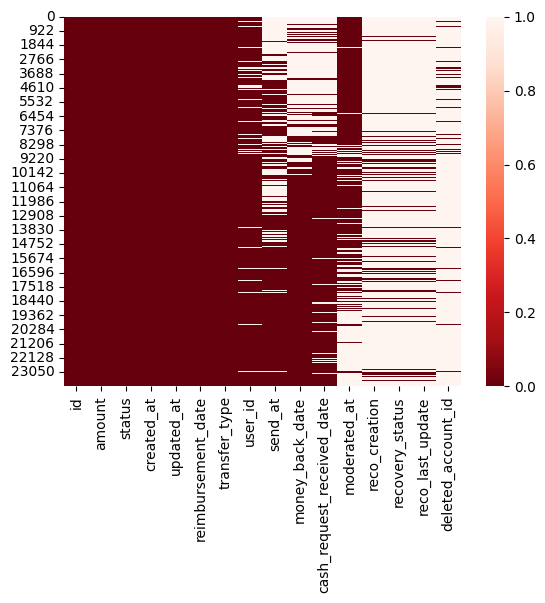

Conclusiones: deleted_account_id y user_id tienen nulos complementarios
Conclusiones: reco* solo están informadas para aquellos registros afectados
Conclusiones: moderated_at está menos poblada a medida que pasa el tiempo
Conclusiones: money_back y raceived están más pobladan a medida que pasa el tiempo


In [367]:
ordered_columns = cash_request.isnull().sum().sort_values().keys()
# Creamos un heatmap con los valores nulos
sns.heatmap(cash_request[ordered_columns].isnull(), annot=False, cmap='Reds_r')
plt.show()

print('Conclusiones: deleted_account_id y user_id tienen nulos complementarios')
print('Conclusiones: reco* solo están informadas para aquellos registros afectados')
print('Conclusiones: moderated_at está menos poblada a medida que pasa el tiempo')
print('Conclusiones: money_back y raceived están más pobladan a medida que pasa el tiempo')

#### 2.0.1 llenar valores faltantes 

Para llenar valores faltantes en conjuntos de datos tanto cuantitativos como cualitativos,existen varias estrategias comunes que los científicos de datos suelen emplear:
- Valores cuantitativos:
    1. **Imputación por la media o mediana**: Los valores faltantes se reemplazan por la media o mediana de la variable en cuestión.Esta estrategia es simple y efectiva cuando los datos siguen una distribución normal y los valores faltantes son aleatorios.
    2. **Imputación por regresión**: Se utiliza un modelo de regresión para predecir los valores faltantes en función de otras variables del conjunto de datos.Esta técnica es útil cuando existe una correlación significativa entre la variable con valores faltantes y otras variables del conjunto de datos.
    3. **Métodos basados en vecinos más cercanos (KNN)**: Los valores faltantes se im    putan utilizando los valores de las observaciones más similares en función de una métrica de distancia. Esta estrategia es útilcuando las observaciones se pueden agrupar en un espacio métrico.
    4. **Imputación múltiple**: Se generan múltiples imputaciones para los valores faltantes,
    teniendo en cuenta la incertidumbre asociada con la imputación.Esta técnica es útil cuando se desea tener en cuenta la variabilidad en los datos imputados.
- Valores cualitativos:
    1. **Moda o valor más frecuente**: Los valores faltantes se reemplazan por elvalor más común o moda de la variable categórica.Esta estrategia es simple y efectiva cuando hay una categoría dominante en la variable.
    2. **Imputación por regresión logística**: Se utiliza un modelo de regresión logística para predecir la categoría de los valores faltantes en función de otras variables delconjunto de datos.
    3. **Muestreo de valores**: Los valores faltantes se imputan seleccionando aleatoriamente valores observados de la misma variable categórica.
    4. **Imputación basada en modelos de clasificación**: Se utilizan modelos de clasificación (como árboles de decisión o métodos de clasificación más avanzados) para predecir la categoría de los valores faltantes en función de otras variables predictoras.

In [368]:
# Rellenar valores nulos en 'user_id' usando 'deleted_account_id' (clientes transferidos de cuentas eliminadas)
cash_request.fillna({"user_id": cash_request["deleted_account_id"]}, inplace=True)

# Eliminar la columna 'deleted_account_id' ya que no es necesaria después de la imputación
cash_request.drop(columns=["deleted_account_id"], inplace=True)

# Estandarización de formatos

cash_request['user_id'] = cash_request['user_id'].apply(lambda x: int(x) if x % 1 == 0 else np.nan)

# Convert datetime columns to pandas datetime
datetime_columns = ['created_at', 'updated_at', 'moderated_at', 'reimbursement_date', 'money_back_date', 'send_at', 'reco_creation', 'reco_last_update']
for col in datetime_columns:
    cash_request[col] = pd.to_datetime(cash_request[col], errors='coerce')
    cash_request[col] = cash_request[col].dt.floor('h')
    cash_request[col] = cash_request[col].dt.tz_localize(None)

cash_request.head()


id  amount    status          created_at          updated_at  user_id  \
0     5   100.0  rejected 2019-12-10 19:00:00 2019-12-11 16:00:00      804   
1    70   100.0  rejected 2019-12-10 19:00:00 2019-12-11 14:00:00      231   
2     7   100.0  rejected 2019-12-10 19:00:00 2019-12-11 09:00:00      191   
3    10    99.0  rejected 2019-12-10 19:00:00 2019-12-18 14:00:00      761   
4  1594   100.0  rejected 2020-05-06 09:00:00 2020-05-07 09:00:00     7686   

         moderated_at  reimbursement_date cash_request_received_date  \
0 2019-12-11 16:00:00 2020-01-09 19:00:00                        NaN   
1 2019-12-11 14:00:00 2020-01-09 19:00:00                        NaN   
2 2019-12-11 09:00:00 2020-01-09 19:00:00                        NaN   
3 2019-12-18 14:00:00 2020-01-09 19:00:00                        NaN   
4 2020-05-07 09:00:00                 NaT                        NaN   

  money_back_date transfer_type send_at recovery_status reco_creation  \
0             NaT       regular     NaT             NaN           NaT   
1             NaT       regular     NaT             NaN           NaT   
2             NaT       regular     NaT             NaN           NaT   
3             NaT       regular     NaT             NaN           NaT   
4             NaT       regular     NaT             NaN           NaT   

  reco_last_update  
0              NaT  
1              NaT  
2              NaT  
3              NaT  
4              NaT

3. **Identificación de posibles errores**: Esto implica buscar valores atípicos, anomalías o datos que no tienen sentido dentro delcontexto delconjunto de datos.Los errores pueden manifestarse de diversas formas,como valores extremadamente altos o bajos que no son representativos del resto de los datos, o datos que violan las restricciones lógicas de un dominio específico.

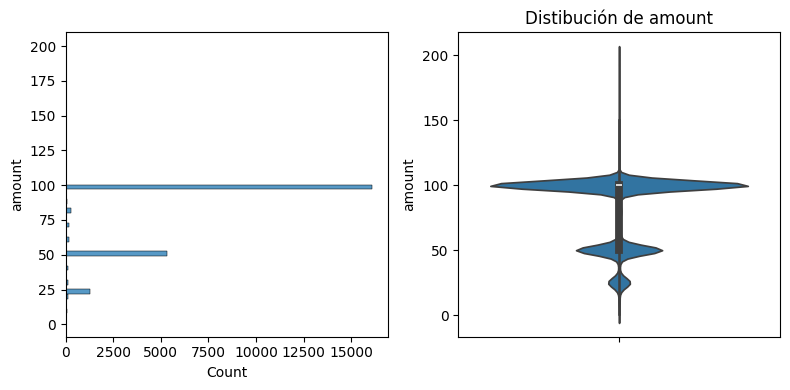

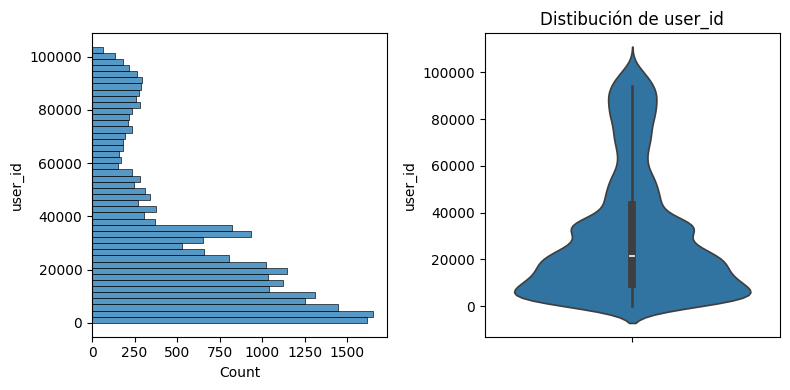

Conclusiones: Existen Amounts de 200, pero nada indica que sean errores


In [369]:
columnas_numericas_cr = cash_request.describe().columns.tolist()

for c in ['amount', 'user_id']:
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    sns.violinplot(y=c, data=cash_request, ax=axs[1])
    sns.histplot(y=c, data=cash_request, ax=axs[0])
    plt.title(f'Distibución de {c}')
    plt.tight_layout()
    plt.show()


print('Conclusiones: Existen Amounts de 200, pero nada indica que sean errores')

status
money_back               16397
rejected                  6568
direct_debit_rejected      831
active                      59
transaction_declined        48
direct_debit_sent           34
canceled                    33
Name: count, dtype: int64

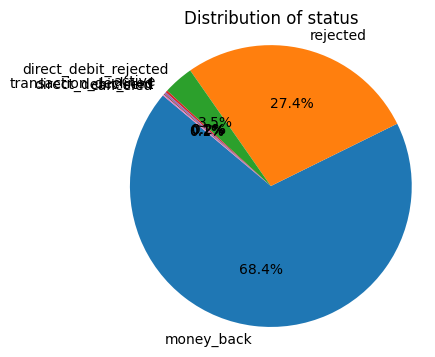

recovery_status
completed               2468
pending                  845
pending_direct_debit      16
cancelled                  1
Name: count, dtype: int64

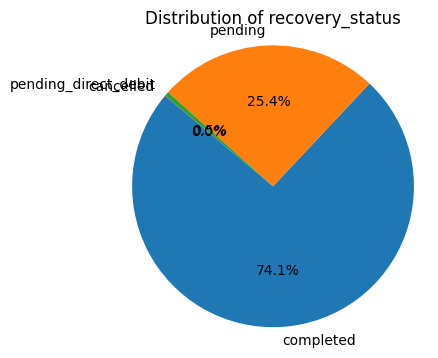

transfer_type
instant    13882
regular    10088
Name: count, dtype: int64

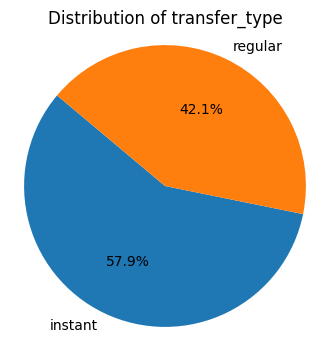

In [370]:
for c in ['status','recovery_status', 'transfer_type']:
    # Create a pie plot using Seaborn for the 'status' column
    reason_counts = cash_request[c].value_counts()
    display(reason_counts)
    plt.figure(figsize=(4, 4))
    plt.title(f'Distribution of {c}')
    plt.pie(reason_counts, labels=reason_counts.index, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()


4. **Evaluación de la consistencia y precisión**: Se refiere a verificar si los datos están en concordancia con las expectativas y reglas del dominio del problema.Esto implica comprobar la coherencia de los datos con respecto a las reglas de negocio y los estándares establecidos.

In [371]:
# Buscar inconsistencias en las fechas

# datetime_columns = ['created_at', 'updated_at', 'moderated_at', 'reimbursement_date', 'money_back_date', 'send_at', 'reco_creation', 'reco_last_update']
cash_request[cash_request['created_at'] > cash_request['updated_at']][['id']].count()
cash_request[cash_request['reimbursement_date'] > cash_request['money_back_date']][['id']].count()

id    211
dtype: int64

### 3.2 Resumen del Análisis Exploratorio de Datos (AED)

El análisis exploratorio de datos (AED) es la brújula que nos guía a través del vasto territorio de nuestros conjuntos de datos.Nos sumerge en la riqueza de la información,revelando patrones,
tendencias y anomalías que pueden pasar desapercibidas a simple vista.Desde la distribución de calificaciones hasta la correlación entre variables,el AED nos proporciona una comprensión profunda de nuestros datos y nos ayuda a formular hipótesis valiosas para análisis posteriores.

#### 3.2.2 Componentes del AED:

1. **Exploración de Datos Univariable**: Análisis de una variable a la vez para comprender su distribución y estadísticas descriptivas.Este enfoque nos permite entender la naturaleza de cada variable y cómo se distribuyen en el conjunto de datos.
2. **Exploración de Datos Bivariable**: Análisis de la relación entre dos variables para identificar posibles asociaciones o correlaciones.Este análisis nos ayuda a comprender las interacciones entre diferentes variables y su impacto en los resultados.
3. **Identificación de Valores Atípicos**: Detección de puntos que se desvían significativamente de la tendencia general de los datos.La identificación de valores atípicos nos permite comprender mejor la distribución de los datos y evaluar su influencia en nuestros análisis.

### 3.3 Insights de Calidad de Datos 

La calidad de los datos es la piedra angular de cualquier análisis significativo.Los datos incompletos,incorrectos o inconsistentes pueden socavar la validez de nuestros resultados y conducir a conclusiones erróneas.Por lo tanto, es crucial realizar una evaluación rigurosa de la calidad de los datos y tomar medidas para abordar cualquier problema identificado.

#### 3.3.2 Estrategias de Mejora de Calidad de Datos:

1. **Limpieza de Datos**: Identificación y corrección de errores, valores atípicos y datos faltantes.
La limpieza de datos es un proceso esencialpara garantizar la integridad y la precisión de nuestros análisis.
2. **Validación de Datos**: Verificación de la precisión y consistencia de los datos mediante técnicas como la validación cruzada.La validación de datos nos ayuda a confirmar la calidad de nuestros datos y a identificar posibles problemas.
3. **Actualización Regular**: Mantenimiento constante de la integridad de los datos mediante actualizaciones periódicas y revisión continua.La actualización regular de los datos garantiza que estén actualizados y reflejen con precisión la realidad en curso.

### 3.4 Resultados del Análisis de Cohortes 

El análisis de cohortes es una herramienta poderosa para comprender cómo se comportan grupos de individuos a lo largo del tiempo.Al dividir a los usuarios en cohortes basadas en ciertos criterios
(por ejemplo, fecha de inscripción), podemos rastrear su comportamiento y evaluar el impacto de diferentes factores en su experiencia.

#### 3.4.2 Beneficios del Análisis de Cohortes:

1. **Identificación de Tendencias a Largo Plazo**: Permite observar cómo cambian los comportamientos a lo largo del tiempo.El análisis de cohortes nos proporciona una visión a largo plazo de la evolución del comportamiento de los usuarios.
2. **Comparación entre Grupos Homogéneos**: Facilita la comparación de diferentes cohortes con características similares.Esto nos ayuda a comprender mejor las diferencias en elcomportamiento de los usuarios y a identificar áreas de mejora.
3. **Evaluación del Impacto de Intervenciones**: Ayuda a evaluar el efecto de cambios o intervenciones en la experiencia delusuario. El análisis de cohortes nos permite medir el impacto de nuestras acciones y ajustar nuestras estrategias en consecuencia.


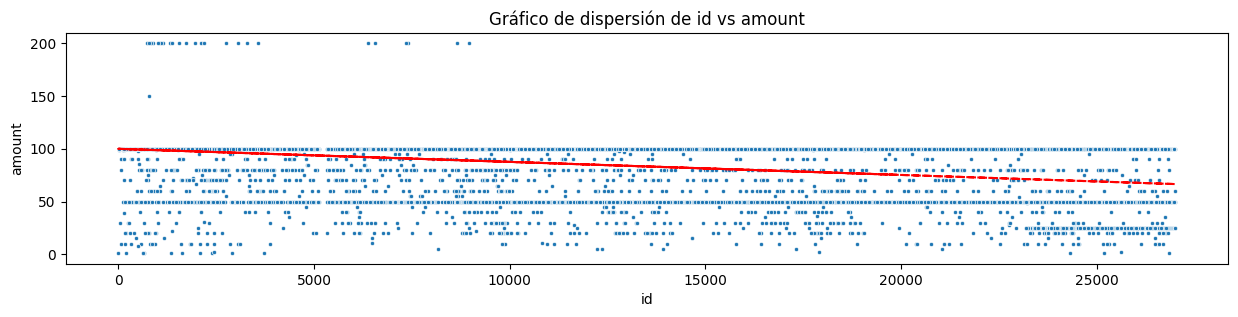

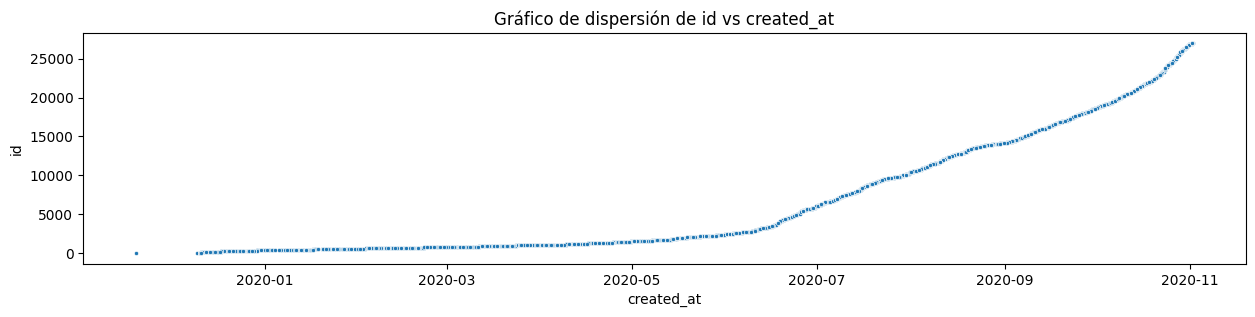

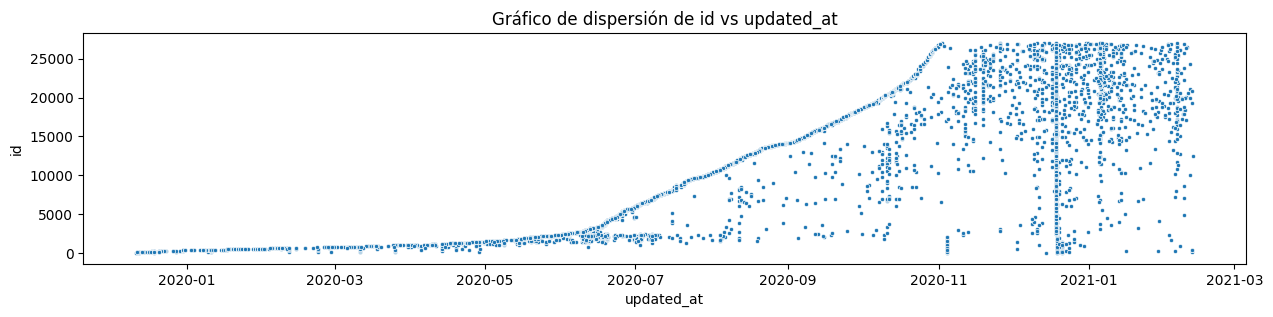

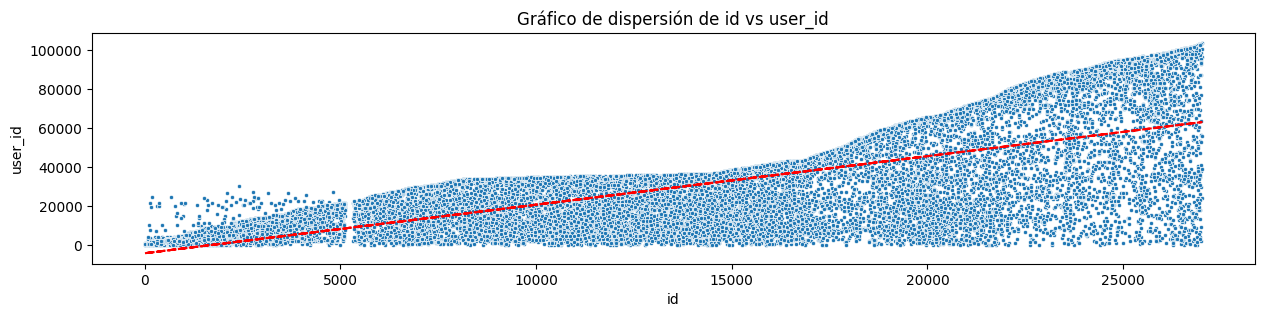

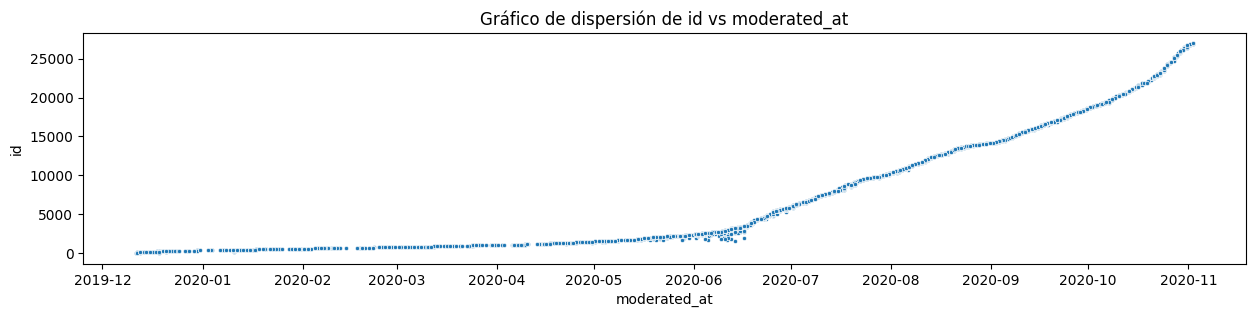

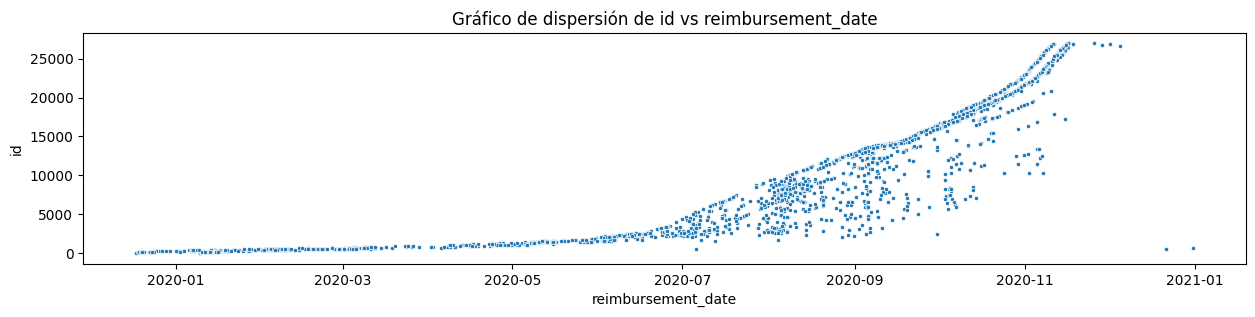

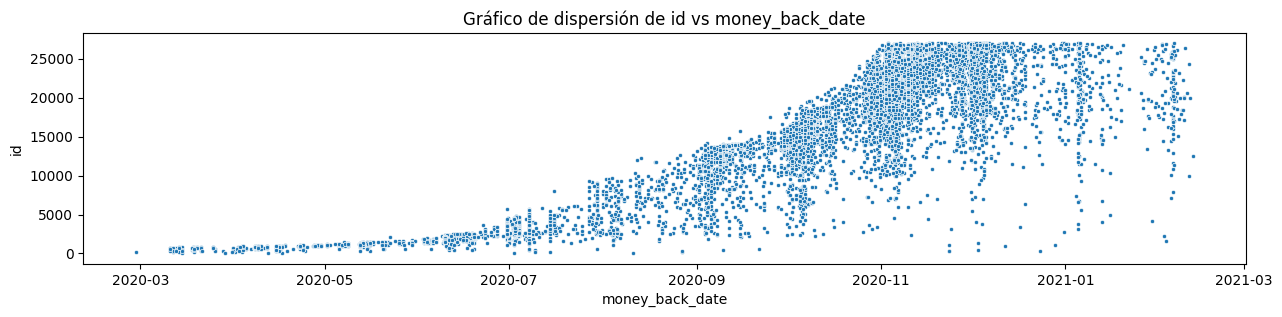

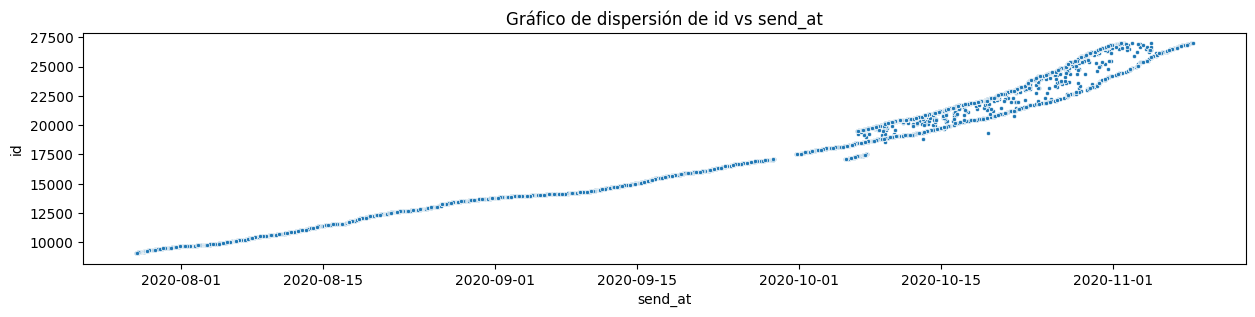

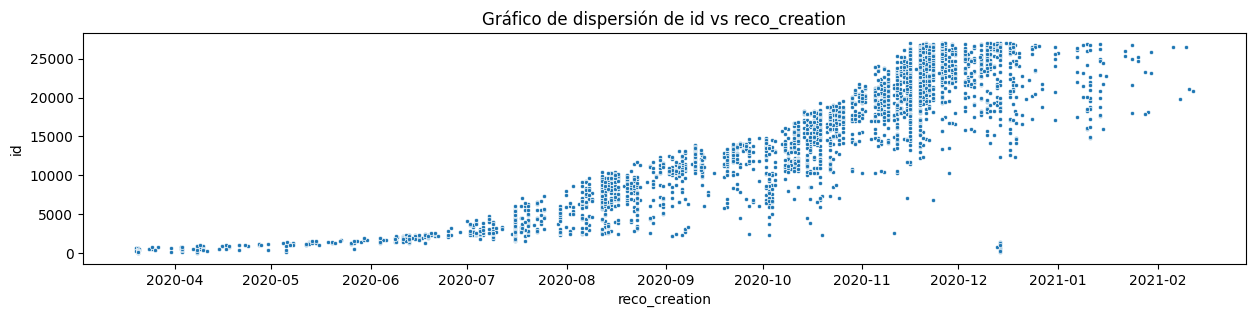

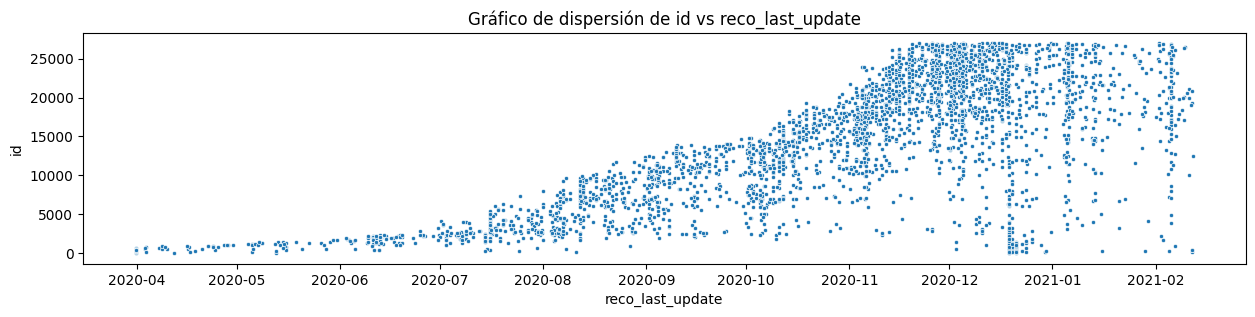

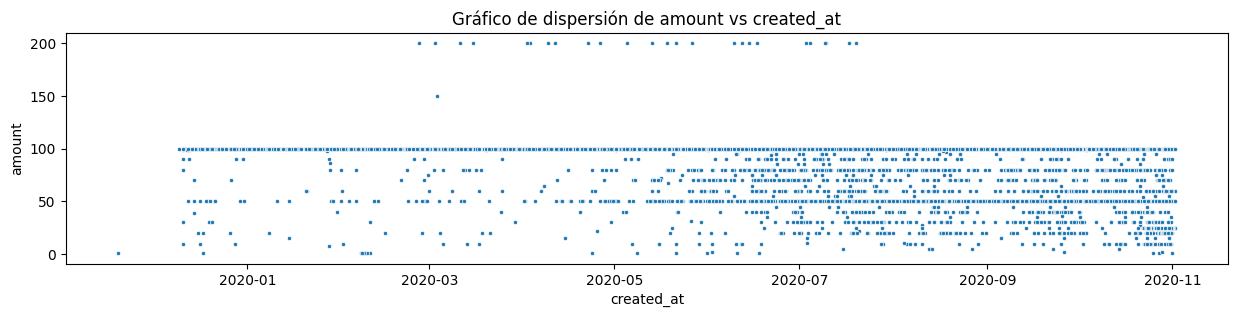

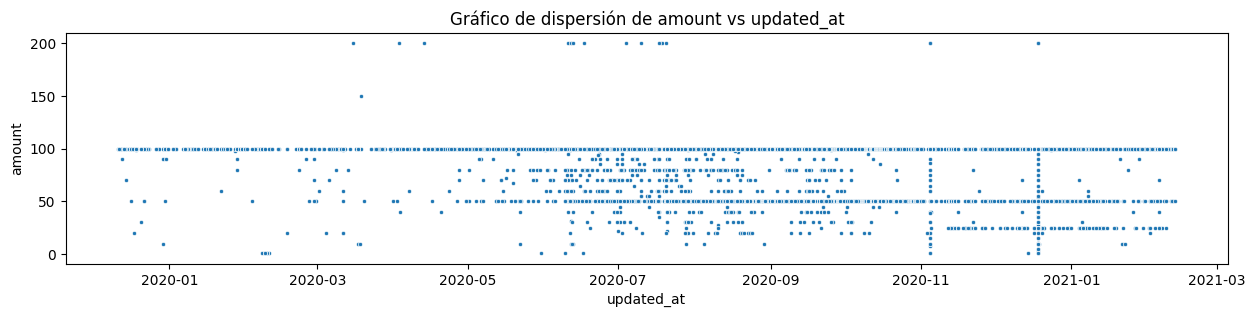

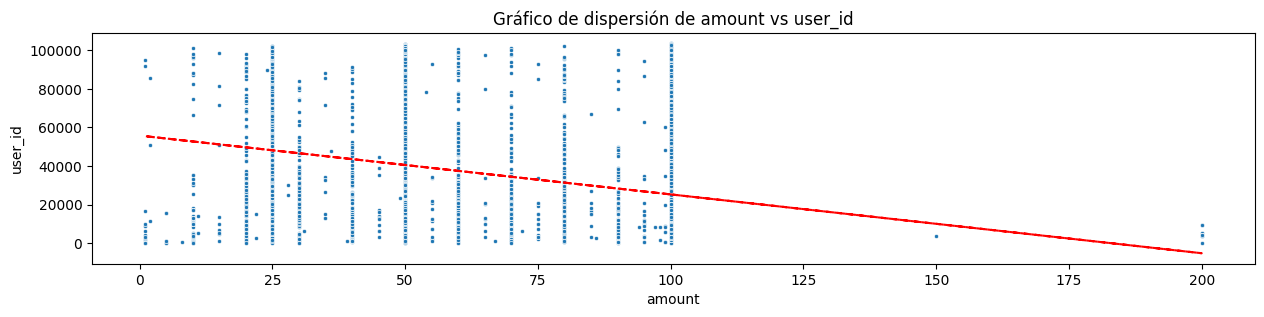

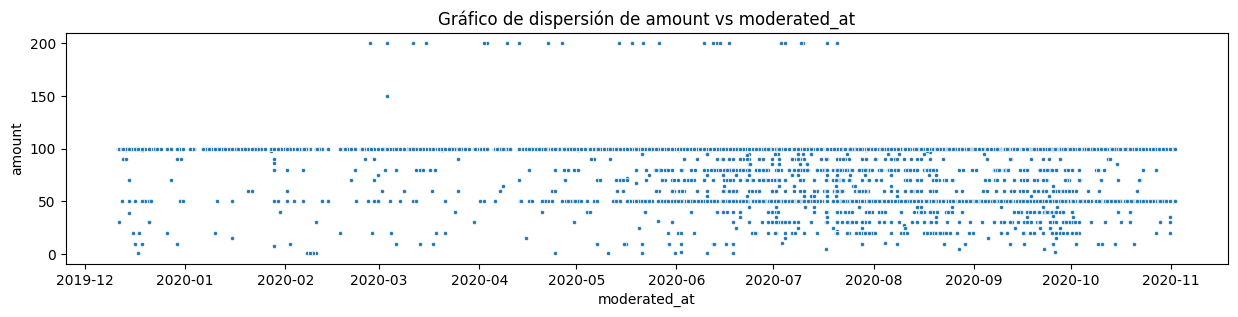

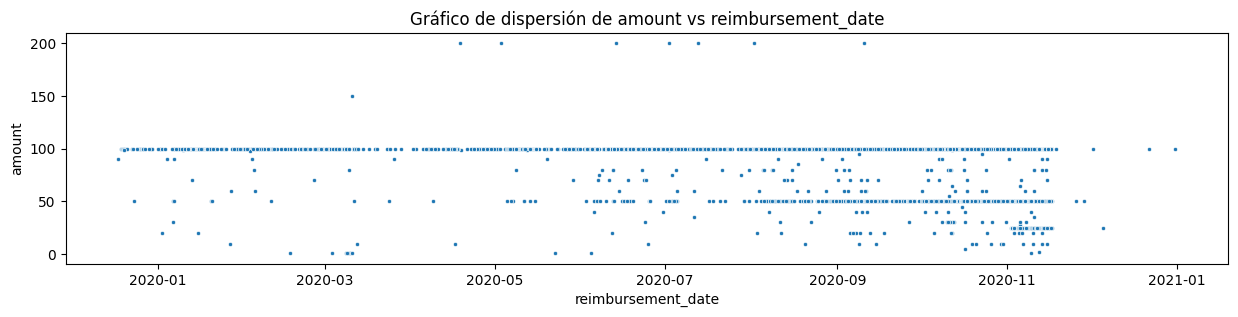

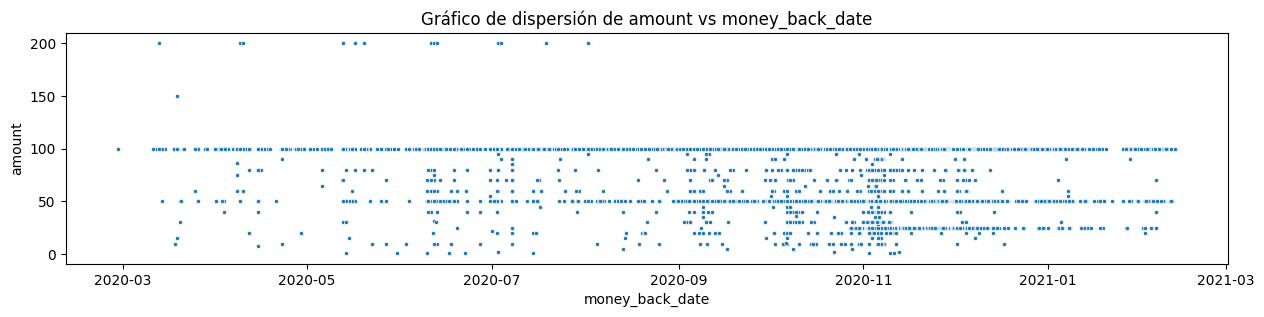

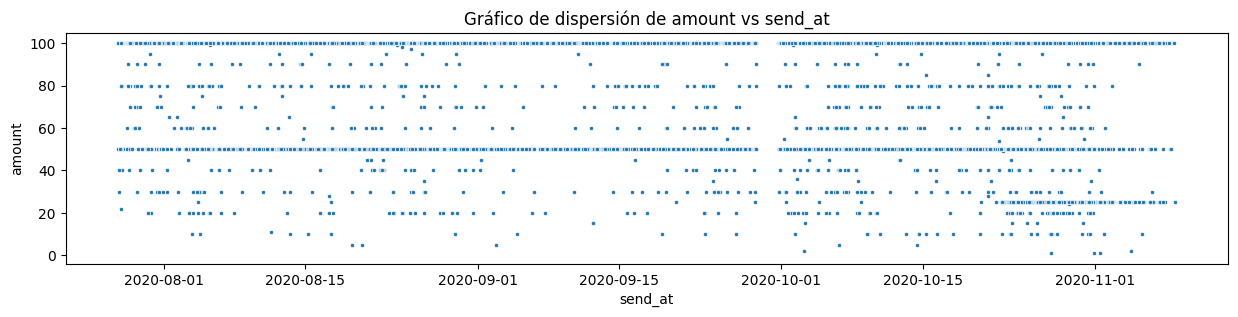

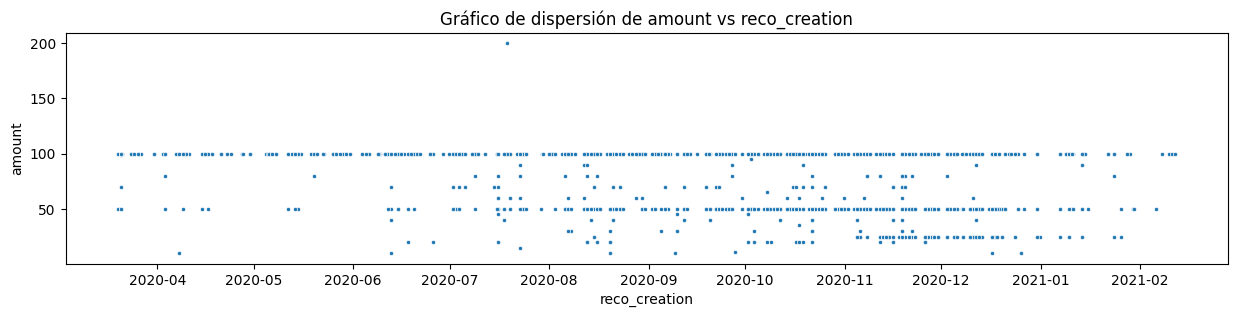

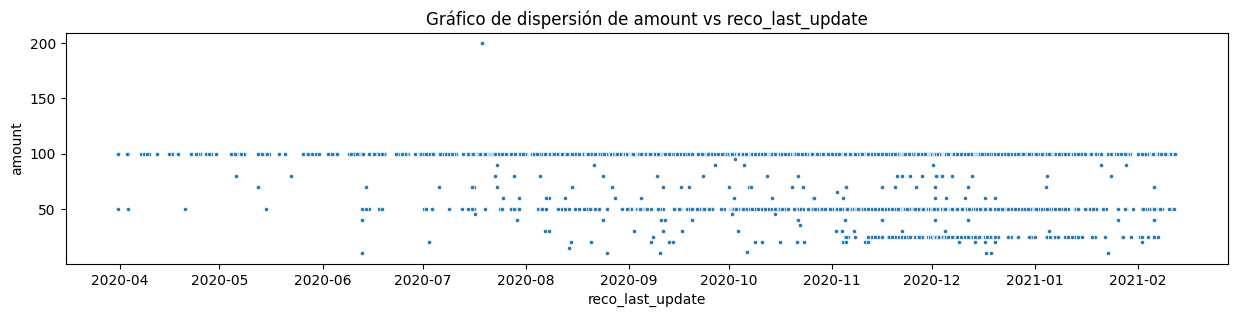

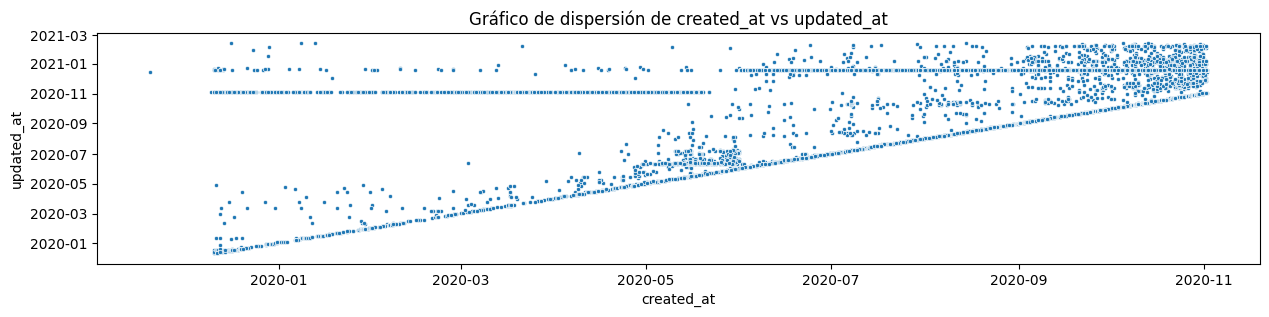

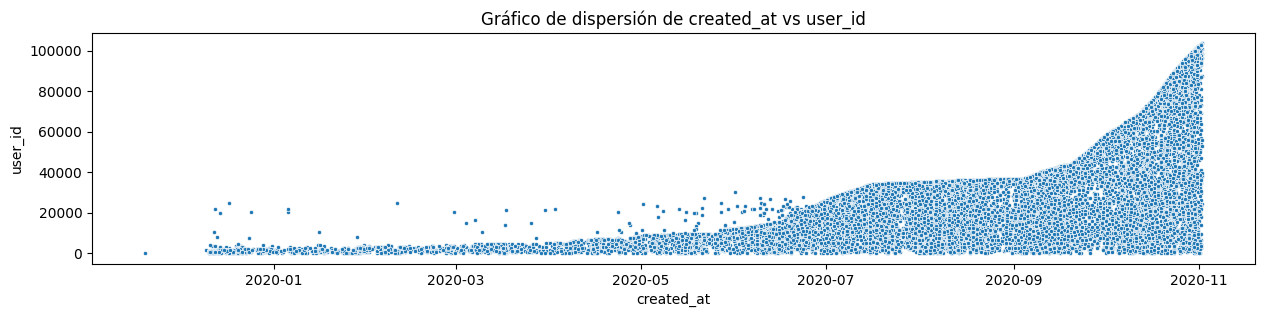

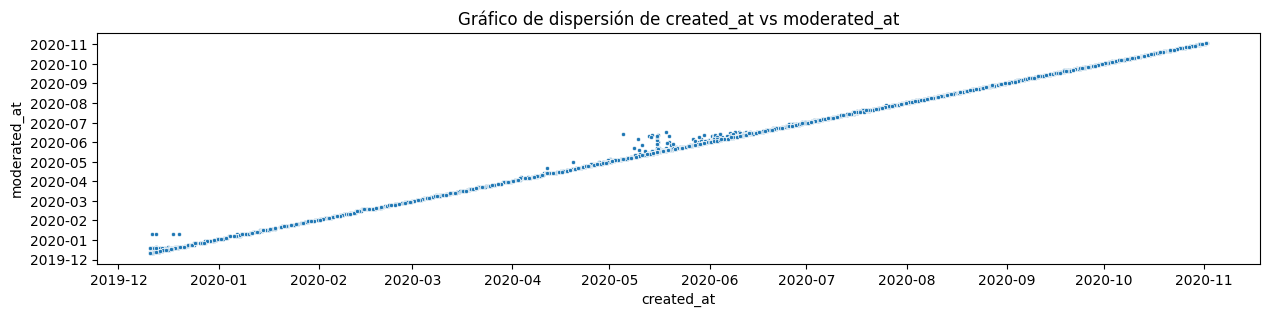

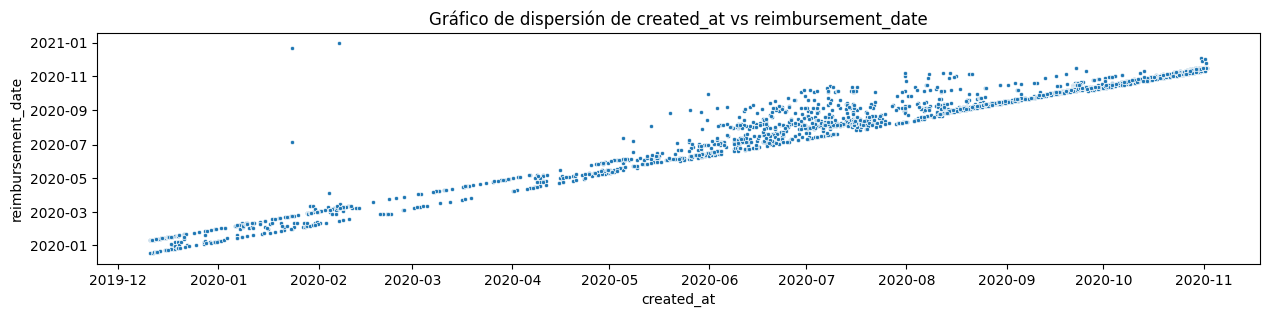

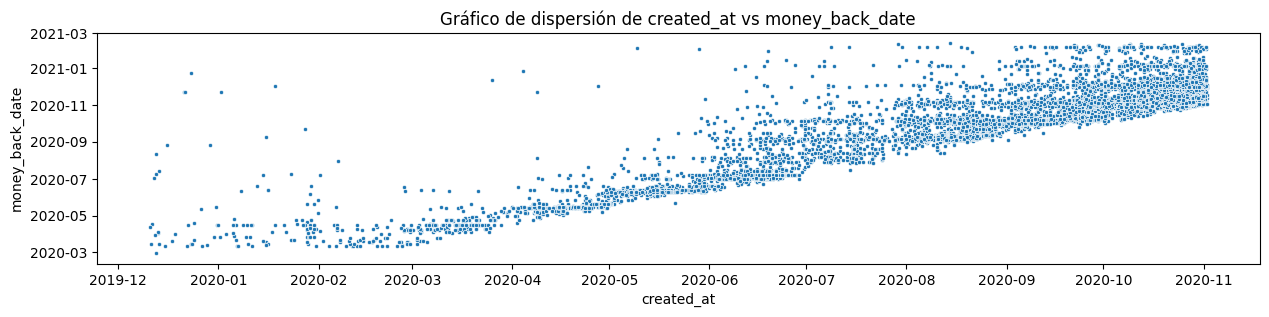

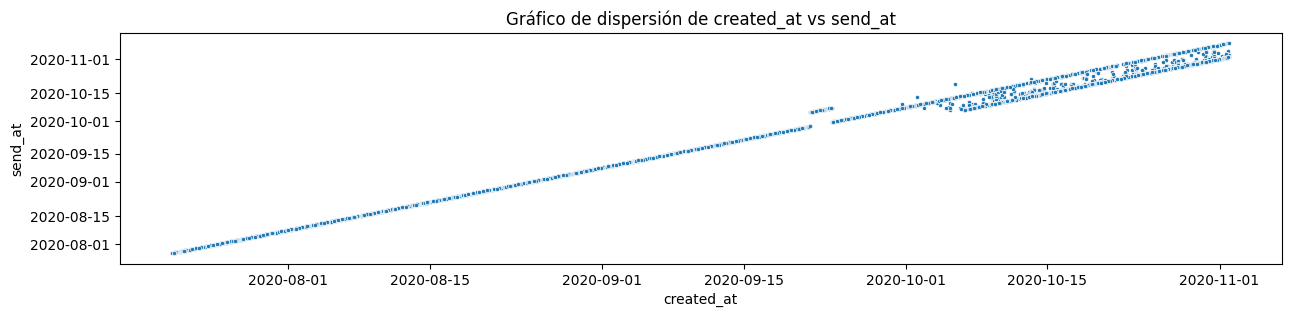

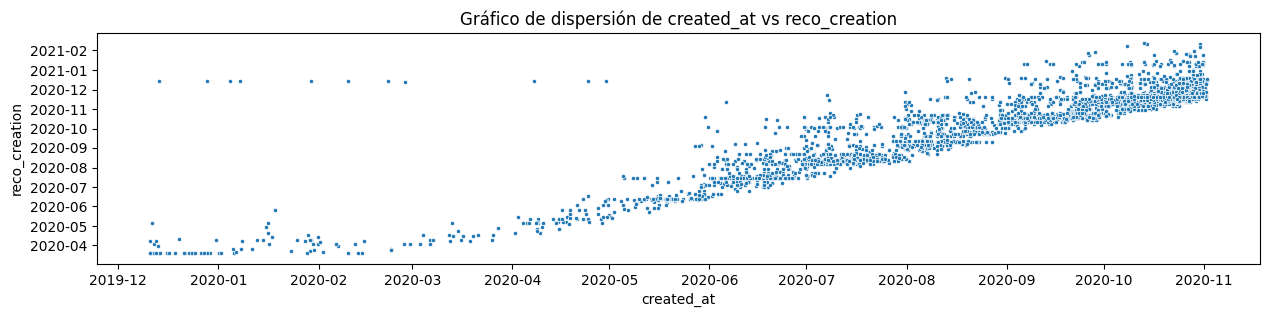

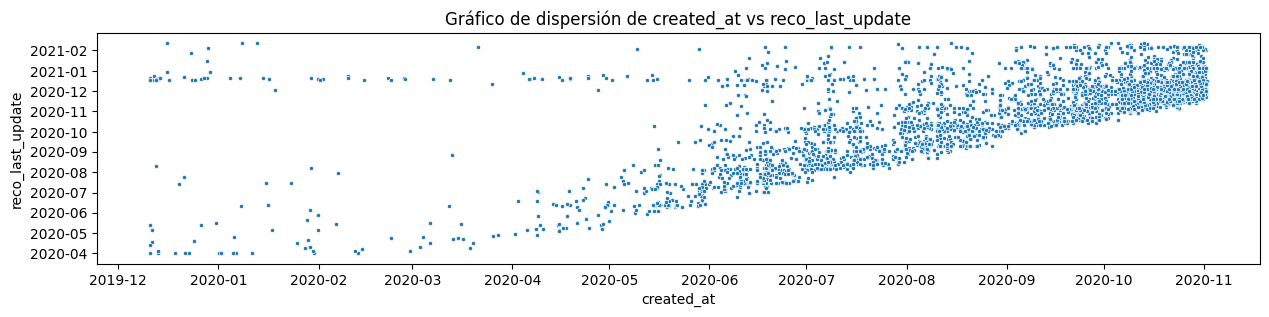

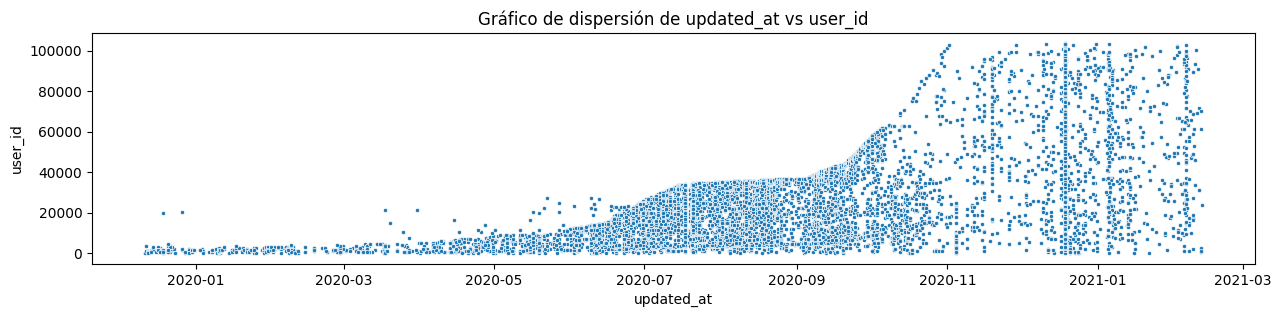

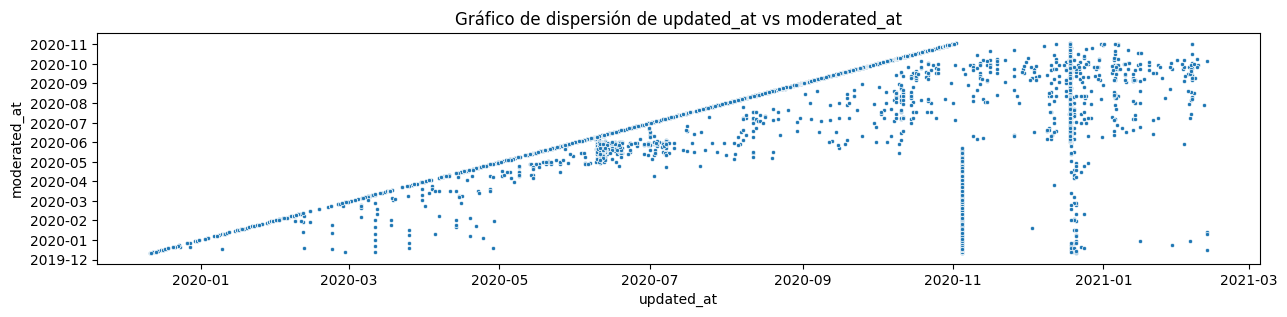

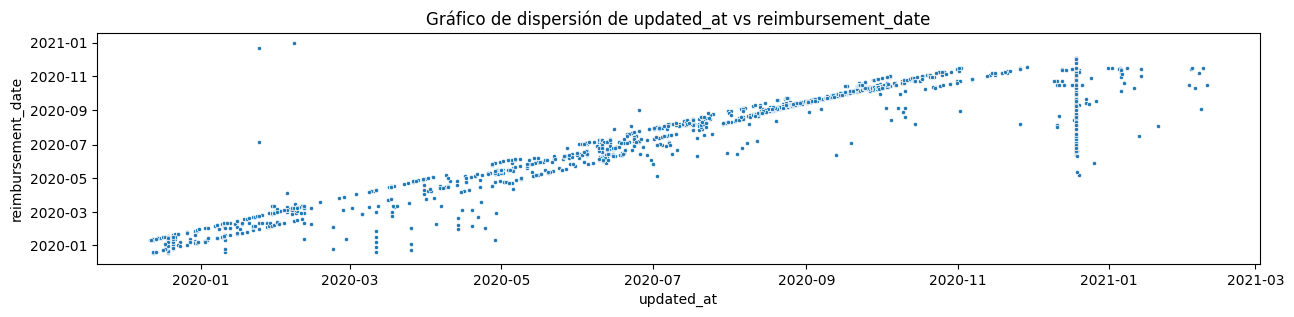

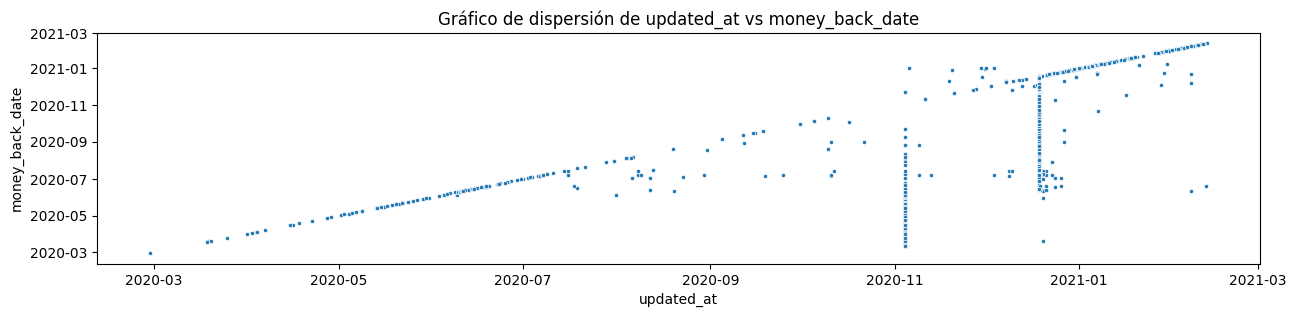

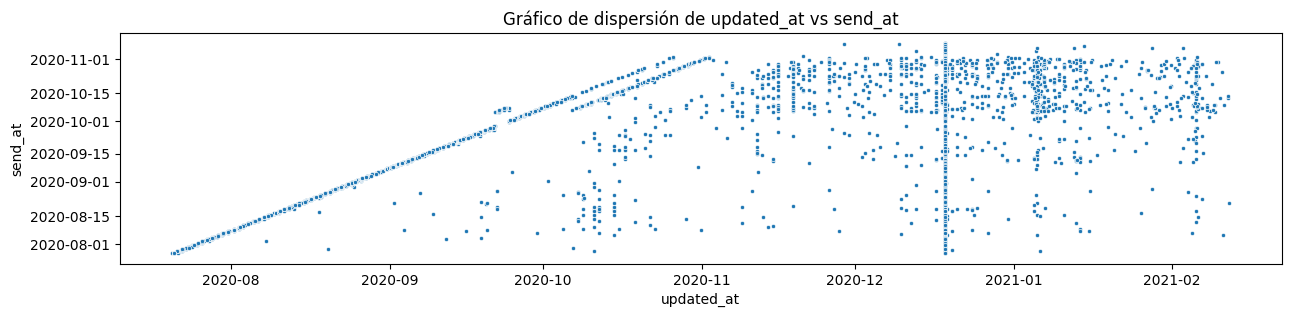

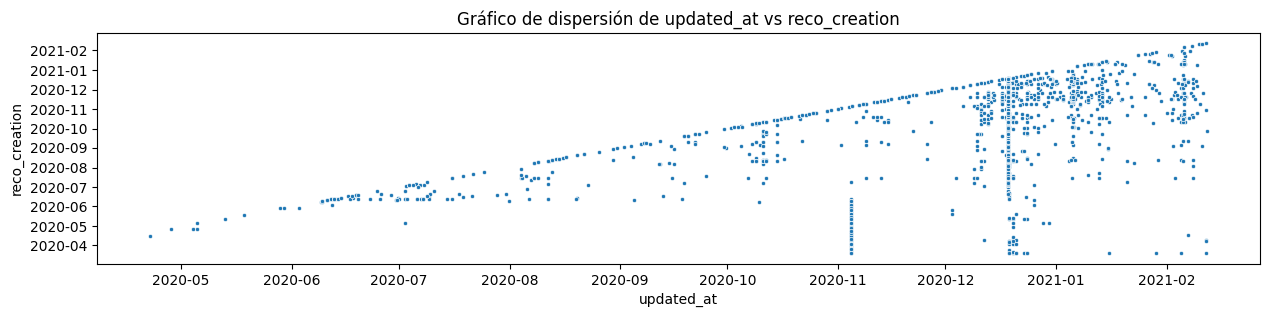

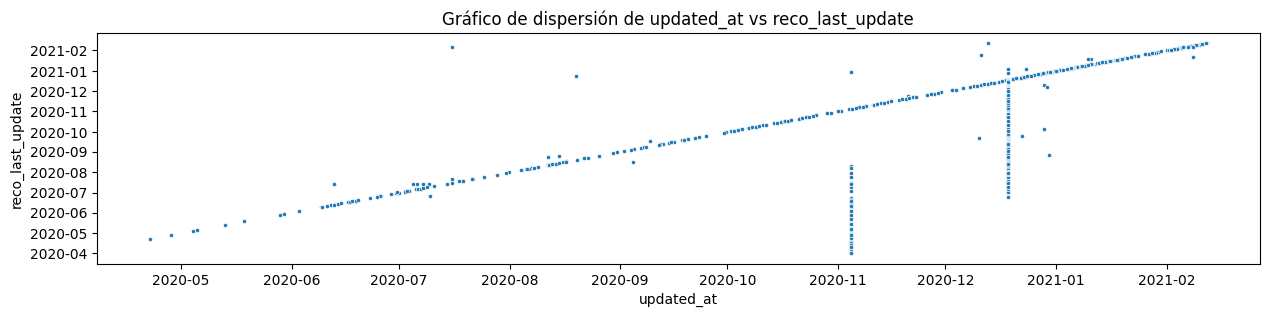

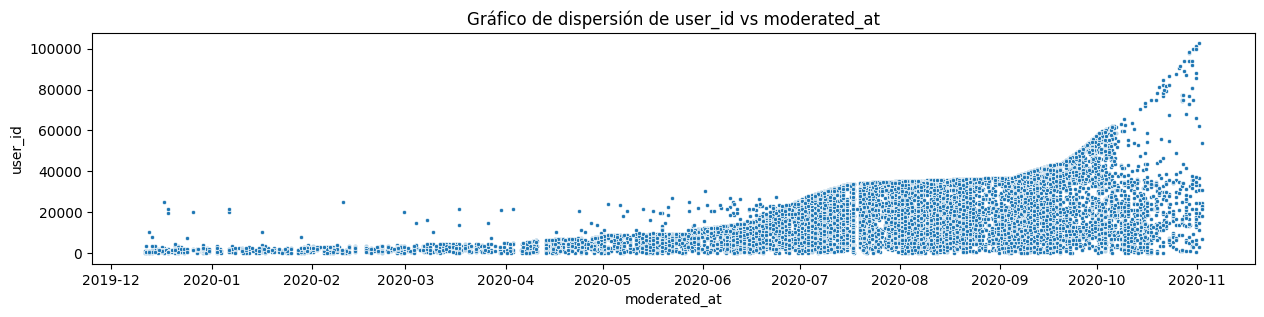

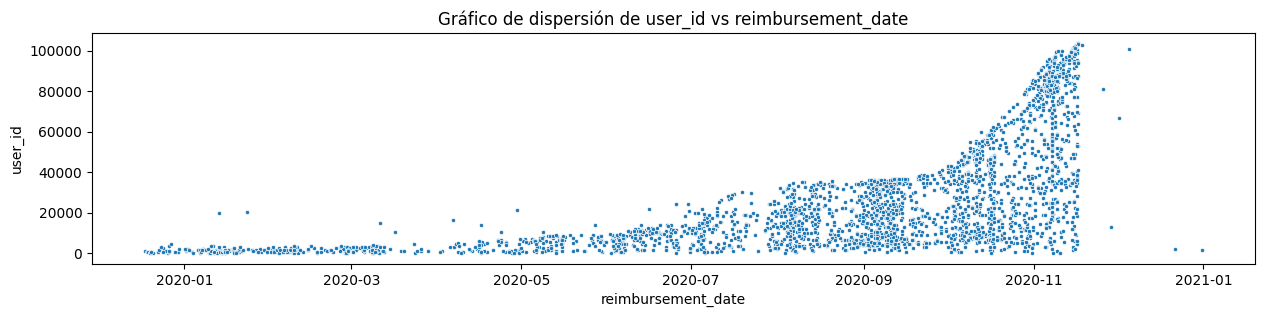

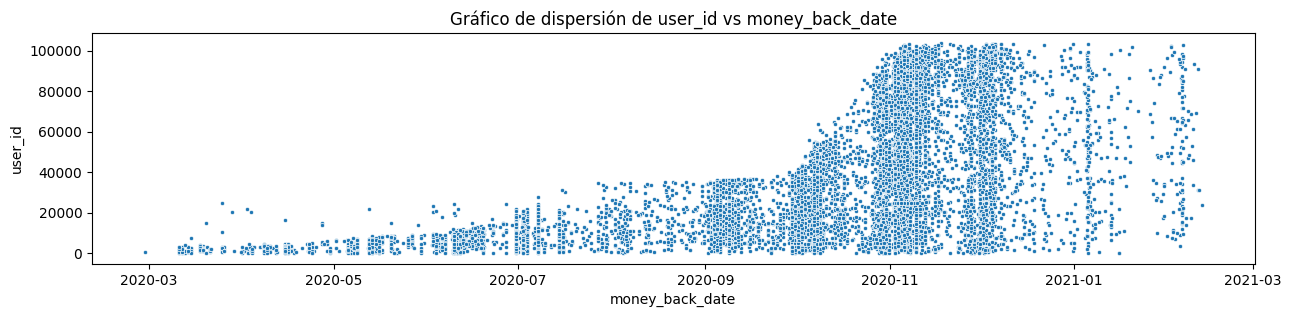

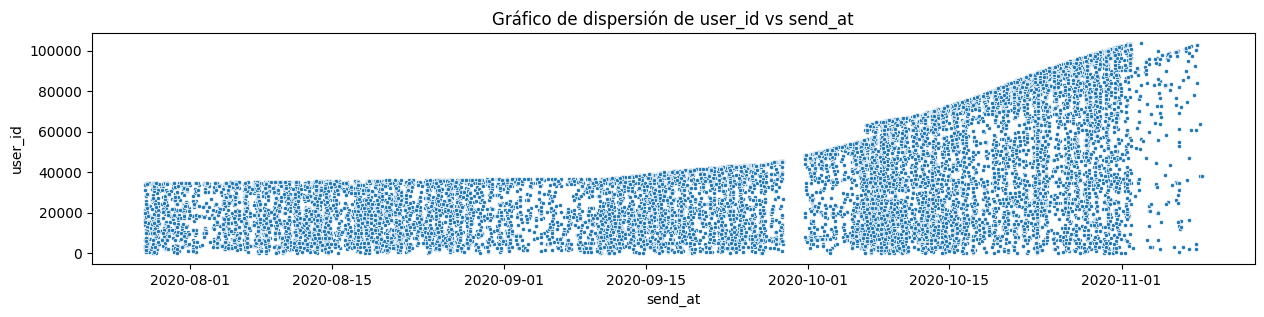

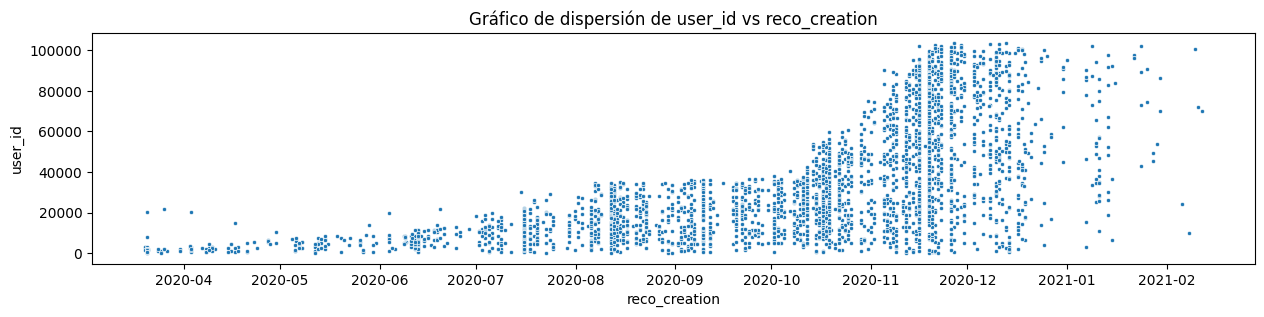

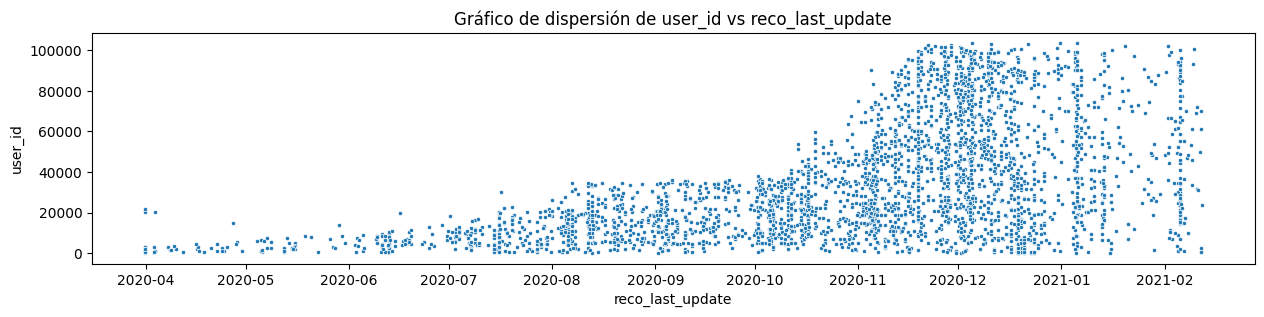

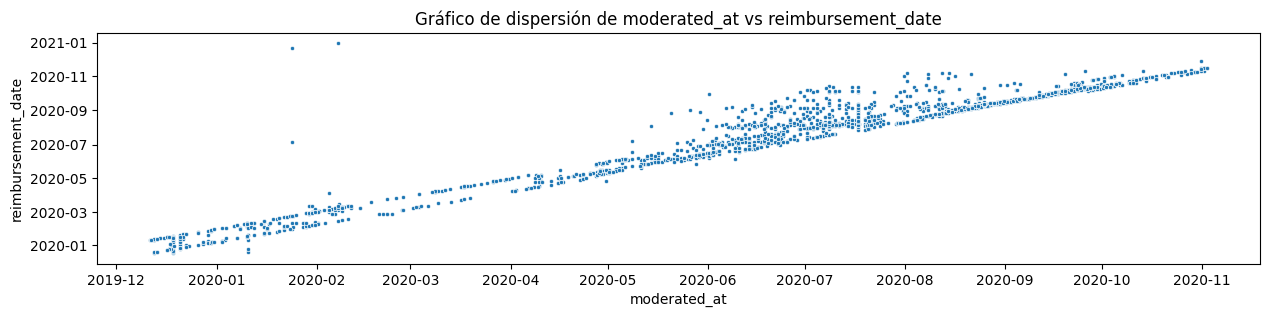

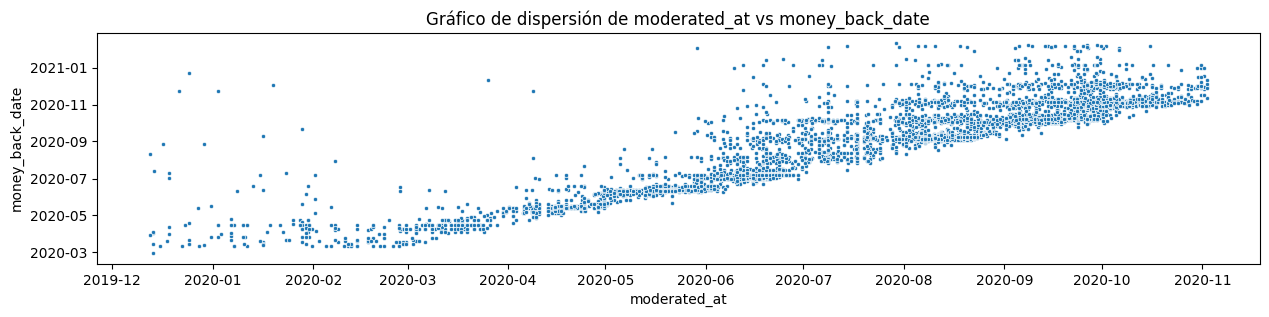

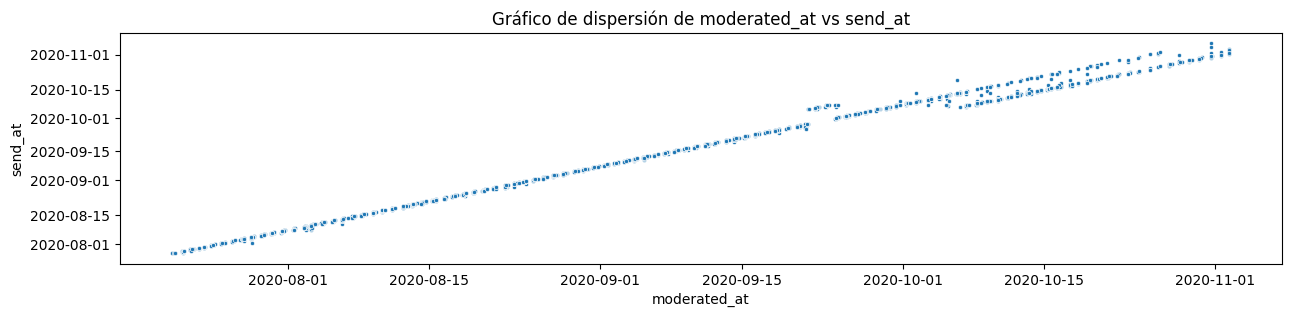

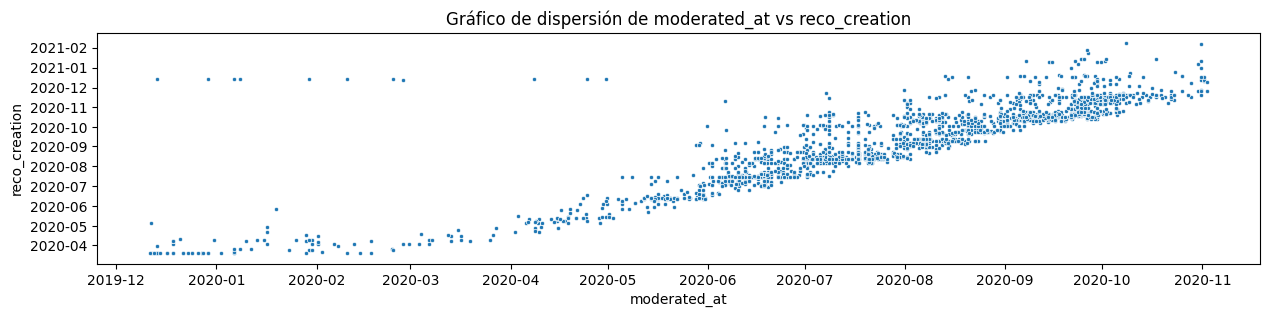

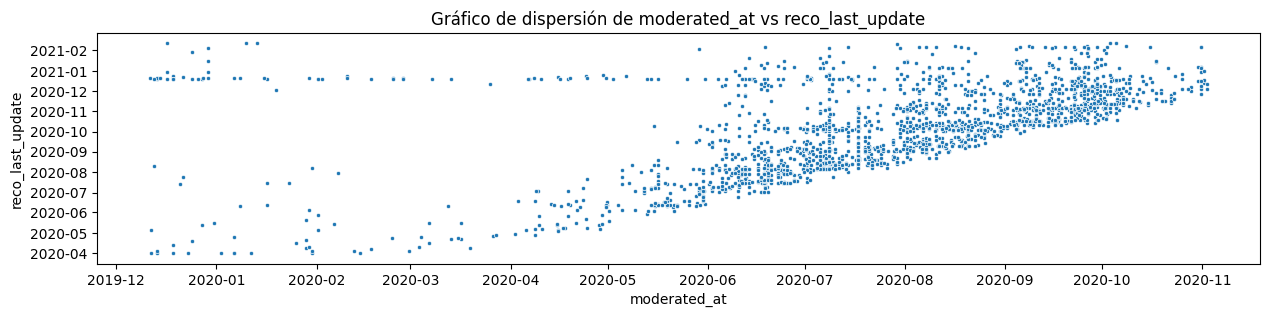

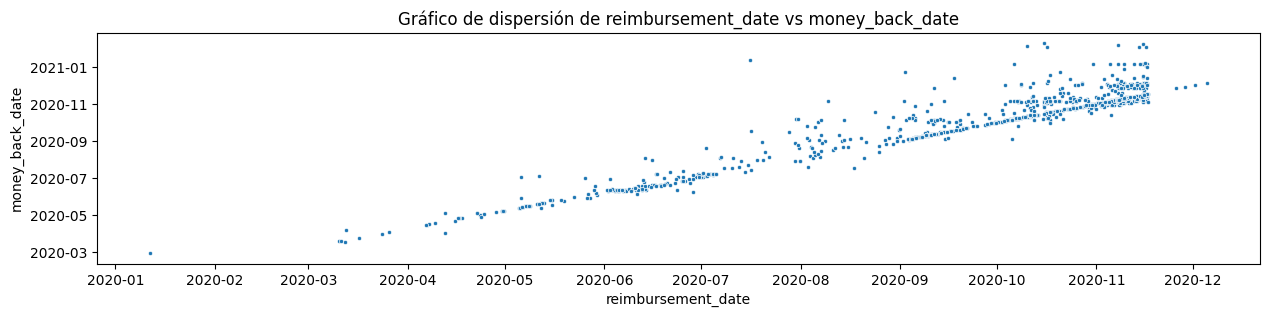

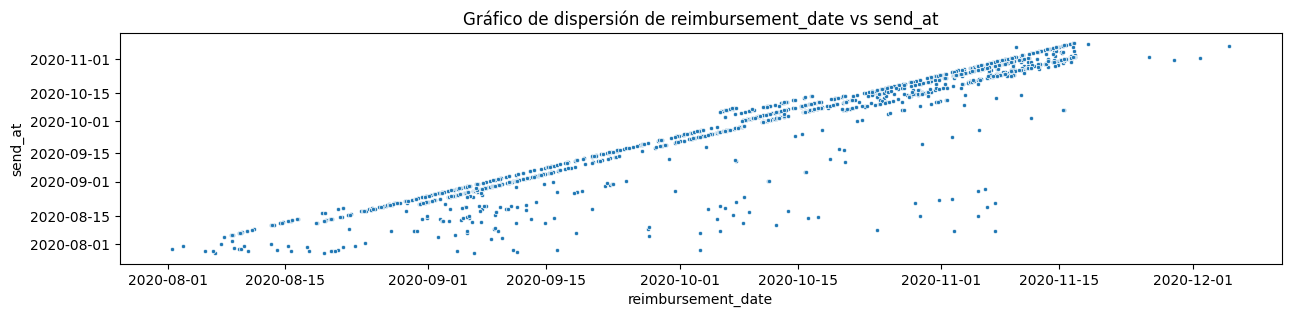

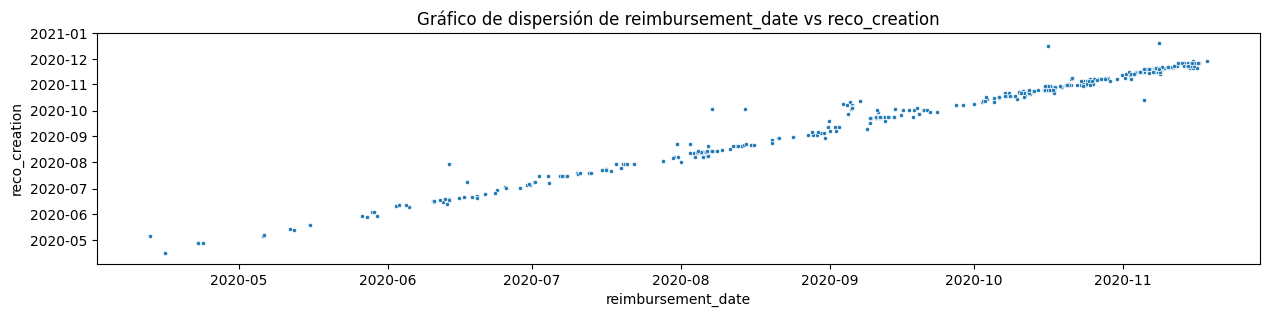

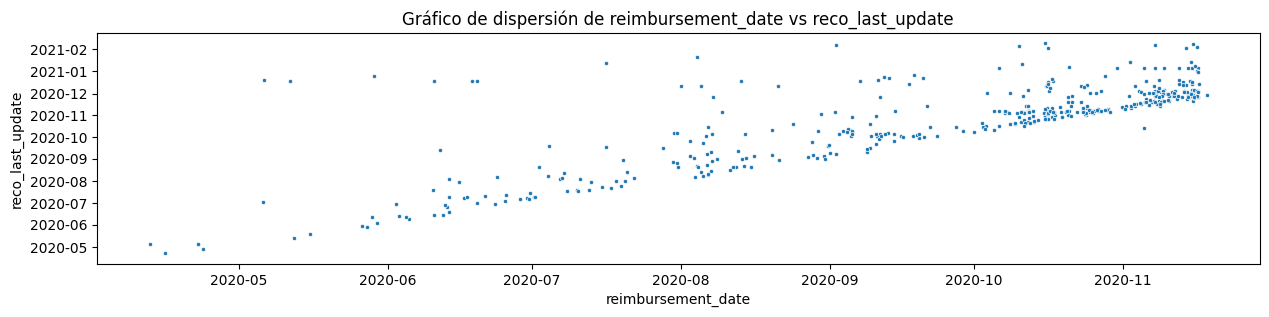

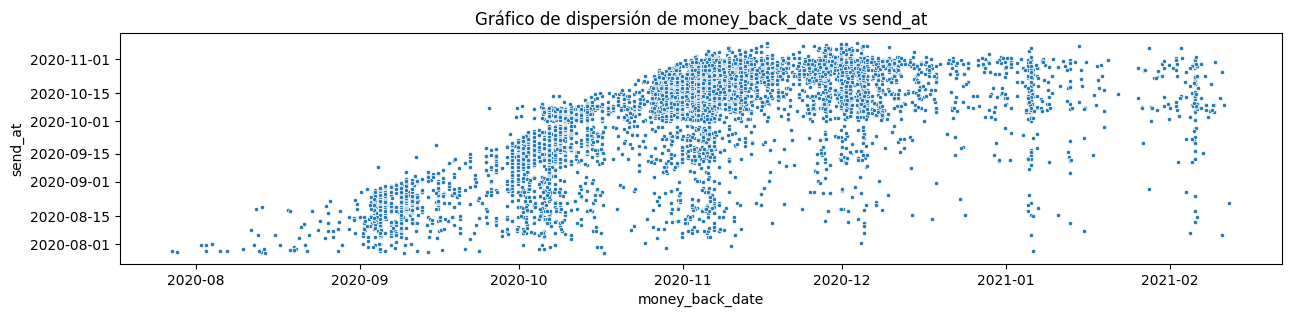

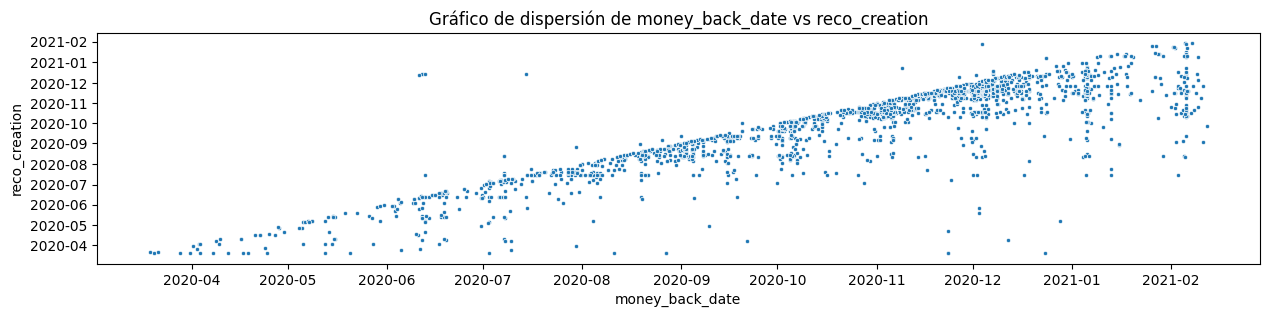

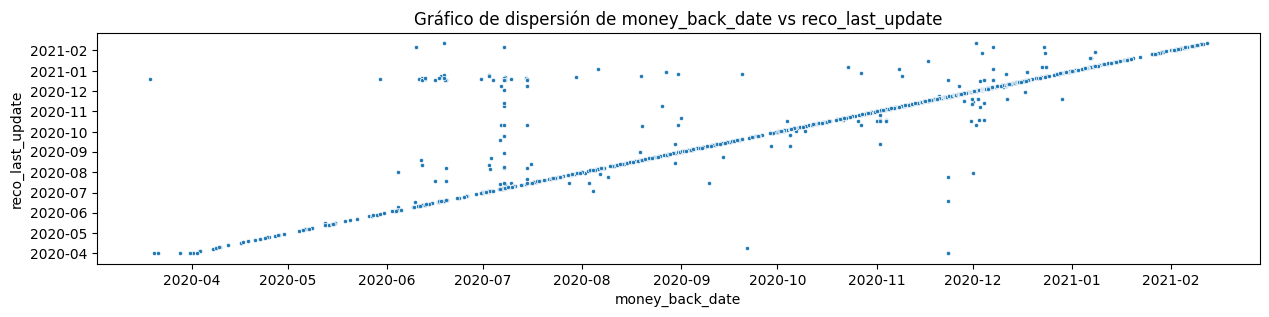

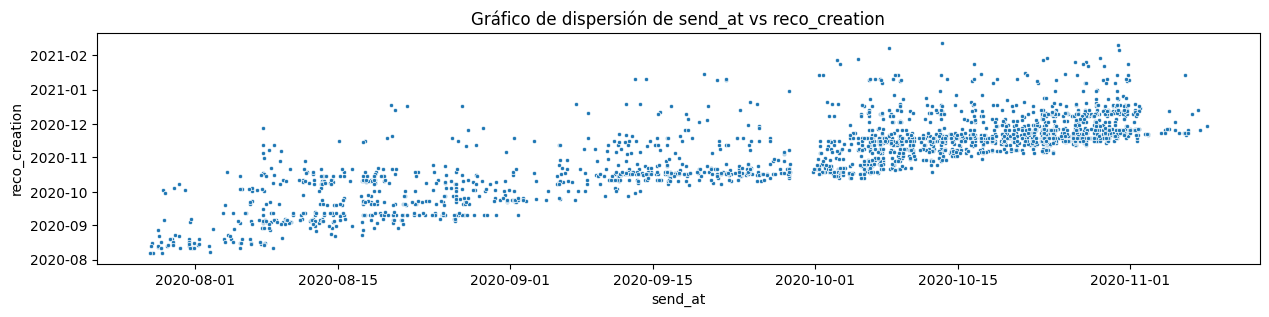

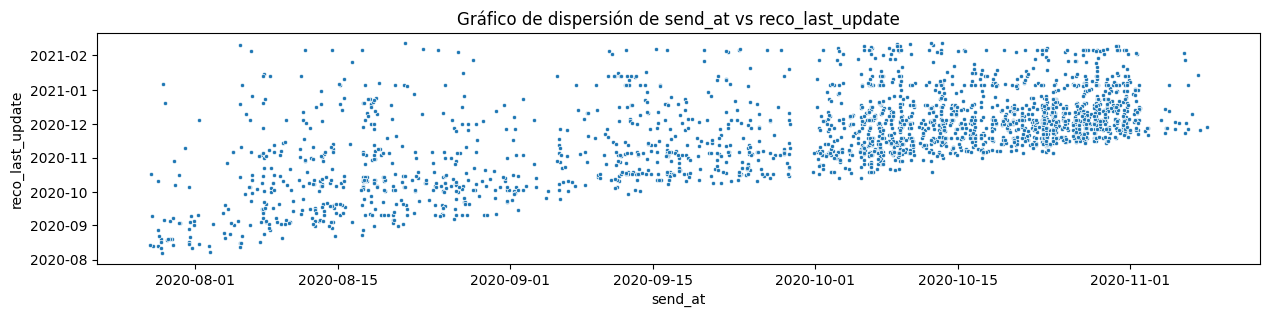

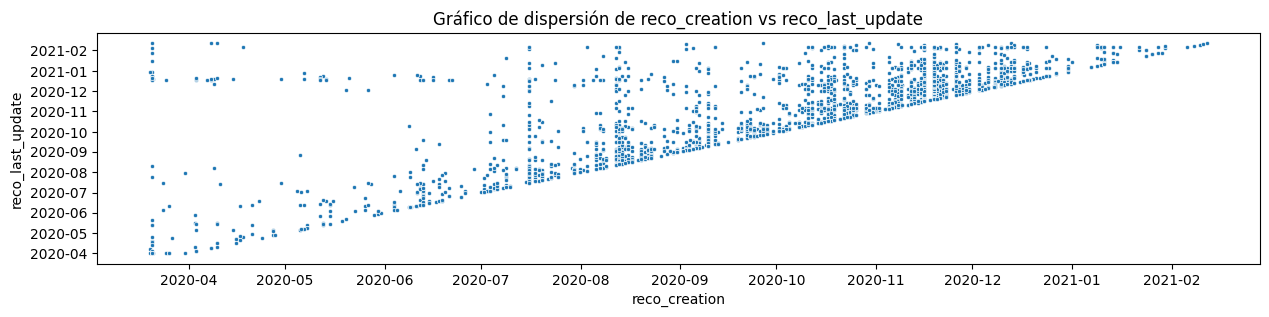

In [455]:
# Genera gráficos de dispersión para todas las combinaciones de columnas numéricas

columnas_numericas_cash_request=cash_request.describe().columns.tolist()

for c1, c2 in itertools.combinations(columnas_numericas_cash_request, 2):
    plt.figure(figsize=(15, 3))

    plt.title(f'Gráfico de dispersión de {c1} vs {c2}')
    if cash_request[c1].dtype.kind != 'M' and cash_request[c2].dtype.kind == 'M':
        t = c1
        c1 = c2
        c2 = t
    sns.scatterplot(data=cash_request, x=c1, y=c2, marker='.')
    if cash_request[c1].dtype.kind != 'M' and cash_request[c2].dtype.kind != 'M':
        z = np.polyfit(cash_request[c1], cash_request[c2], 1)
        p = np.poly1d(z)
        plt.plot(cash_request[c1],p(cash_request[c1]),"r--")

    plt.show()



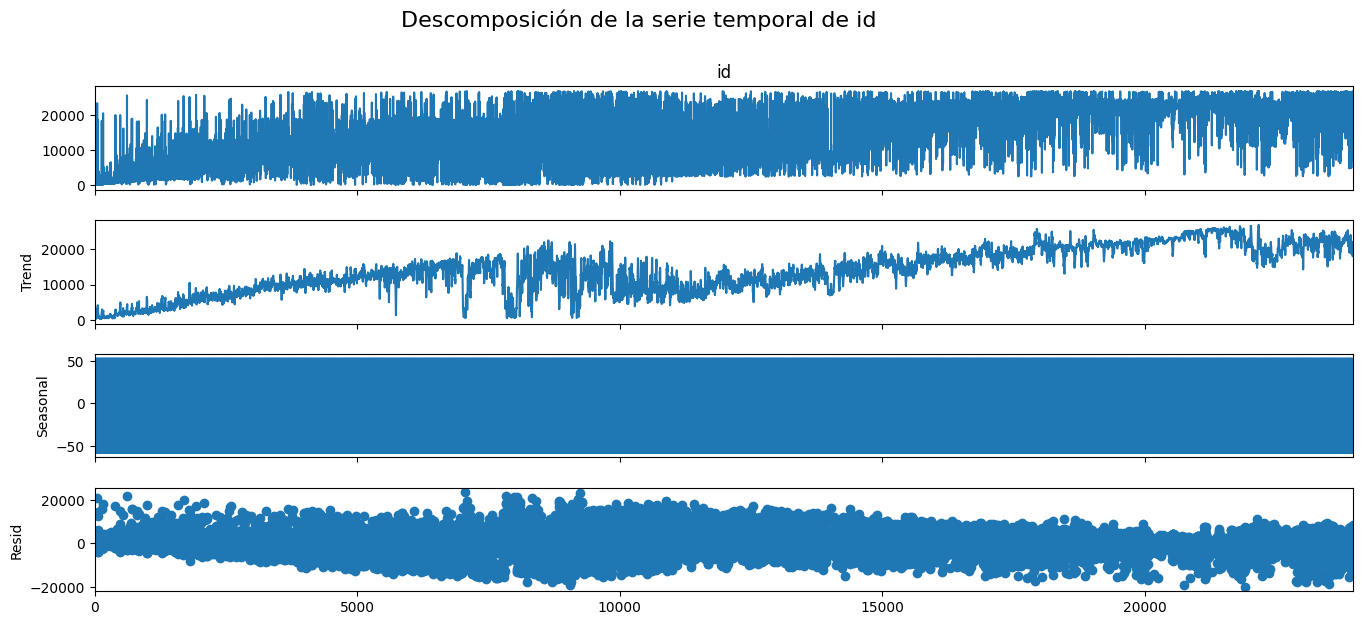

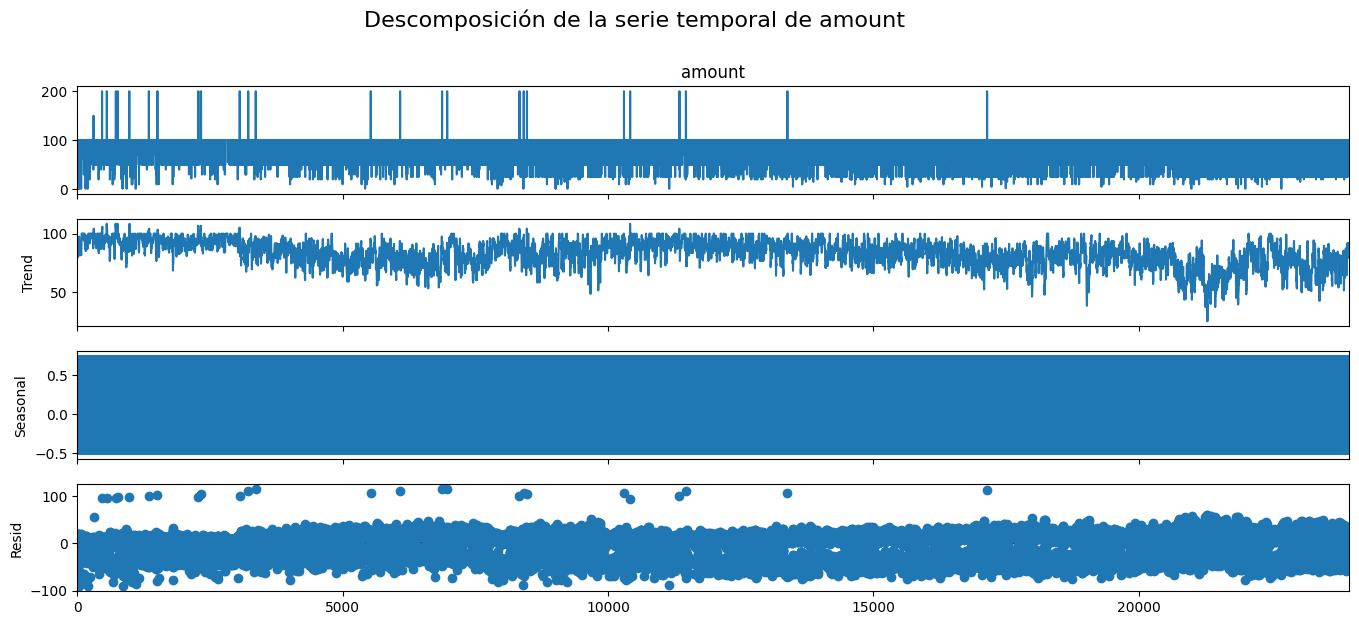

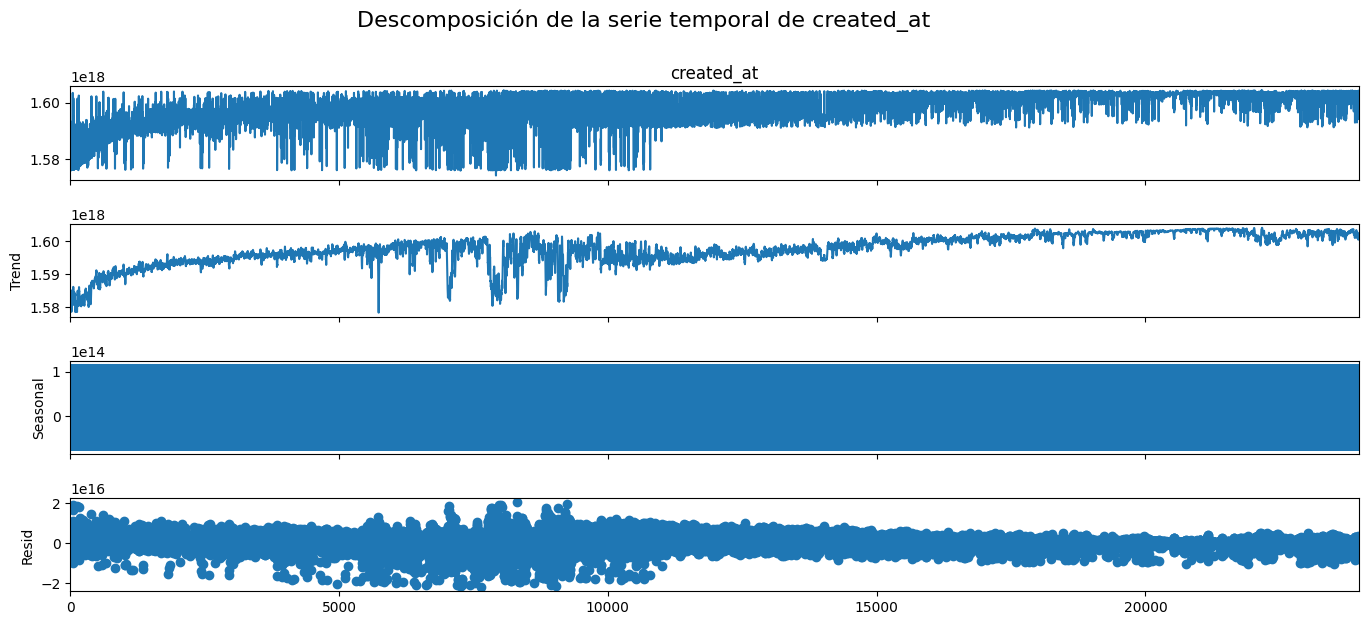

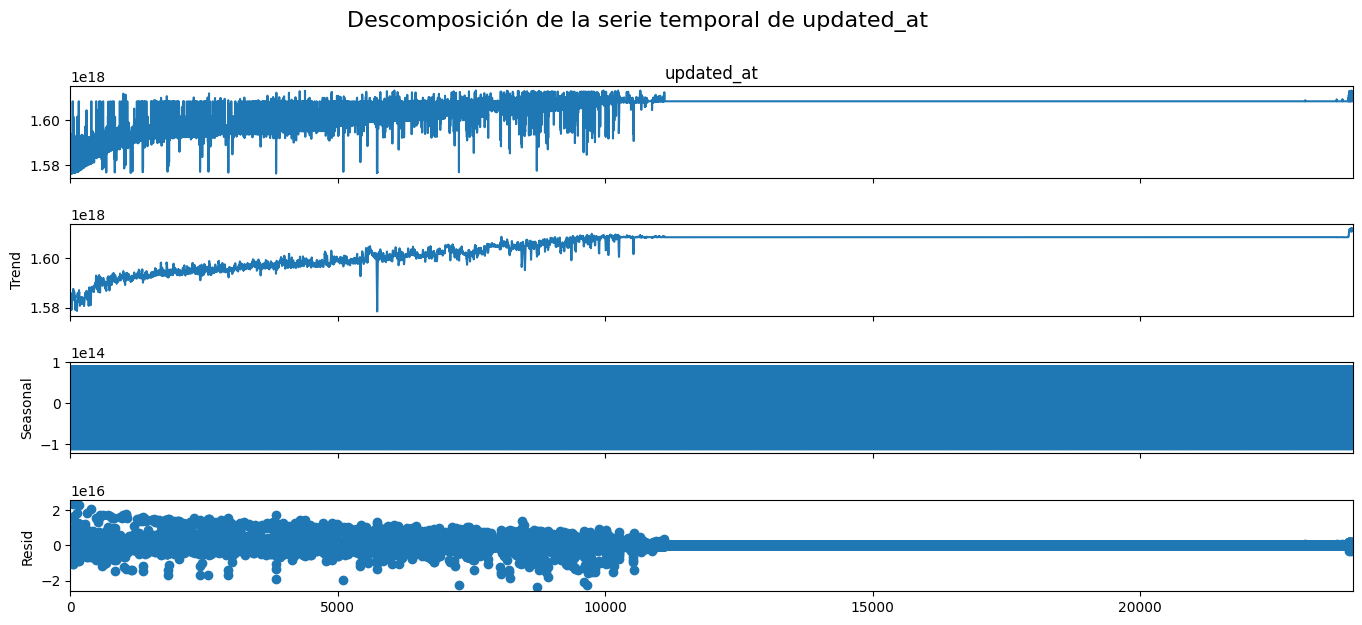

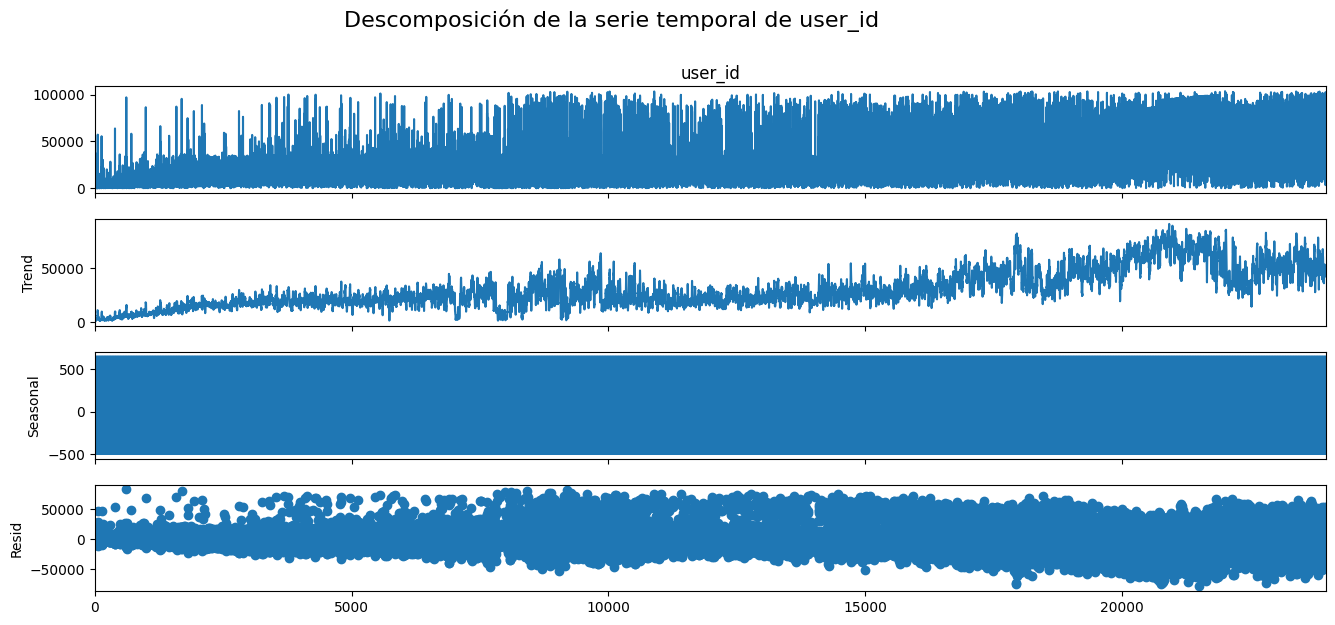

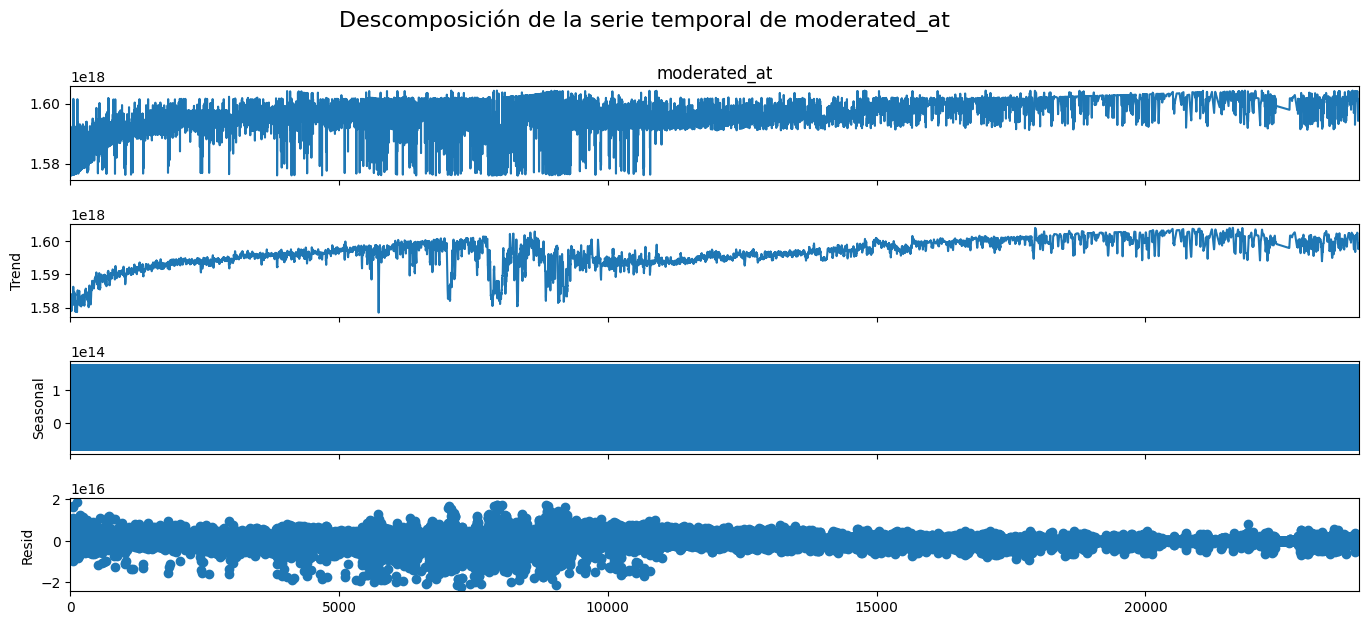

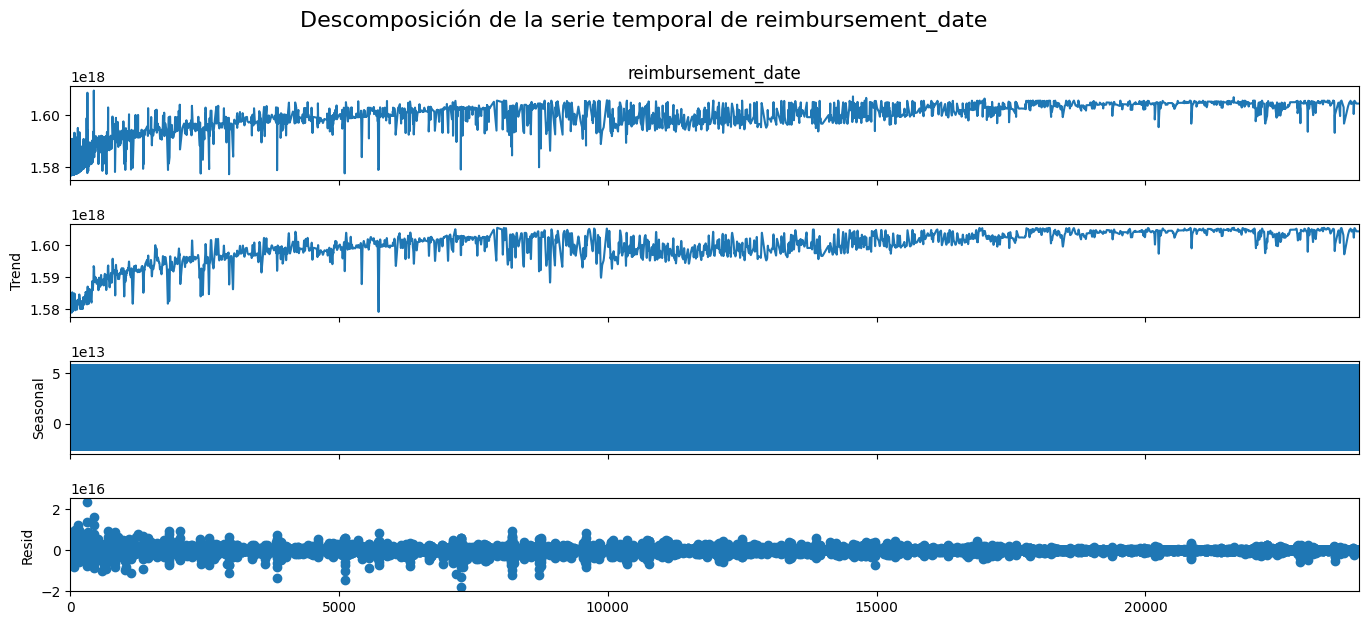

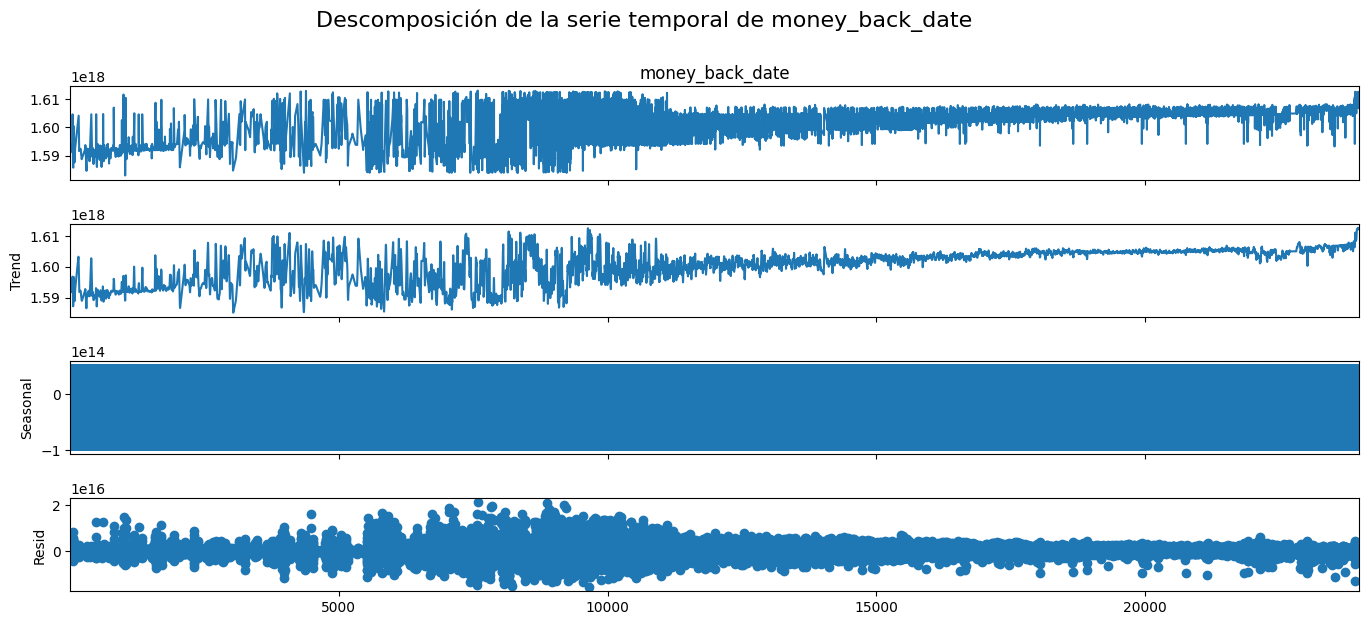

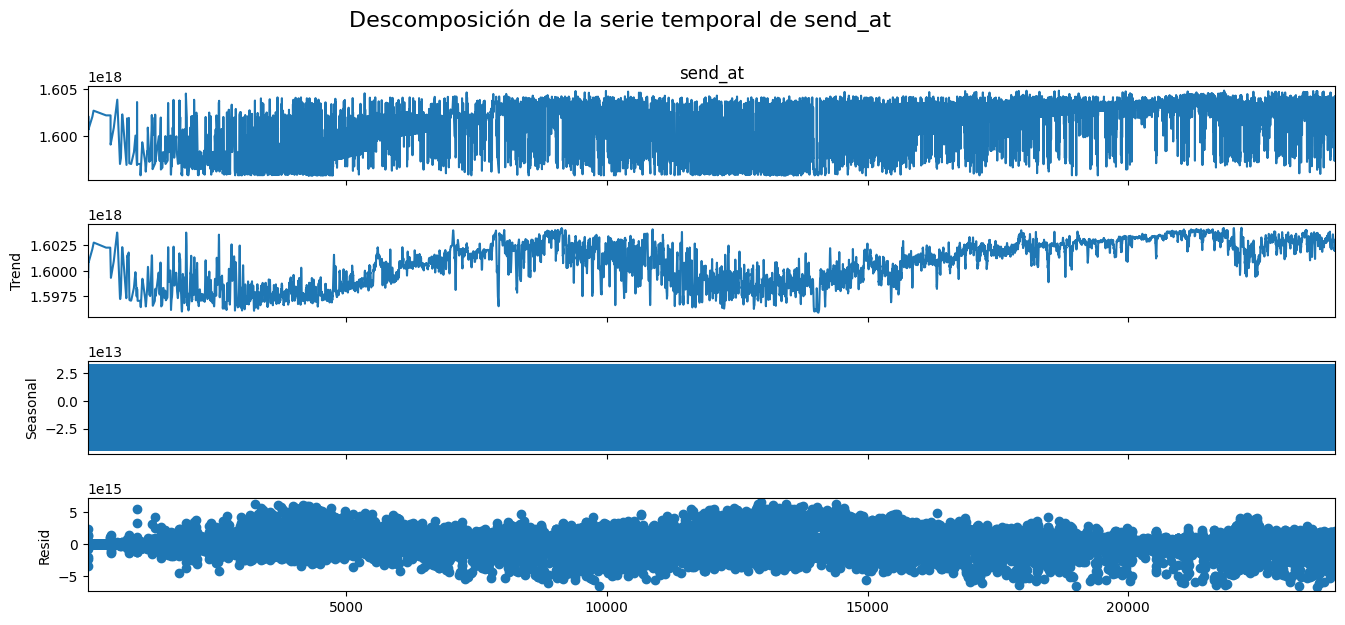

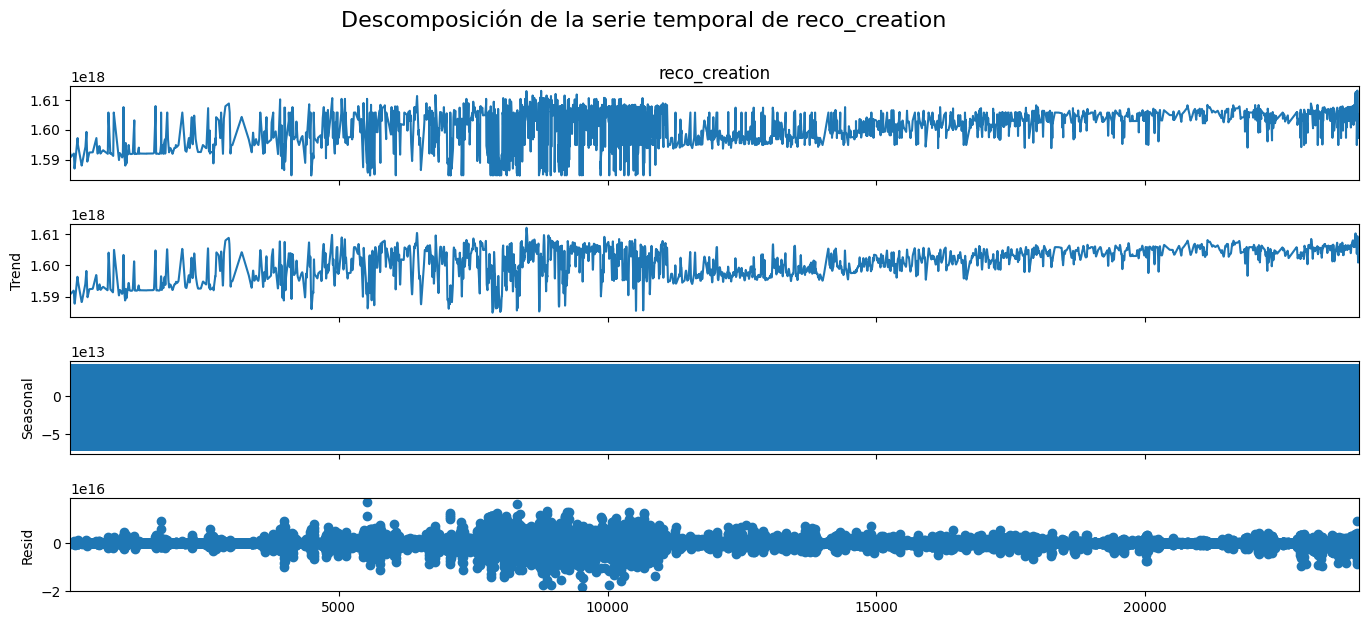

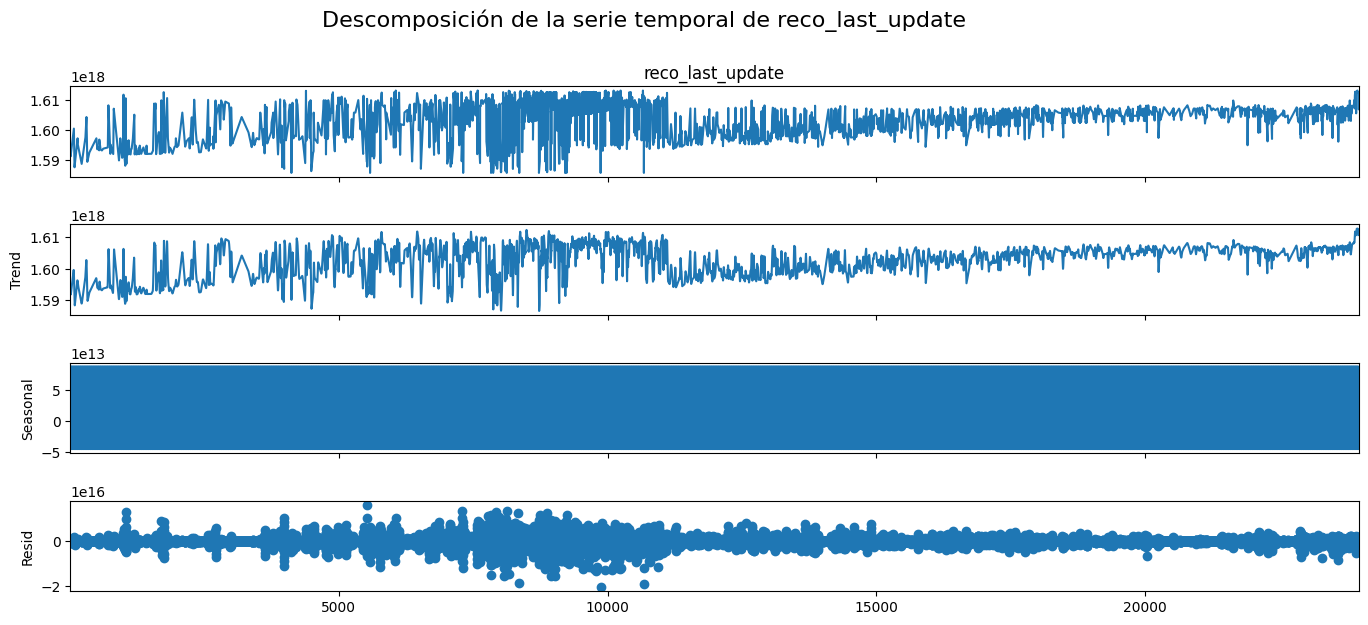

In [460]:
# Descomposición de series temporales para cada columna numérica individual
for c in columnas_numericas_cash_request:
    # Crear una copia del DataFrame para trabajar
    cash_request_copy = cash_request[c].copy()
    # Verifica si hay valores faltantes y elimínalos o interpola
    if cash_request_copy.isnull().any():
        cash_request_copy = cash_request_copy.interpolate() # Rellenar NaN con interpolación
    # Eliminar filas con valores faltantes
    cash_request_copy = cash_request_copy.dropna()
    # Verificar que no hay valores no finitos
    if not np.isfinite(cash_request_copy).all():
        print(f'La columna {c} contiene valores no finitos, se omite la descomposición.')
        continue
    # Descomposición de la serie temporal
    descomposicion = seasonal_decompose(cash_request_copy, model='additive', period=12)
    # Graficar la descomposición
    fig = descomposicion.plot()
    # Ajustar el tamaño de la figura con matplotlib
    plt.gcf().set_size_inches(15, 6)
    # Ajustar el título para que no se superponga
    fig.suptitle(f'Descomposición de la serie temporal de {c}', fontsize=16, y=1.05)
    plt.show()
 

In [373]:
# Crear una copia del DataFrame para preservar el original
cr = cash_request.copy()



In [374]:
# Crear columna 'Mes' indicando el mes de cada solicitud
cr['Mes'] = cr['created_at'].dt.to_period('M')
cr.head()


id  amount    status          created_at          updated_at  user_id  \
0     5   100.0  rejected 2019-12-10 19:00:00 2019-12-11 16:00:00      804   
1    70   100.0  rejected 2019-12-10 19:00:00 2019-12-11 14:00:00      231   
2     7   100.0  rejected 2019-12-10 19:00:00 2019-12-11 09:00:00      191   
3    10    99.0  rejected 2019-12-10 19:00:00 2019-12-18 14:00:00      761   
4  1594   100.0  rejected 2020-05-06 09:00:00 2020-05-07 09:00:00     7686   

         moderated_at  reimbursement_date cash_request_received_date  \
0 2019-12-11 16:00:00 2020-01-09 19:00:00                        NaN   
1 2019-12-11 14:00:00 2020-01-09 19:00:00                        NaN   
2 2019-12-11 09:00:00 2020-01-09 19:00:00                        NaN   
3 2019-12-18 14:00:00 2020-01-09 19:00:00                        NaN   
4 2020-05-07 09:00:00                 NaT                        NaN   

  money_back_date transfer_type send_at recovery_status reco_creation  \
0             NaT       regular     NaT             NaN           NaT   
1             NaT       regular     NaT             NaN           NaT   
2             NaT       regular     NaT             NaN           NaT   
3             NaT       regular     NaT             NaN           NaT   
4             NaT       regular     NaT             NaN           NaT   

  reco_last_update      Mes  
0              NaT  2019-12  
1              NaT  2019-12  
2              NaT  2019-12  
3              NaT  2019-12  
4              NaT  2020-05

In [375]:
# Crear columna 'Cohorte' que indica el mes de la primera solicitud de cada cliente
cr['Cohorte'] = cr.groupby('user_id')['created_at'].transform('min').dt.to_period('M')
cr.head(10)


id  amount      status          created_at          updated_at  user_id  \
0     5   100.0    rejected 2019-12-10 19:00:00 2019-12-11 16:00:00      804   
1    70   100.0    rejected 2019-12-10 19:00:00 2019-12-11 14:00:00      231   
2     7   100.0    rejected 2019-12-10 19:00:00 2019-12-11 09:00:00      191   
3    10    99.0    rejected 2019-12-10 19:00:00 2019-12-18 14:00:00      761   
4  1594   100.0    rejected 2020-05-06 09:00:00 2020-05-07 09:00:00     7686   
5  2145   100.0  money_back 2020-05-23 20:00:00 2020-07-06 03:00:00     9489   
6  3512   100.0    rejected 2020-06-16 17:00:00 2020-06-17 10:00:00    14631   
7   654   100.0    rejected 2020-02-10 01:00:00 2020-02-10 11:00:00      309   
8  5672   100.0    canceled 2020-06-28 12:00:00 2020-06-28 12:00:00     2499   
9    71    90.0    rejected 2019-12-10 19:00:00 2019-12-12 15:00:00      897   

         moderated_at  reimbursement_date cash_request_received_date  \
0 2019-12-11 16:00:00 2020-01-09 19:00:00                        NaN   
1 2019-12-11 14:00:00 2020-01-09 19:00:00                        NaN   
2 2019-12-11 09:00:00 2020-01-09 19:00:00                        NaN   
3 2019-12-18 14:00:00 2020-01-09 19:00:00                        NaN   
4 2020-05-07 09:00:00                 NaT                        NaN   
5 2020-05-24 12:00:00                 NaT                 2020-05-26   
6 2020-06-17 10:00:00                 NaT                        NaN   
7 2020-02-10 09:00:00 2020-03-11 01:00:00                        NaN   
8                 NaT                 NaT                        NaN   
9 2019-12-12 15:00:00 2019-12-17 19:00:00                        NaN   

      money_back_date transfer_type send_at recovery_status  \
0                 NaT       regular     NaT             NaN   
1                 NaT       regular     NaT             NaN   
2                 NaT       regular     NaT             NaN   
3                 NaT       regular     NaT             NaN   
4                 NaT       regular     NaT             NaN   
5 2020-07-06 03:00:00       regular     NaT       completed   
6                 NaT       regular     NaT             NaN   
7                 NaT       regular     NaT             NaN   
8                 NaT       regular     NaT             NaN   
9                 NaT       regular     NaT             NaN   

        reco_creation    reco_last_update      Mes  Cohorte  
0                 NaT                 NaT  2019-12  2019-12  
1                 NaT                 NaT  2019-12  2019-12  
2                 NaT                 NaT  2019-12  2019-12  
3                 NaT                 NaT  2019-12  2019-12  
4                 NaT                 NaT  2020-05  2020-05  
5 2020-06-12 22:00:00 2020-07-06 03:00:00  2020-05  2020-05  
6                 NaT                 NaT  2020-06  2020-06  
7                 NaT                 NaT  2020-02  2020-01  
8                 NaT                 NaT  2020-06  2020-06  
9                 NaT                 NaT  2019-12  2019-12

In [376]:
# Calcular el número inicial de clientes únicos en cada cohorte
cohort_sizes_initial = cr.groupby('Cohorte').agg(Num_Clientes_Iniciales=('user_id', 'nunique')).reset_index()
cohort_sizes_initial


Cohorte  Num_Clientes_Iniciales
0   2019-11                       1
1   2019-12                     254
2   2020-01                     106
3   2020-02                      90
4   2020-03                      86
5   2020-04                     246
6   2020-05                     432
7   2020-06                    1540
8   2020-07                    1482
9   2020-08                     728
10  2020-09                    1950
11  2020-10                    4802
12  2020-11                      76

In [377]:
# Calcular la cantidad de clientes únicos en cada cohorte para cada mes
cohort_sizes_monthly = cr.groupby(['Cohorte', 'Mes']).agg(Num_Clientes=('user_id', 'nunique')).reset_index()
cohort_sizes_monthly


Cohorte      Mes  Num_Clientes
0   2019-11  2019-11             1
1   2019-11  2019-12             1
2   2019-11  2020-04             1
3   2019-11  2020-05             1
4   2019-11  2020-08             1
..      ...      ...           ...
78  2020-09  2020-10           680
79  2020-09  2020-11            20
80  2020-10  2020-10          4802
81  2020-10  2020-11            15
82  2020-11  2020-11            76

[83 rows x 3 columns]

In [378]:
# Calcular la cantidad de solicitudes de adelanto de efectivo de los clientes de cada cohorte en cada mes
cohort_cash_monthly = cr.groupby(['Cohorte', 'Mes']).agg(Num_Solicitudes=('user_id', 'count')).reset_index()
cohort_cash_monthly


Cohorte      Mes  Num_Solicitudes
0   2019-11  2019-11                1
1   2019-11  2019-12                1
2   2019-11  2020-04                1
3   2019-11  2020-05                1
4   2019-11  2020-08                1
..      ...      ...              ...
78  2020-09  2020-10              727
79  2020-09  2020-11               20
80  2020-10  2020-10             5043
81  2020-10  2020-11               15
82  2020-11  2020-11               76

[83 rows x 3 columns]

In [379]:
# Calcular la tasa de retención de clientes (clientes únicos por cohorte en cada mes / clientes iniciales de la cohorte) 
retention_clientes = cohort_sizes_monthly.pivot(index='Cohorte', columns='Mes',values='Num_Clientes')
retention_clientes = retention_clientes.div(cohort_sizes_initial.set_index('Cohorte')['Num_Clientes_Iniciales'], axis=0)
retention_clientes


Mes      2019-11  2019-12   2020-01   2020-02   2020-03   2020-04   2020-05  \
Cohorte                                                                       
2019-11      1.0      1.0       NaN       NaN       NaN  1.000000  1.000000   
2019-12      NaN      1.0  0.354331  0.228346  0.267717  0.263780  0.295276   
2020-01      NaN      NaN  1.000000  0.207547  0.150943  0.254717  0.254717   
2020-02      NaN      NaN       NaN  1.000000  0.500000  0.466667  0.466667   
2020-03      NaN      NaN       NaN       NaN  1.000000  0.441860  0.430233   
2020-04      NaN      NaN       NaN       NaN       NaN  1.000000  0.471545   
2020-05      NaN      NaN       NaN       NaN       NaN       NaN  1.000000   
2020-06      NaN      NaN       NaN       NaN       NaN       NaN       NaN   
2020-07      NaN      NaN       NaN       NaN       NaN       NaN       NaN   
2020-08      NaN      NaN       NaN       NaN       NaN       NaN       NaN   
2020-09      NaN      NaN       NaN       NaN       NaN       NaN       NaN   
2020-10      NaN      NaN       NaN       NaN       NaN       NaN       NaN   
2020-11      NaN      NaN       NaN       NaN       NaN       NaN       NaN   

Mes       2020-06   2020-07   2020-08   2020-09   2020-10   2020-11  
Cohorte                                                              
2019-11       NaN       NaN  1.000000  1.000000  1.000000       NaN  
2019-12  0.287402  0.232283  0.263780  0.169291  0.244094  0.003937  
2020-01  0.254717  0.264151  0.198113  0.188679  0.226415  0.009434  
2020-02  0.433333  0.433333  0.400000  0.277778  0.377778       NaN  
2020-03  0.523256  0.418605  0.395349  0.337209  0.313953  0.011628  
2020-04  0.495935  0.373984  0.325203  0.308943  0.247967       NaN  
2020-05  0.590278  0.506944  0.430556  0.340278  0.356481  0.009259  
2020-06  1.000000  0.490909  0.482468  0.372727  0.367532  0.003247  
2020-07       NaN  1.000000  0.474359  0.344804  0.359649  0.004723  
2020-08       NaN       NaN  1.000000  0.402473  0.339286  0.013736  
2020-09       NaN       NaN       NaN  1.000000  0.348718  0.010256  
2020-10       NaN       NaN       NaN       NaN  1.000000  0.003124  
2020-11       NaN       NaN       NaN       NaN       NaN  1.000000

Text(95.72222222222221, 0.5, 'Cohorte')

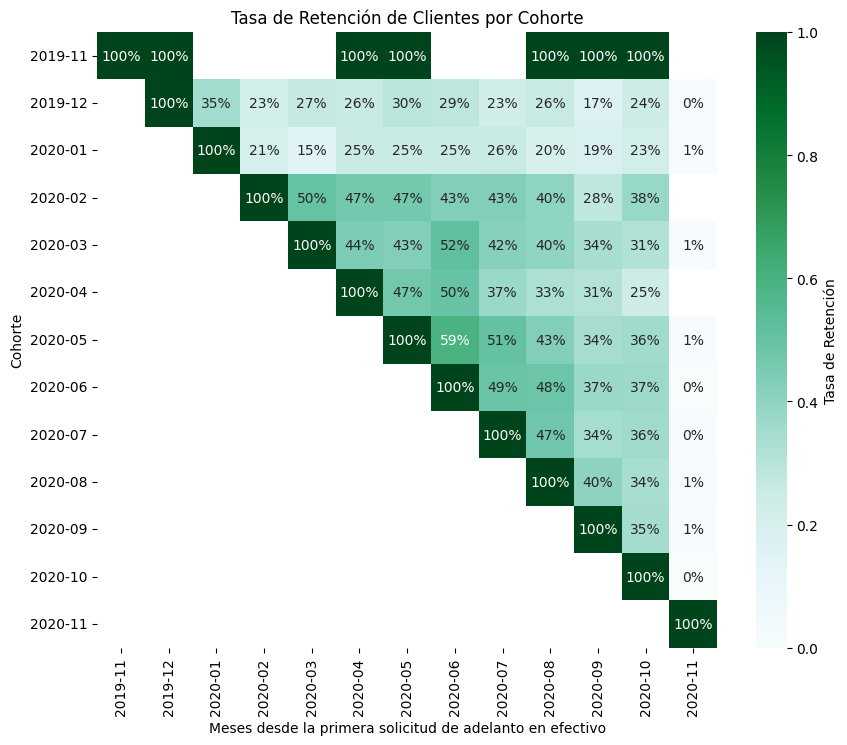

In [380]:
# Visualizar la tasa de retención de clientes usando un mapa de calor
plt.figure(figsize=(10, 8))
plt.title('Tasa de Retención de Clientes por Cohorte')
sns.heatmap(data=retention_clientes, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,cmap='BuGn', cbar_kws={'label': 'Tasa de Retención'})
plt.xlabel('Meses desde la primera solicitud de adelanto en efectivo')
plt.ylabel('Cohorte')


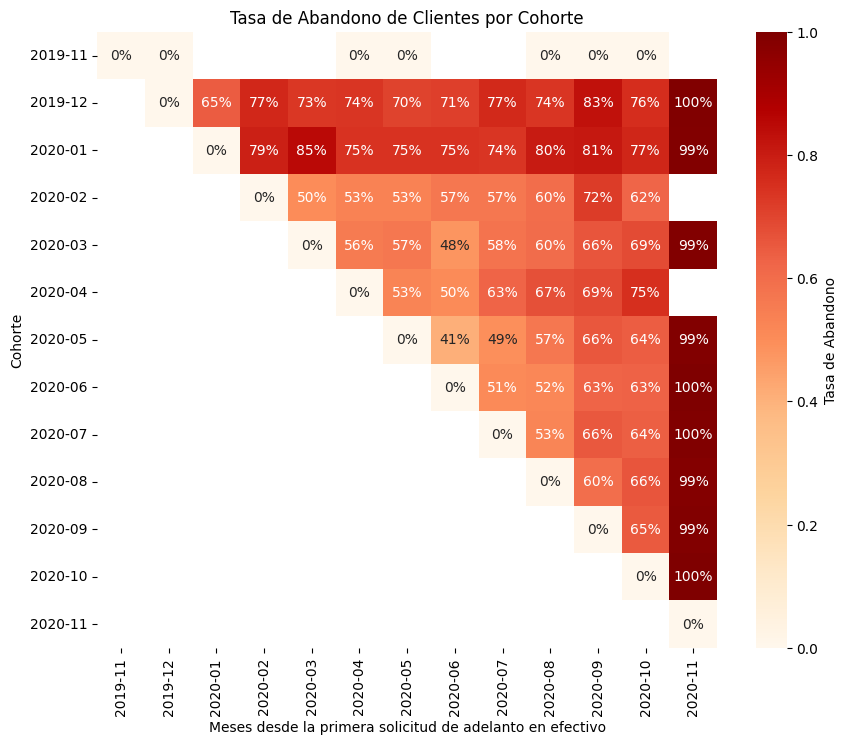

In [381]:
# Calcular la tasa de abandono de clientes (1 - tasa de retención)
churn_clientes = 1 - retention_clientes
# Visualizar la tasa de abandono de clientes usando un mapa de calor
plt.figure(figsize=(10, 8))
plt.title('Tasa de Abandono de Clientes por Cohorte')
sns.heatmap(data=churn_clientes, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,cmap='OrRd', cbar_kws={'label': 'Tasa de Abandono'})
plt.xlabel('Meses desde la primera solicitud de adelanto en efectivo')
plt.ylabel('Cohorte')
plt.show()



In [382]:
# Calcular el número inicial de solicitudes de adelanto de efectivo en cada cohorte
cohort_cash_initial = cohort_cash_monthly.groupby('Cohorte').first().reset_index().rename(columns={'Num_Solicitudes':'Num_Solicitudes_Iniciales'})
cohort_cash_initial


Cohorte      Mes  Num_Solicitudes_Iniciales
0   2019-11  2019-11                          1
1   2019-12  2019-12                        288
2   2020-01  2020-01                        117
3   2020-02  2020-02                         97
4   2020-03  2020-03                         99
5   2020-04  2020-04                        264
6   2020-05  2020-05                        478
7   2020-06  2020-06                       1934
8   2020-07  2020-07                       1996
9   2020-08  2020-08                        993
10  2020-09  2020-09                       2178
11  2020-10  2020-10                       5043
12  2020-11  2020-11                         76

In [383]:
# Calcular la tasa de retención de solicitudes (solicitudes por cohorte en cada mes / solicitudes iniciales de la cohorte)
retention_cash = cohort_cash_monthly.pivot(index='Cohorte', columns='Mes',values='Num_Solicitudes')
retention_cash = retention_cash.div(cohort_cash_initial.set_index('Cohorte')['Num_Solicitudes_Iniciales'], axis=0)
retention_cash


Mes      2019-11  2019-12   2020-01   2020-02   2020-03   2020-04   2020-05  \
Cohorte                                                                       
2019-11      1.0      1.0       NaN       NaN       NaN  1.000000  1.000000   
2019-12      NaN      1.0  0.368056  0.218750  0.274306  0.284722  0.298611   
2020-01      NaN      NaN  1.000000  0.205128  0.145299  0.299145  0.264957   
2020-02      NaN      NaN       NaN  1.000000  0.505155  0.505155  0.463918   
2020-03      NaN      NaN       NaN       NaN  1.000000  0.424242  0.464646   
2020-04      NaN      NaN       NaN       NaN       NaN  1.000000  0.568182   
2020-05      NaN      NaN       NaN       NaN       NaN       NaN  1.000000   
2020-06      NaN      NaN       NaN       NaN       NaN       NaN       NaN   
2020-07      NaN      NaN       NaN       NaN       NaN       NaN       NaN   
2020-08      NaN      NaN       NaN       NaN       NaN       NaN       NaN   
2020-09      NaN      NaN       NaN       NaN       NaN       NaN       NaN   
2020-10      NaN      NaN       NaN       NaN       NaN       NaN       NaN   
2020-11      NaN      NaN       NaN       NaN       NaN       NaN       NaN   

Mes       2020-06   2020-07   2020-08   2020-09   2020-10   2020-11  
Cohorte                                                              
2019-11       NaN       NaN  1.000000  1.000000  2.000000       NaN  
2019-12  0.315972  0.250000  0.291667  0.184028  0.260417  0.003472  
2020-01  0.247863  0.264957  0.188034  0.188034  0.213675  0.008547  
2020-02  0.463918  0.463918  0.453608  0.278351  0.412371       NaN  
2020-03  0.474747  0.404040  0.363636  0.303030  0.303030  0.010101  
2020-04  0.571970  0.439394  0.405303  0.337121  0.284091       NaN  
2020-05  0.665272  0.573222  0.485356  0.376569  0.364017  0.008368  
2020-06  1.000000  0.531024  0.494829  0.355222  0.339193  0.002585  
2020-07       NaN  1.000000  0.471443  0.304609  0.298096  0.003507  
2020-08       NaN       NaN  1.000000  0.348439  0.284995  0.010070  
2020-09       NaN       NaN       NaN  1.000000  0.333792  0.009183  
2020-10       NaN       NaN       NaN       NaN  1.000000  0.002974  
2020-11       NaN       NaN       NaN       NaN       NaN  1.000000

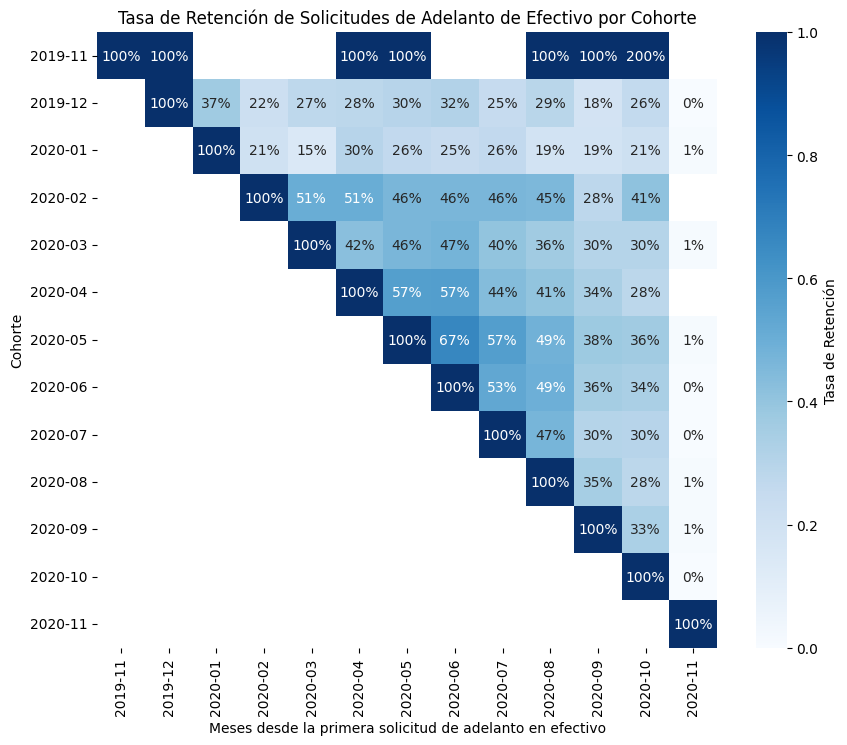

In [384]:
# Visualizar la tasa de retención de solicitudes usando un mapa de calor
plt.figure(figsize=(10, 8))
plt.title('Tasa de Retención de Solicitudes de Adelanto de Efectivo por Cohorte')
sns.heatmap(data=retention_cash, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,cmap='Blues', cbar_kws={'label': 'Tasa de Retención'})
plt.xlabel('Meses desde la primera solicitud de adelanto en efectivo')
plt.ylabel('Cohorte')
plt.show()


In [385]:
# Calcular la tasa de abandono de solicitudes (1 - tasa de retención de solicitudes)
churn_cash = 1 - retention_cash
churn_cash


Mes      2019-11  2019-12   2020-01   2020-02   2020-03   2020-04   2020-05  \
Cohorte                                                                       
2019-11      0.0      0.0       NaN       NaN       NaN  0.000000  0.000000   
2019-12      NaN      0.0  0.631944  0.781250  0.725694  0.715278  0.701389   
2020-01      NaN      NaN  0.000000  0.794872  0.854701  0.700855  0.735043   
2020-02      NaN      NaN       NaN  0.000000  0.494845  0.494845  0.536082   
2020-03      NaN      NaN       NaN       NaN  0.000000  0.575758  0.535354   
2020-04      NaN      NaN       NaN       NaN       NaN  0.000000  0.431818   
2020-05      NaN      NaN       NaN       NaN       NaN       NaN  0.000000   
2020-06      NaN      NaN       NaN       NaN       NaN       NaN       NaN   
2020-07      NaN      NaN       NaN       NaN       NaN       NaN       NaN   
2020-08      NaN      NaN       NaN       NaN       NaN       NaN       NaN   
2020-09      NaN      NaN       NaN       NaN       NaN       NaN       NaN   
2020-10      NaN      NaN       NaN       NaN       NaN       NaN       NaN   
2020-11      NaN      NaN       NaN       NaN       NaN       NaN       NaN   

Mes       2020-06   2020-07   2020-08   2020-09   2020-10   2020-11  
Cohorte                                                              
2019-11       NaN       NaN  0.000000  0.000000 -1.000000       NaN  
2019-12  0.684028  0.750000  0.708333  0.815972  0.739583  0.996528  
2020-01  0.752137  0.735043  0.811966  0.811966  0.786325  0.991453  
2020-02  0.536082  0.536082  0.546392  0.721649  0.587629       NaN  
2020-03  0.525253  0.595960  0.636364  0.696970  0.696970  0.989899  
2020-04  0.428030  0.560606  0.594697  0.662879  0.715909       NaN  
2020-05  0.334728  0.426778  0.514644  0.623431  0.635983  0.991632  
2020-06  0.000000  0.468976  0.505171  0.644778  0.660807  0.997415  
2020-07       NaN  0.000000  0.528557  0.695391  0.701904  0.996493  
2020-08       NaN       NaN  0.000000  0.651561  0.715005  0.989930  
2020-09       NaN       NaN       NaN  0.000000  0.666208  0.990817  
2020-10       NaN       NaN       NaN       NaN  0.000000  0.997026  
2020-11       NaN       NaN       NaN       NaN       NaN  0.000000

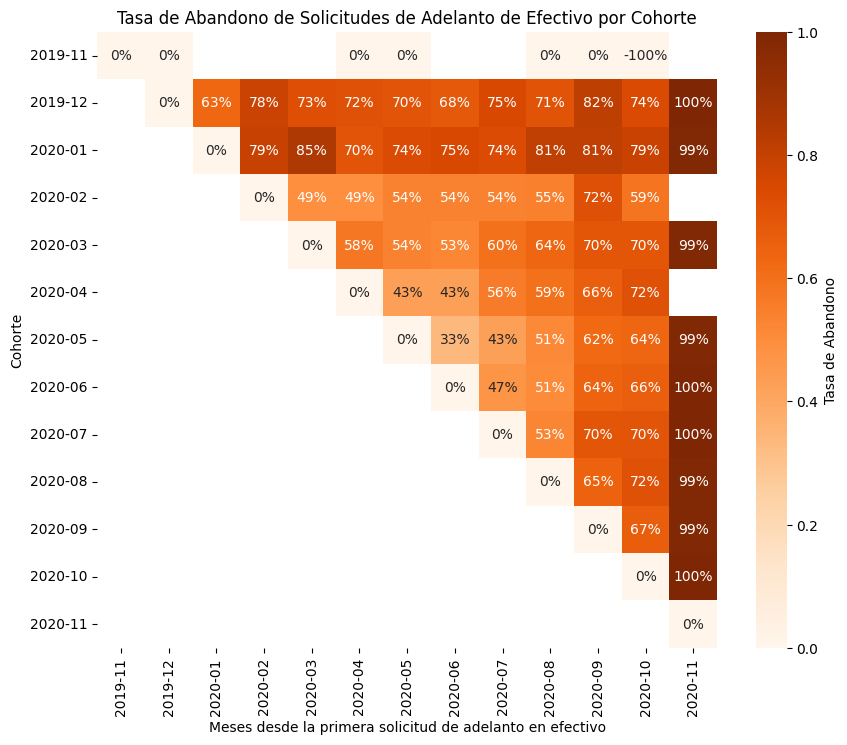

In [386]:
# Visualizar la tasa de abandono de solicitudes usando un mapa de calor
plt.figure(figsize=(10, 8))
plt.title('Tasa de Abandono de Solicitudes de Adelanto de Efectivo por Cohorte')
sns.heatmap(data=churn_cash, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,cmap='Oranges', cbar_kws={'label': 'Tasa de Abandono'})
plt.xlabel('Meses desde la primera solicitud de adelanto en efectivo')
plt.ylabel('Cohorte')
plt.show()



## 2. Descripción de los datos de **Fees**

### 1- Enumeración de Campos y Posibles Valores

1. **`status`**  
   - **Descripción:** Estado de las tarifas relacionadas con el Cash Request (CR).  
   - **Posibles valores:**
     - `confirmed`: La tarifa fue creada y confirmada, pero puede no haberse cobrado.
     - `rejected`: El intento de cobro de la tarifa falló.
     - `cancelled`: La tarifa fue creada pero luego anulada por diversas razones.
     - `accepted`: La tarifa fue cobrada exitosamente.

2. **`category`**  
   - **Descripción:** Razón del incidente asociado a la tarifa.  
   - **Posibles valores:**
     - `rejected_direct_debit`: Tarifas por rechazo del débito directo inicial.
     - `month_delay_on_payment`: Tarifas recurrentes por retrasos mensuales en el pago.

3. **`reason`**  
   - **Descripción:** Descripción del incidente o motivo de la tarifa.  
   - **Posibles valores:** Texto descriptivo (campo libre).

4. **`created_at`**  
   - **Descripción:** Fecha y hora en que se creó la tarifa.  
   - **Posibles valores:** Marca de tiempo (ISO 8601).

5. **`updated_at`**  
   - **Descripción:** Fecha y hora de la última actualización de la tarifa.  
   - **Posibles valores:** Marca de tiempo (ISO 8601).

6. **`paid_at`**  
   - **Descripción:** Fecha y hora en que se pagó la tarifa.  
   - **Posibles valores:** Marca de tiempo (ISO 8601) o `null`.

7. **`from_date`**  
   - **Descripción:** Fecha inicial de reembolso para tarifas por aplazamiento.  
   - **Posibles valores:** Fecha (ISO 8601) o `null`.

8. **`to_date`**  
   - **Descripción:** Nueva fecha de reembolso para tarifas por aplazamiento.  
   - **Posibles valores:** Fecha (ISO 8601) o `null`.

9. **`cash_request_id`**  
   - **Descripción:** Identificador único del CR asociado a esta tarifa.  
   - **Posibles valores:** Identificador único.

10. **`total_amount`**  
    - **Descripción:** Monto total de la tarifa, incluido el IVA.  
    - **Posibles valores:** Número positivo (en la moneda correspondiente).

11. **`charge_moment`**  
    - **Descripción:** Momento en que se cobrará la tarifa.  
    - **Posibles valores:**
      - `before`: Cobro en el momento de la creación de la tarifa.
      - `after`: Cobro en el momento del reembolso del CR.

---

### Reflexión y Preparación para el EDA

#### **Campos a analizar en profundidad:**
1. **`status` y `category`:** 
   - Permiten analizar los motivos de fallos o cancelaciones.
   - Pueden indicar cuántas tarifas son rechazadas versus aceptadas.
2. **`total_amount`:** 
   - Analizar distribuciones de montos, promedios, y posibles valores atípicos.
3. **Tiempos (`created_at`, `paid_at`, `from_date`, `to_date`):**
   - Estudiar los intervalos entre fechas para identificar patrones o retrasos en los pagos.
4. **`charge_moment`:**
   - Comparar el rendimiento de tarifas cobradas "antes" versus "después".

#### **Transformaciones necesarias:**
1. **Estandarización temporal:**
   - Asegurar que las marcas de tiempo estén en el mismo formato (ISO 8601).
   - Crear variables derivadas como diferencias entre `created_at` y `paid_at`.
2. **Manejo de valores nulos:**
   - Completar o analizar los campos como `paid_at`, `from_date`, y `to_date` según el contexto.
3. **Agrupación de categorías:**
   - Agrupar razones (`category` y `reason`) para facilitar su interpretación.
4. **Transformación monetaria:**
   - Convertir `total_amount` a una única moneda si el dataset abarca múltiples regiones.
5. **Identificación de outliers:**
   - Detectar montos inusualmente altos o incidentes recurrentes en los estados `rejected` o `cancelled`.

Estas transformaciones permiten un análisis robusto, detectando posibles patrones de fallos, evaluando la efectividad de los cobros y optimizando estrategias futuras.

In [387]:
# Cargar el dataset de tarifas o fees para análisis de cohortes de tarifas
fees = pd.read_csv('../project_dataset/extract - fees - data analyst - .csv')
fees.head()

id  cash_request_id             type    status               category  \
0   6537          14941.0  instant_payment  rejected                    NaN   
1   6961          11714.0         incident  accepted  rejected_direct_debit   
2  16296          23371.0  instant_payment  accepted                    NaN   
3  20775          26772.0  instant_payment  accepted                    NaN   
4  11242          19350.0  instant_payment  accepted                    NaN   

   total_amount                              reason  \
0           5.0  Instant Payment Cash Request 14941   
1           5.0               rejected direct debit   
2           5.0  Instant Payment Cash Request 23371   
3           5.0  Instant Payment Cash Request 26772   
4           5.0  Instant Payment Cash Request 19350   

                      created_at                     updated_at  \
0   2020-09-07 10:47:27.42315+00  2020-10-13 14:25:09.396112+00   
1  2020-09-09 20:51:17.998653+00  2020-10-13 14:25:15.537063+00   
2  2020-10-23 10:10:58.352972+00  2020-10-23 10:10:58.352994+00   
3  2020-10-31 15:46:53.643958+00  2020-10-31 15:46:53.643982+00   
4  2020-10-06 08:20:17.170432+00  2020-10-13 14:25:03.267983+00   

                         paid_at from_date to_date charge_moment  
0   2020-12-17 14:50:07.47011+00       NaN     NaN         after  
1   2020-12-08 17:13:10.45908+00       NaN     NaN         after  
2   2020-11-04 19:34:37.43291+00       NaN     NaN         after  
3  2020-11-19 05:09:22.500223+00       NaN     NaN         after  
4  2020-11-02 14:45:20.355598+00       NaN     NaN         after

In [388]:
# Inspeccionar la estructura y el tipo de datos de 'fees'
fees.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21061 entries, 0 to 21060
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               21061 non-null  int64  
 1   cash_request_id  21057 non-null  float64
 2   type             21061 non-null  object 
 3   status           21061 non-null  object 
 4   category         2196 non-null   object 
 5   total_amount     21061 non-null  float64
 6   reason           21061 non-null  object 
 7   created_at       21061 non-null  object 
 8   updated_at       21061 non-null  object 
 9   paid_at          15531 non-null  object 
 10  from_date        7766 non-null   object 
 11  to_date          7766 non-null   object 
 12  charge_moment    21061 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 2.1+ MB


In [389]:

# Crear una copia del DataFrame para preservar el original
fs = fees.copy()



In [390]:
# Filtrar columnas relevantes para el análisis
fs = fs[["cash_request_id", "total_amount", "created_at", 'category', 'updated_at', 'paid_at', 'from_date', 'to_date','status']]
fs.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21061 entries, 0 to 21060
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cash_request_id  21057 non-null  float64
 1   total_amount     21061 non-null  float64
 2   created_at       21061 non-null  object 
 3   category         2196 non-null   object 
 4   updated_at       21061 non-null  object 
 5   paid_at          15531 non-null  object 
 6   from_date        7766 non-null   object 
 7   to_date          7766 non-null   object 
 8   status           21061 non-null  object 
dtypes: float64(2), object(7)
memory usage: 1.4+ MB


In [391]:
# 1. Manejo de valores faltantes
# - For simplicity: drop rows where `cash_request_id` is NaN (primary key related)
# - Impute 'category' with 'Unknown', keep `paid_at`, `from_date`, `to_date` for further filtering
data_cleaned = fs.dropna(subset=['cash_request_id'])
data_cleaned['category'] = data_cleaned['category'].fillna('Unknown')

# 2. Estandarización de formatos
# Convert datetime columns to pandas datetime
datetime_columns = ['created_at', 'updated_at', 'paid_at', 'from_date', 'to_date']
for col in datetime_columns:
    data_cleaned[col] = pd.to_datetime(data_cleaned[col], errors='coerce')

# Standardize column names
data_cleaned.columns = data_cleaned.columns.str.lower().str.replace(' ', '_')

# 3. Filtrado de datos irrelevantes
# Remove rows with invalid or irrelevant `status`
valid_statuses = ['accepted', 'rejected', 'pending']
data_cleaned = data_cleaned[data_cleaned['status'].isin(valid_statuses)]

# Resultado final
display(data_cleaned.info())
data_cleaned.head()


<class 'pandas.core.frame.DataFrame'>
Index: 16035 entries, 0 to 21060
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   cash_request_id  16035 non-null  float64            
 1   total_amount     16035 non-null  float64            
 2   created_at       16035 non-null  datetime64[ns, UTC]
 3   category         16035 non-null  object             
 4   updated_at       16035 non-null  datetime64[ns, UTC]
 5   paid_at          15354 non-null  datetime64[ns, UTC]
 6   from_date        2554 non-null   datetime64[ns, UTC]
 7   to_date          2513 non-null   datetime64[ns, UTC]
 8   status           16035 non-null  object             
dtypes: datetime64[ns, UTC](5), float64(2), object(2)
memory usage: 1.2+ MB


None

cash_request_id  total_amount                       created_at  \
0          14941.0           5.0 2020-09-07 10:47:27.423150+00:00   
1          11714.0           5.0 2020-09-09 20:51:17.998653+00:00   
2          23371.0           5.0 2020-10-23 10:10:58.352972+00:00   
3          26772.0           5.0 2020-10-31 15:46:53.643958+00:00   
4          19350.0           5.0 2020-10-06 08:20:17.170432+00:00   

                category                       updated_at  \
0                Unknown 2020-10-13 14:25:09.396112+00:00   
1  rejected_direct_debit 2020-10-13 14:25:15.537063+00:00   
2                Unknown 2020-10-23 10:10:58.352994+00:00   
3                Unknown 2020-10-31 15:46:53.643982+00:00   
4                Unknown 2020-10-13 14:25:03.267983+00:00   

                           paid_at from_date to_date    status  
0 2020-12-17 14:50:07.470110+00:00       NaT     NaT  rejected  
1 2020-12-08 17:13:10.459080+00:00       NaT     NaT  accepted  
2 2020-11-04 19:34:37.432910+00:00       NaT     NaT  accepted  
3 2020-11-19 05:09:22.500223+00:00       NaT     NaT  accepted  
4 2020-11-02 14:45:20.355598+00:00       NaT     NaT  accepted

El archivo CSV contiene 13 columnas y 21,061 filas. Aquí hay un resumen de las acciones necesarias para limpiar los datos:

### 1. **Manejo de valores faltantes**
   - Columnas como `category`, `paid_at`, `from_date`, `to_date` contienen valores nulos. Se decidirá si imputar o eliminar dependiendo del análisis requerido.

### 2. **Estandarización de formatos**
   - **Fechas**: Las columnas `created_at`, `updated_at`, `paid_at`, `from_date`, `to_date` deben convertirse a formato datetime.
   - **Nombres de columnas**: Se convertirán a minúsculas y se reemplazarán los espacios con guiones bajos para consistencia.
   - **Tipos de datos**: Verificar y ajustar los tipos de datos según la naturaleza de cada columna.

### 3. **Filtrado de datos irrelevantes**
   - Determinar las filas irrelevantes o fuera del alcance del análisis. Esto dependerá de columnas clave como `type` o `status`.

Voy a implementar estos pasos ahora.

La limpieza de datos está completa. Aquí está el resumen del resultado:

### Resumen del Dataset Limpio
- **Total de filas**: 16,035 (eliminadas filas con valores nulos en `cash_request_id` y filtradas por `status` válido).
- **Columnas ajustadas**:
  - Valores nulos en `category` imputados con "Unknown".
  - Formato de columnas de fechas (`created_at`, `updated_at`, etc.) convertido a `datetime`.
  - Nombres de columnas estandarizados (minúsculas y con guiones bajos).
- **Datos faltantes**:
  - `paid_at`: 596 filas con valores nulos.
  - `from_date` y `to_date`: la mayoría de los valores están nulos, lo cual requiere análisis adicional.

Si necesitas algún análisis o transformación adicional, ¡avísame!

In [392]:

# Convertir la columna 'created_at' en fees a tipo datetime para análisis temporal
fs['created_at'] = pd.to_datetime(fs['created_at'])
fs.head()


cash_request_id  total_amount                       created_at  \
0          14941.0           5.0 2020-09-07 10:47:27.423150+00:00   
1          11714.0           5.0 2020-09-09 20:51:17.998653+00:00   
2          23371.0           5.0 2020-10-23 10:10:58.352972+00:00   
3          26772.0           5.0 2020-10-31 15:46:53.643958+00:00   
4          19350.0           5.0 2020-10-06 08:20:17.170432+00:00   

                category                     updated_at  \
0                    NaN  2020-10-13 14:25:09.396112+00   
1  rejected_direct_debit  2020-10-13 14:25:15.537063+00   
2                    NaN  2020-10-23 10:10:58.352994+00   
3                    NaN  2020-10-31 15:46:53.643982+00   
4                    NaN  2020-10-13 14:25:03.267983+00   

                         paid_at from_date to_date    status  
0   2020-12-17 14:50:07.47011+00       NaN     NaN  rejected  
1   2020-12-08 17:13:10.45908+00       NaN     NaN  accepted  
2   2020-11-04 19:34:37.43291+00       NaN     NaN  accepted  
3  2020-11-19 05:09:22.500223+00       NaN     NaN  accepted  
4  2020-11-02 14:45:20.355598+00       NaN     NaN  accepted

In [393]:


# Convertir la columna 'created_at' a una fecha sin zona horaria
fs['created_at'] = fs['created_at'].dt.tz_localize(None)
fs.head()


cash_request_id  total_amount                 created_at  \
0          14941.0           5.0 2020-09-07 10:47:27.423150   
1          11714.0           5.0 2020-09-09 20:51:17.998653   
2          23371.0           5.0 2020-10-23 10:10:58.352972   
3          26772.0           5.0 2020-10-31 15:46:53.643958   
4          19350.0           5.0 2020-10-06 08:20:17.170432   

                category                     updated_at  \
0                    NaN  2020-10-13 14:25:09.396112+00   
1  rejected_direct_debit  2020-10-13 14:25:15.537063+00   
2                    NaN  2020-10-23 10:10:58.352994+00   
3                    NaN  2020-10-31 15:46:53.643982+00   
4                    NaN  2020-10-13 14:25:03.267983+00   

                         paid_at from_date to_date    status  
0   2020-12-17 14:50:07.47011+00       NaN     NaN  rejected  
1   2020-12-08 17:13:10.45908+00       NaN     NaN  accepted  
2   2020-11-04 19:34:37.43291+00       NaN     NaN  accepted  
3  2020-11-19 05:09:22.500223+00       NaN     NaN  accepted  
4  2020-11-02 14:45:20.355598+00       NaN     NaN  accepted

In [394]:

# Crear columna 'Mes' indicando el mes de cada solicitud
fs['Mes'] = fs['created_at'].dt.to_period('M')
fs.head()


cash_request_id  total_amount                 created_at  \
0          14941.0           5.0 2020-09-07 10:47:27.423150   
1          11714.0           5.0 2020-09-09 20:51:17.998653   
2          23371.0           5.0 2020-10-23 10:10:58.352972   
3          26772.0           5.0 2020-10-31 15:46:53.643958   
4          19350.0           5.0 2020-10-06 08:20:17.170432   

                category                     updated_at  \
0                    NaN  2020-10-13 14:25:09.396112+00   
1  rejected_direct_debit  2020-10-13 14:25:15.537063+00   
2                    NaN  2020-10-23 10:10:58.352994+00   
3                    NaN  2020-10-31 15:46:53.643982+00   
4                    NaN  2020-10-13 14:25:03.267983+00   

                         paid_at from_date to_date    status      Mes  
0   2020-12-17 14:50:07.47011+00       NaN     NaN  rejected  2020-09  
1   2020-12-08 17:13:10.45908+00       NaN     NaN  accepted  2020-09  
2   2020-11-04 19:34:37.43291+00       NaN     NaN  accepted  2020-10  
3  2020-11-19 05:09:22.500223+00       NaN     NaN  accepted  2020-10  
4  2020-11-02 14:45:20.355598+00       NaN     NaN  accepted  2020-10

In [395]:

# Crear columna 'Cohorte' que indica el mes del primer cargo de cada cliente
fs['Cohorte'] = fs.groupby('cash_request_id')['created_at'].transform('min').dt.to_period('M')
fs.head()


cash_request_id  total_amount                 created_at  \
0          14941.0           5.0 2020-09-07 10:47:27.423150   
1          11714.0           5.0 2020-09-09 20:51:17.998653   
2          23371.0           5.0 2020-10-23 10:10:58.352972   
3          26772.0           5.0 2020-10-31 15:46:53.643958   
4          19350.0           5.0 2020-10-06 08:20:17.170432   

                category                     updated_at  \
0                    NaN  2020-10-13 14:25:09.396112+00   
1  rejected_direct_debit  2020-10-13 14:25:15.537063+00   
2                    NaN  2020-10-23 10:10:58.352994+00   
3                    NaN  2020-10-31 15:46:53.643982+00   
4                    NaN  2020-10-13 14:25:03.267983+00   

                         paid_at from_date to_date    status      Mes  Cohorte  
0   2020-12-17 14:50:07.47011+00       NaN     NaN  rejected  2020-09  2020-09  
1   2020-12-08 17:13:10.45908+00       NaN     NaN  accepted  2020-09  2020-08  
2   2020-11-04 19:34:37.43291+00       NaN     NaN  accepted  2020-10  2020-10  
3  2020-11-19 05:09:22.500223+00       NaN     NaN  accepted  2020-10  2020-10  
4  2020-11-02 14:45:20.355598+00       NaN     NaN  accepted  2020-10  2020-10

In [396]:

# Calcular la cantidad de tarifas iniciales por cohorte
cohort_fees_initial = fs.groupby('Cohorte').agg(Num_Tarifas_Iniciales=('cash_request_id', 'nunique')).reset_index()
cohort_fees_initial


Cohorte  Num_Tarifas_Iniciales
0  2020-05                     14
1  2020-06                    447
2  2020-07                    856
3  2020-08                   1922
4  2020-09                   2640
5  2020-10                   6930
6  2020-11                    124

In [397]:

# Calcular el número de tarifas en cada cohorte para cada mes
cohort_fees_monthly = fs.groupby(['Cohorte', 'Mes']).agg(Num_Tarifas=('cash_request_id', 'nunique')).reset_index()
cohort_fees_monthly


Cohorte      Mes  Num_Tarifas
0   2020-05  2020-05           14
1   2020-05  2020-06            5
2   2020-05  2020-07            2
3   2020-05  2020-08            1
4   2020-05  2020-09            1
5   2020-05  2020-10            1
6   2020-06  2020-06          447
7   2020-06  2020-07          196
8   2020-06  2020-08           74
9   2020-06  2020-09           42
10  2020-06  2020-10           37
11  2020-07  2020-07          856
12  2020-07  2020-08          318
13  2020-07  2020-09          172
14  2020-07  2020-10          123
15  2020-08  2020-08         1922
16  2020-08  2020-09          685
17  2020-08  2020-10          379
18  2020-09  2020-09         2640
19  2020-09  2020-10          953
20  2020-09  2020-11           17
21  2020-10  2020-10         6930
22  2020-10  2020-11           99
23  2020-11  2020-11          124

In [398]:

# Calcular la tasa de retención de tarifas (número de tarifas de cada cohorte en cada mes / tarifas iniciales de la cohorte)
retention_fees = cohort_fees_monthly.pivot(index='Cohorte', columns='Mes',values='Num_Tarifas')
retention_fees = retention_fees.div(cohort_fees_initial.set_index('Cohorte')['Num_Tarifas_Iniciales'], axis=0)
retention_fees


Mes      2020-05   2020-06   2020-07   2020-08   2020-09   2020-10   2020-11
Cohorte                                                                     
2020-05      1.0  0.357143  0.142857  0.071429  0.071429  0.071429       NaN
2020-06      NaN  1.000000  0.438479  0.165548  0.093960  0.082774       NaN
2020-07      NaN       NaN  1.000000  0.371495  0.200935  0.143692       NaN
2020-08      NaN       NaN       NaN  1.000000  0.356400  0.197190       NaN
2020-09      NaN       NaN       NaN       NaN  1.000000  0.360985  0.006439
2020-10      NaN       NaN       NaN       NaN       NaN  1.000000  0.014286
2020-11      NaN       NaN       NaN       NaN       NaN       NaN  1.000000

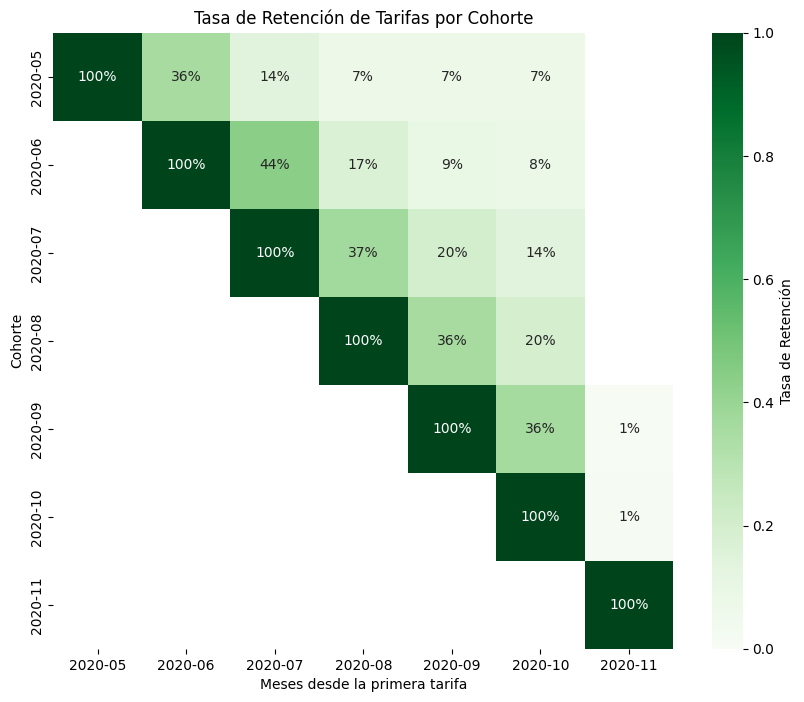

In [399]:

# Visualizar la tasa de retención de tarifas usando un mapa de calor
plt.figure(figsize=(10, 8))
plt.title('Tasa de Retención de Tarifas por Cohorte')
sns.heatmap(data=retention_fees, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,cmap='Greens', cbar_kws={'label': 'Tasa de Retención'})
plt.xlabel('Meses desde la primera tarifa')
plt.ylabel('Cohorte')
plt.show()


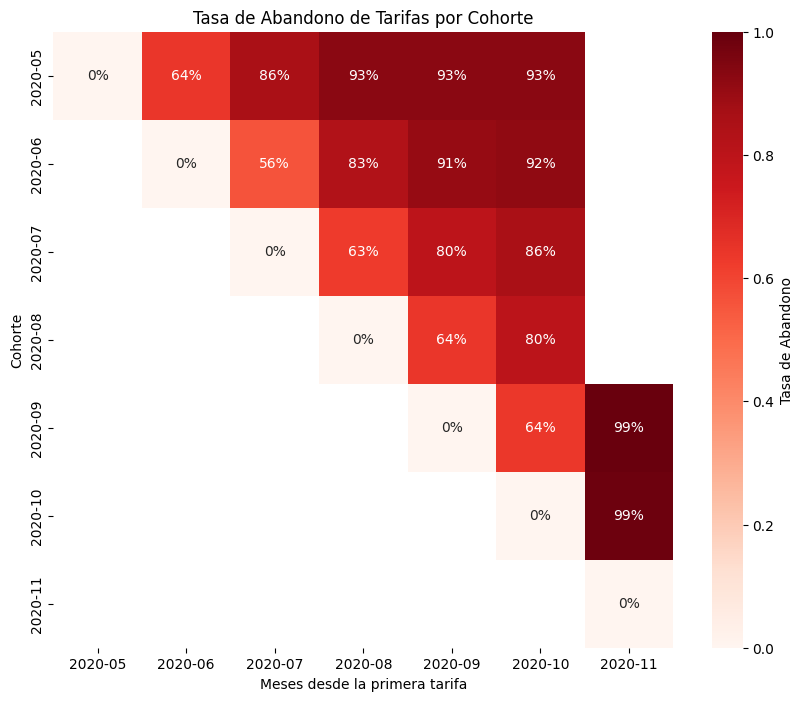

In [400]:

# Calcular la tasa de abandono de tarifas (1 - tasa de retención de tarifas)
churn_fees = 1 - retention_fees

# Visualizar la tasa de abandono de tarifas usando un mapa de calor
plt.figure(figsize=(10, 8))
plt.title('Tasa de Abandono de Tarifas por Cohorte')
sns.heatmap(data=churn_fees, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,cmap='Reds', cbar_kws={'label': 'Tasa de Abandono'})
plt.xlabel('Meses desde la primera tarifa')
plt.ylabel('Cohorte')
plt.show()



## 2 Análisis de Cohortes Avanzado y la Extracción de Insights


El análisis de cohortes avanzado y la extracción de insights son componentes cruciales en el ámbit el análisis de datos y la toma de decisiones estratégicas en diversos campos,desde elmarketin igital hasta la gestión de productos y servicios.Ambos procesos permiten entender mejor el co mportamiento de los usuarios, identificar patrones significativos y tomar decisiones fundamentadas e atos. A continuación, se detallan algunas estrategias comunes para llevar a cabo estas prácticas:
### 2.1 Análisis de Cohortes Avanzado:
El análisis de cohortes se refiere a la agrupación de individuos que comparten una característic omún o que han experimentado un evento similar en un período específico de tiempo.El análisi vanzado de cohortes implica eluso de técnicas más sofisticadas para comprender mejor elcomportamiento de estos grupos a lo largo deltiempo y extraer insights valiosos.A continuación,s etallan técnicas y enfoques comunes:
1. **Refinamiento de Cohortes**
    - Segmentación adicional de cohortes: Divide los grupos en subconjuntos más específicos basados en características demográficas (edad, género, ubicación), comportamiento specíficos (frecuencia de compra, interacciones en línea) o patrones de uso (horarios d so, dispositivos utilizados).Esto permite una comprensión más profunda de los comportamientos y necesidades de diferentes grupos de usuarios.
    - Utilización de técnicas de clustering: Aplica algoritmos de agrupamiento par dentificar subgrupos dentro de las cohortes principales.Esto te permite descubrir patrones más complejos y segmentar los datos de manera más precisa,lo que facilita l ersonalización de estrategias y acciones.
2. **Análisis de Retención**
    - Seguimiento de la retención: Observa cómo cambia la cantidad de usuarios activo entro de cada cohorte a lo largo del tiempo.Esto te ayuda a comprender si los usuario ermanecen comprometidos con tu producto o servicio y a identificar posibles problema e retención.
    - Identificación de factores de retención: Examina qué factores influyen en la retención de los usuarios (como la calidad delproducto,la experiencia delusuario o la romociones).Luego,desarrolla estrategias para mejorar la retención basadas en esto allazgos,lo que puede incluir mejoras en la experiencia delusuario,ofertas especiale  programas de fidelización.
3. **Cohortes Dinámicas**
    - Creación de cohortes dinámicas: Actualiza continuamente las cohortes para refleja os cambios en el comportamiento del usuario o las características del producto.Esto t ermite mantener un seguimiento preciso de la evolución del rendimiento a lo largo de iempo y adaptar tus estrategias en consecuencia.
    - Uso de modelos predictivos: Implementa modelos que puedan predecir elcomportamiento futuro de las cohortes en función de datos históricos y variables clave.Esto t yuda a anticipar tendencias y tomar decisiones proactivas, como la personalización d fertas o la optimización de la distribución de recursos.
4. **Análisis de Recurrencia**
    - Estudio de la frecuencia de retorno: Analiza qué tan a menudo los usuarios regresa espués de su primera interacción con tu producto o servicio.Esto te permite entende a lealtad del cliente y su propensión a continuar utilizando tu oferta.
    - Identificación de patrones recurrentes: Busca patrones en el comportamiento de lo suarios que indican una alta probabilidad de regreso, como la frecuencia de compra o l articipación en actividades específicas.Estos patrones pueden ser clave para desarrolla strategias efectivas de retención y compromiso.
5. **Análisis de Comportamiento**
    - Seguimiento del comportamiento individual: Examina cómo se comportan lo suarios dentro de cada cohorte a lo largo deltiempo. Esto te ayuda a identifica endencias, cambios de comportamiento y momentos clave en el ciclo de vida del usuario,
1 o que puede informar la optimización de la experiencia del usuario y la personalizació e las estrategias de marketing.
    - Identificación de patrones y puntos de inflexión: Busca momentos en los que e omportamiento de los usuarios cambie significativamente, como la adopción de nueva aracterísticas o la disminución de la actividad.Estos puntos de inflexión pueden se portunidades para la intervención y la mejora continua del producto o servicio.
### 2.2 Extracción de Insights:
La extracción de insights implica el proceso de identificar y comprender información significativa y útil a partir de los datos analizados.A continuación, se detallan algunas estrategias comunes par xtraer insights del análisis de cohortes:
1. **Segmentación Avanzada**
    - Segmentación detallada de las cohortes: Divide los grupos en segmentos más específicos basados en características compartidas o comportamientos similares.Esto t ermite personalizar tus estrategias para satisfacer las necesidades únicas de cada segmento, lo que puede mejorar la efectividad de tus acciones y campañas.
    - Personalización de estrategias: Utiliza los segmentos identificados para adaptar tu strategias de marketing,comunicación y experiencia delusuario, lo que aumenta l elevancia y la efectividad de tus acciones y mejora la satisfacción del cliente.
2. **Identificación de Tendencias**
    - Detección de tendencias a lo largo del tiempo: Analiza cómo evolucionan la étricas clave (como la retención o el compromiso) dentro de cada cohorte con el tiempo.
Esto te ayuda a identificar patrones y entender cómo ciertos eventos o cambios afecta l comportamiento de los usuarios, lo que puede informar decisiones estratégicas futuras.
    - Análisis de eventos específicos: Examina cómo eventos como lanzamientos de productos, campañas de marketing o cambios en el diseño impactan en el comportamient e las cohortes.Esto te proporciona información valiosa para la planificación futura  a evaluación del éxito de tus iniciativas.
3. **Predicción y Modelado**
    - Utilización de modelos predictivos: Implementa modelos que puedan predecir e omportamiento futuro de las cohortes en función de datos históricos y variables clave.
Esto te ayuda a anticipar tendencias y tomar decisiones informadas sobre estrategia uturas, lo que puede aumentar la eficiencia y el éxito de tus acciones.
    - Evaluación de impacto: Evalúa el impacto potencialde cambios en productos,servicios o estrategias antes de implementarlos.Esto te permite tomar decisiones má ólidas y minimizar los riesgos asociados con nuevas iniciativas, lo que puede mejorar l entabilidad y la satisfacción del cliente a largo plazo.
4. **Benchmarking y Comparación**
    - Comparación del rendimiento: Compara el rendimiento de diferentes cohortes  egmentos de usuarios para identificar áreas de fortaleza y oportunidades de mejora.
Esto te ayuda a entender tu posición en el mercado y a identificar estrategias par iferenciarte y destacarte entre la competencia.
    - Benchmarking contra competidores: Compara tus métricas con las de tus competidores o estándares de la industria para entender tu posición en el mercado y encontra portunidades para diferenciarte.Esto te proporciona información valiosa sobre la ejores prácticas y te ayuda a identificar áreas de mejora y oportunidades de crec1 miento.
5. **Acciones Estratégicas**
    - Desarrollo de estrategias específicas: Utiliza los insights obtenidos para desarrolla strategias específicas destinadas a mejorar la retención, el compromiso y el crecimient e tu negocio.Esto puede incluir cambios en productos o servicios, ajustes en la estrategia de marketing o mejoras en la experiencia del cliente.
    - Evaluación continua: Evalúa regularmente la efectividad de tus estrategias a travé el análisis de cohortes en curso y realiza ajustes según sea necesario para optimizar lo esultados a lo largo del tiempo.Esto te permite adaptarte a los cambios en el mercad  mantener una ventaja competitiva a largo plazo.


In [401]:
# Agregar columnas de temporalidad
# Semana y mes de la solicitud
cr['Semana_Mes'] = cr['created_at'].dt.strftime('%U_%B') + '_' + cr['Mes'].dt.strftime('%Y')
# Día y semana de la solicitud
cr['Dia_Semana'] = cr['created_at'].dt.strftime('%A') + '_' + cr['Semana_Mes']
# Hora y dia de la solicitud
cr['Hora_Dia'] = cr['created_at'].dt.hour.astype(str) + '_' + cr['Dia_Semana']
cr.head()


id  amount    status          created_at          updated_at  user_id  \
0     5   100.0  rejected 2019-12-10 19:00:00 2019-12-11 16:00:00      804   
1    70   100.0  rejected 2019-12-10 19:00:00 2019-12-11 14:00:00      231   
2     7   100.0  rejected 2019-12-10 19:00:00 2019-12-11 09:00:00      191   
3    10    99.0  rejected 2019-12-10 19:00:00 2019-12-18 14:00:00      761   
4  1594   100.0  rejected 2020-05-06 09:00:00 2020-05-07 09:00:00     7686   

         moderated_at  reimbursement_date cash_request_received_date  \
0 2019-12-11 16:00:00 2020-01-09 19:00:00                        NaN   
1 2019-12-11 14:00:00 2020-01-09 19:00:00                        NaN   
2 2019-12-11 09:00:00 2020-01-09 19:00:00                        NaN   
3 2019-12-18 14:00:00 2020-01-09 19:00:00                        NaN   
4 2020-05-07 09:00:00                 NaT                        NaN   

  money_back_date transfer_type send_at recovery_status reco_creation  \
0             NaT       regular     NaT             NaN           NaT   
1             NaT       regular     NaT             NaN           NaT   
2             NaT       regular     NaT             NaN           NaT   
3             NaT       regular     NaT             NaN           NaT   
4             NaT       regular     NaT             NaN           NaT   

  reco_last_update      Mes  Cohorte        Semana_Mes  \
0              NaT  2019-12  2019-12  49_December_2019   
1              NaT  2019-12  2019-12  49_December_2019   
2              NaT  2019-12  2019-12  49_December_2019   
3              NaT  2019-12  2019-12  49_December_2019   
4              NaT  2020-05  2020-05       18_May_2020   

                 Dia_Semana                     Hora_Dia  
0  Tuesday_49_December_2019  19_Tuesday_49_December_2019  
1  Tuesday_49_December_2019  19_Tuesday_49_December_2019  
2  Tuesday_49_December_2019  19_Tuesday_49_December_2019  
3  Tuesday_49_December_2019  19_Tuesday_49_December_2019  
4     Wednesday_18_May_2020      9_Wednesday_18_May_2020

In [402]:

# Calcular la cantidad de adelanto de efectivo por cohorte y mes
cohort_revenue = cr.groupby(['Cohorte', 'Mes'])['amount'].sum().reset_index()
cohort_revenue = cohort_revenue.pivot(index='Cohorte', columns='Mes',values='amount')
cohort_revenue





Mes      2019-11  2019-12  2020-01  2020-02  2020-03  2020-04  2020-05  \
Cohorte                                                                  
2019-11      1.0    100.0      NaN      NaN      NaN    100.0     10.0   
2019-12      NaN  27197.0  10123.0   5881.0   7650.0   7900.0   8175.0   
2020-01      NaN      NaN  11464.0   2360.0   1660.0   3500.0   3020.0   
2020-02      NaN      NaN      NaN   8412.0   4740.0   4607.0   4350.0   
2020-03      NaN      NaN      NaN      NaN   9499.0   4250.0   4540.0   
2020-04      NaN      NaN      NaN      NaN      NaN  25736.0  14258.0   
2020-05      NaN      NaN      NaN      NaN      NaN      NaN  44883.0   
2020-06      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2020-07      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2020-08      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2020-09      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2020-10      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2020-11      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

Mes       2020-06   2020-07  2020-08   2020-09   2020-10  2020-11  
Cohorte                                                            
2019-11       NaN       NaN     10.0       5.0       6.0      NaN  
2019-12    8805.0    6990.0   7790.0    4860.0    6655.0    100.0  
2020-01    2770.0    3010.0   2150.0    1970.0    2350.0    100.0  
2020-02    4235.0    4405.0   4130.0    2555.0    3595.0      NaN  
2020-03    4850.0    4055.0   3390.0    2800.0    2700.0     50.0  
2020-04   14320.0   11000.0   9915.0    7685.0    6450.0      NaN  
2020-05   30143.0   25725.0  21224.0   16350.0   15305.0    350.0  
2020-06  180903.0   92672.0  84491.0   60025.0   56525.0    400.0  
2020-07       NaN  180330.0  76873.0   49725.0   47313.0    500.0  
2020-08       NaN       NaN  77660.0   24870.0   22130.0    675.0  
2020-09       NaN       NaN      NaN  165662.0   49865.0   1475.0  
2020-10       NaN       NaN      NaN       NaN  346445.0   1200.0  
2020-11       NaN       NaN      NaN       NaN       NaN   5860.0

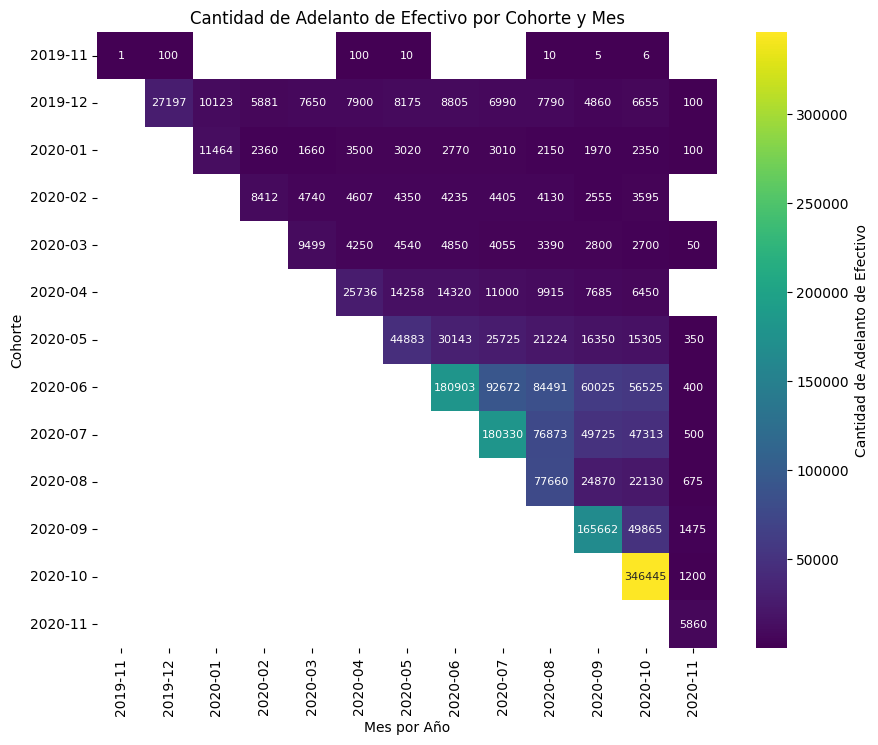

In [403]:
# Graficar la cantidad de adelanto de efectivo por cohorte y mes
plt.figure(figsize=(10, 8))
plt.title('Cantidad de Adelanto de Efectivo por Cohorte y Mes')
sns.heatmap(data=cohort_revenue, annot=True, fmt='.0f', cmap='viridis',annot_kws={"size": 8}, cbar_kws={'label': 'Cantidad de Adelanto de Efectivo'})
plt.xlabel('Mes por Año')
plt.ylabel('Cohorte')
plt.show()




In [404]:

# Crear DataFrame de cohortes para el mes de '2020-03'
cohort_amount_2020_03 = cr[cr['Cohorte'] == '2020-03'].groupby('user_id')['amount'].sum().reset_index()
cohort_amount_2020_03




user_id  amount
0       161   400.0
1       400   800.0
2       447   100.0
3       448    80.0
4       475   100.0
..      ...     ...
81    13975   650.0
82    14798   650.0
83    16345   400.0
84    21228   200.0
85    21543   100.0

[86 rows x 2 columns]

In [405]:

# Ordenar por el monto total para encontrar los 10 usuarios principales
sort_cohort_amount_2020_03 = cohort_amount_2020_03.sort_values(by='amount',ascending=False)
top_10_users = sort_cohort_amount_2020_03.head(10)
top_10_users



user_id  amount
36     3377  1305.0
52     4297  1200.0
45     3617  1000.0
50     3948   950.0
20     2548   900.0
43     3557   900.0
9       680   850.0
1       400   800.0
77     4715   800.0
23     2841   750.0

In [406]:


# Filtrar para incluir solo los 10 usuarios seleccionados
amount_2020_03 = cr[cr['Cohorte'] == '2020-03'].groupby(['user_id','Mes'])['amount'].sum().reset_index()
cohort_amount_2020_03_top10 = amount_2020_03[amount_2020_03['user_id'].isin(top_10_users['user_id'])]
cohort_amount_2020_03_top10 = cohort_amount_2020_03_top10.pivot(index='user_id', columns='Mes', values='amount')
cohort_amount_2020_03_top10





Mes      2020-03  2020-04  2020-05  2020-06  2020-07  2020-08  2020-09  \
user_id                                                                  
400        100.0    100.0    100.0    100.0    100.0    100.0    100.0   
680        200.0    100.0    100.0    100.0    100.0    100.0    100.0   
2548       100.0    100.0    100.0    100.0    100.0    200.0      NaN   
2841       100.0    100.0    100.0    100.0    100.0    100.0    100.0   
3377       300.0    150.0    270.0    200.0    185.0    100.0     50.0   
3557       200.0    200.0      NaN    200.0    200.0    100.0      NaN   
3617       200.0      NaN    200.0    100.0    200.0    100.0    100.0   
3948       200.0    200.0    200.0    100.0      NaN    100.0      NaN   
4297       200.0    200.0    200.0    200.0    200.0    100.0    100.0   
4715       100.0      NaN    100.0    100.0    200.0    100.0    100.0   

Mes      2020-10  2020-11  
user_id                    
400        100.0      NaN  
680         50.0      NaN  
2548       200.0      NaN  
2841        50.0      NaN  
3377         NaN     50.0  
3557         NaN      NaN  
3617       100.0      NaN  
3948       150.0      NaN  
4297         NaN      NaN  
4715       100.0      NaN

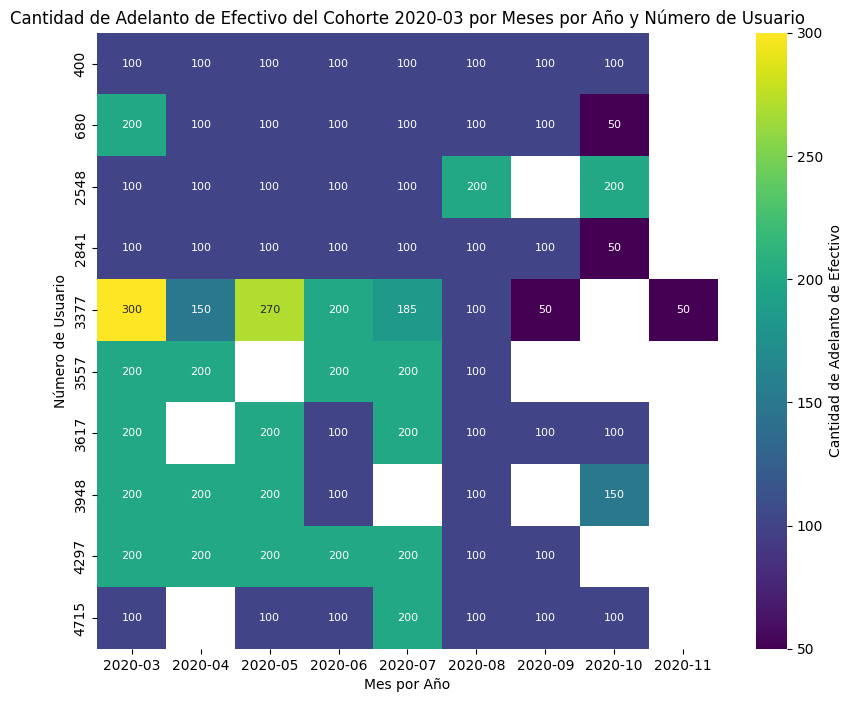

In [407]:

# Graficar la cantidad de adelanto de efectivo de un cohorte por meses y número de usuarios
plt.figure(figsize=(10, 8))
plt.title('Cantidad de Adelanto de Efectivo del Cohorte 2020-03 por Meses por Año y Número de Usuario')
sns.heatmap(data=cohort_amount_2020_03_top10, annot=True, fmt='.0f', cmap='viridis', annot_kws={"size": 8}, cbar_kws={'label': 'Cantidad de Adelanto de Efectivo'})
plt.xlabel('Mes por Año')
plt.ylabel('Número de Usuario')
plt.show()




In [408]:

# Filtrar para calcular la cantidad de adelanto de efectivo por cohorte y semana
cohort_weekly_amount = cr[cr['Cohorte'] == '2020-03'].groupby(['user_id','Semana_Mes'])['amount'].sum().reset_index()
cohort_weekly_amount




user_id         Semana_Mes  amount
0        161      09_March_2020   100.0
1        161      14_April_2020   100.0
2        161        19_May_2020   100.0
3        161       23_June_2020   100.0
4        400      10_March_2020   100.0
..       ...                ...     ...
362    16345     31_August_2020   100.0
363    16345  36_September_2020   100.0
364    21228      13_March_2020   100.0
365    21228     32_August_2020   100.0
366    21543      11_March_2020   100.0

[367 rows x 3 columns]

In [409]:

# Filtrar para incluir solo los 10 usuarios seleccionados
cohort_weekly_amount_top10 =cohort_weekly_amount[cohort_weekly_amount['user_id'].isin(top_10_users['user_id'])]
cohort_weekly_amount_top10 = cohort_weekly_amount_top10.pivot(index='user_id',columns='Semana_Mes', values='amount')
cohort_weekly_amount_top10



Semana_Mes  09_March_2020  10_March_2020  11_March_2020  12_March_2020  \
user_id                                                                  
400                   NaN          100.0            NaN            NaN   
680                 100.0            NaN          100.0            NaN   
2548                100.0            NaN            NaN            NaN   
2841                  NaN            NaN          100.0            NaN   
3377                  NaN          100.0          100.0          100.0   
3557                  NaN          200.0            NaN            NaN   
3617                200.0            NaN            NaN            NaN   
3948                  NaN            NaN          100.0          100.0   
4297                  NaN            NaN          200.0            NaN   
4715                  NaN            NaN            NaN          100.0   

Semana_Mes  13_April_2020  14_April_2020  15_April_2020  16_April_2020  \
user_id                                                                  
400                   NaN          100.0            NaN            NaN   
680                   NaN          100.0            NaN            NaN   
2548                  NaN            NaN          100.0            NaN   
2841                  NaN            NaN          100.0            NaN   
3377                 50.0            NaN            NaN          100.0   
3557                  NaN          200.0            NaN            NaN   
3617                  NaN            NaN            NaN            NaN   
3948                100.0            NaN            NaN          100.0   
4297                200.0            NaN            NaN            NaN   
4715                  NaN            NaN            NaN            NaN   

Semana_Mes  18_May_2020  19_May_2020  ...  33_August_2020  34_August_2020  \
user_id                               ...                                   
400               100.0          NaN  ...             NaN             NaN   
680                 NaN        100.0  ...             NaN             NaN   
2548              100.0          NaN  ...             NaN             NaN   
2841                NaN        100.0  ...             NaN             NaN   
3377              100.0         50.0  ...             NaN             NaN   
3557                NaN          NaN  ...           100.0             NaN   
3617                NaN          NaN  ...             NaN             NaN   
3948                NaN        100.0  ...             NaN           100.0   
4297                NaN        200.0  ...             NaN             NaN   
4715              100.0          NaN  ...             NaN             NaN   

Semana_Mes  35_August_2020  35_September_2020  36_September_2020  \
user_id                                                            
400                    NaN                NaN                NaN   
680                    NaN              100.0                NaN   
2548                 100.0                NaN                NaN   
2841                   NaN                NaN                NaN   
3377                   NaN               50.0                NaN   
3557                   NaN                NaN                NaN   
3617                   NaN              100.0                NaN   
3948                   NaN                NaN                NaN   
4297                   NaN                NaN                NaN   
4715                   NaN                NaN              100.0   

Semana_Mes  37_September_2020  40_October_2020  41_October_2020  \
user_id                                                           
400                     100.0            100.0              NaN   
680                       NaN             50.0              NaN   
2548                      NaN            100.0              NaN   
2841                    100.0             50.0              NaN   
3377                      NaN              NaN              NaN   
3557       

In [410]:


# Seleccionar las primeras 10 semanas
cohort_weekly_amount_top10 = cohort_weekly_amount_top10.loc[:,cohort_weekly_amount_top10.columns[:10]]
cohort_weekly_amount_top10





Semana_Mes  09_March_2020  10_March_2020  11_March_2020  12_March_2020  \
user_id                                                                  
400                   NaN          100.0            NaN            NaN   
680                 100.0            NaN          100.0            NaN   
2548                100.0            NaN            NaN            NaN   
2841                  NaN            NaN          100.0            NaN   
3377                  NaN          100.0          100.0          100.0   
3557                  NaN          200.0            NaN            NaN   
3617                200.0            NaN            NaN            NaN   
3948                  NaN            NaN          100.0          100.0   
4297                  NaN            NaN          200.0            NaN   
4715                  NaN            NaN            NaN          100.0   

Semana_Mes  13_April_2020  14_April_2020  15_April_2020  16_April_2020  \
user_id                                                                  
400                   NaN          100.0            NaN            NaN   
680                   NaN          100.0            NaN            NaN   
2548                  NaN            NaN          100.0            NaN   
2841                  NaN            NaN          100.0            NaN   
3377                 50.0            NaN            NaN          100.0   
3557                  NaN          200.0            NaN            NaN   
3617                  NaN            NaN            NaN            NaN   
3948                100.0            NaN            NaN          100.0   
4297                200.0            NaN            NaN            NaN   
4715                  NaN            NaN            NaN            NaN   

Semana_Mes  18_May_2020  19_May_2020  
user_id                               
400               100.0          NaN  
680                 NaN        100.0  
2548              100.0          NaN  
2841                NaN        100.0  
3377              100.0         50.0  
3557                NaN          NaN  
3617                NaN          NaN  
3948                NaN        100.0  
4297                NaN        200.0  
4715              100.0          NaN

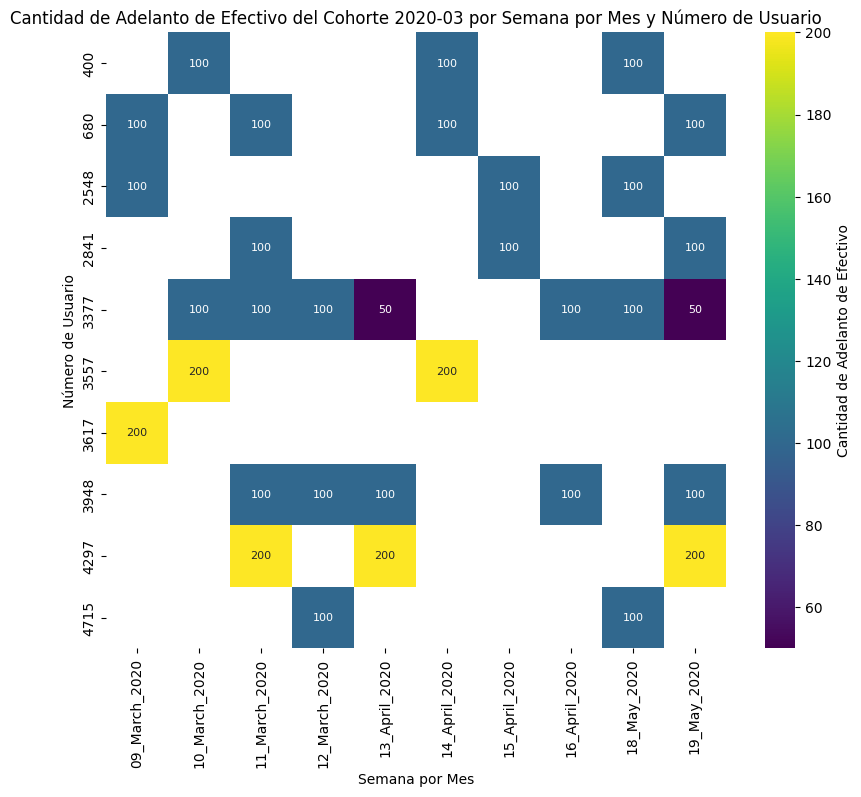

In [411]:
# Graficar la cantidad de adelanto de efectivo de los 10 principales usuarios por semana
plt.figure(figsize=(10, 8))
plt.title('Cantidad de Adelanto de Efectivo del Cohorte 2020-03 por Semana por Mes y Número de Usuario')
sns.heatmap(data=cohort_weekly_amount_top10, annot=True, fmt='.0f', cmap='viridis', annot_kws={"size": 8}, cbar_kws={'label': 'Cantidad de Adelanto de Efectivo'})
plt.xlabel('Semana por Mes')
plt.ylabel('Número de Usuario')
plt.show()



In [412]:
# Filtrar para calcular la cantidad de adelanto de efectivo por cohorte y día de la semana
cohort_daily_amount = cr[ (cr['Cohorte'] == '2020-03') & (cr['Semana_Mes'] == '10_March_2020') ].groupby(['user_id', 'Dia_Semana'])['amount'].sum().reset_index()
cohort_daily_amount





user_id               Dia_Semana  amount
0       400     Monday_10_March_2020   100.0
1       475     Monday_10_March_2020   100.0
2       479    Tuesday_10_March_2020   100.0
3       496  Wednesday_10_March_2020   100.0
4       575    Tuesday_10_March_2020   100.0
5       876   Thursday_10_March_2020   100.0
6      1101     Friday_10_March_2020   100.0
7      1280     Monday_10_March_2020   100.0
8      2197     Monday_10_March_2020   100.0
9      2976  Wednesday_10_March_2020    50.0
10     3377     Monday_10_March_2020   100.0
11     3391    Tuesday_10_March_2020   100.0
12     3549     Sunday_10_March_2020   100.0
13     3557  Wednesday_10_March_2020   200.0
14     3628   Thursday_10_March_2020   100.0
15     4314     Sunday_10_March_2020   100.0
16     4376   Saturday_10_March_2020   100.0
17     4474     Monday_10_March_2020   100.0
18     4476  Wednesday_10_March_2020   100.0
19     4505  Wednesday_10_March_2020   100.0
20     4518     Friday_10_March_2020    10.0
21     4546   Thursday_10_March_2020   100.0
22     4549   Saturday_10_March_2020   100.0
23     4580  Wednesday_10_March_2020   100.0
24     4582  Wednesday_10_March_2020   100.0
25     4595   Saturday_10_March_2020   100.0
26     4607   Thursday_10_March_2020    50.0
27    10430     Monday_10_March_2020   100.0

In [413]:
# Filtrar para incluir solo los 10 usuarios seleccionados
cohort_daily_amount_top10 = cohort_daily_amount[cohort_daily_amount['user_id'].isin(top_10_users['user_id'])]
cohort_daily_amount_top10 = cohort_daily_amount_top10.pivot(index='user_id',columns='Dia_Semana', values='amount')
cohort_daily_amount_top10




Dia_Semana  Monday_10_March_2020  Wednesday_10_March_2020
user_id                                                  
400                        100.0                      NaN
3377                       100.0                      NaN
3557                         NaN                    200.0

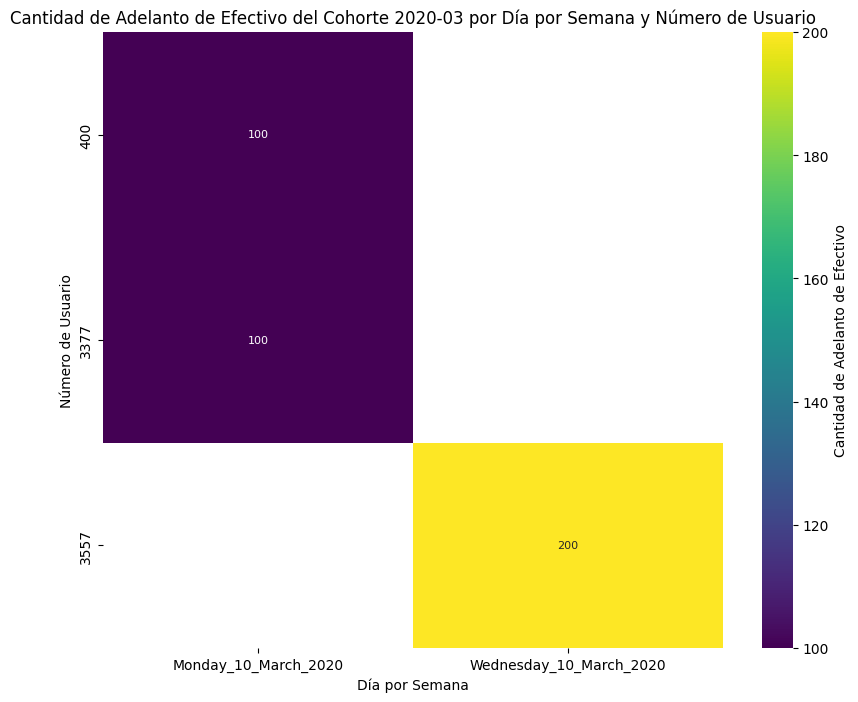

In [414]:
# Graficar la cantidad de adelanto de efectivo de los 10 principales usuarios por día de la semana
plt.figure(figsize=(10, 8))
plt.title('Cantidad de Adelanto de Efectivo del Cohorte 2020-03 por Día por Semana y Número de Usuario')
sns.heatmap(data=cohort_daily_amount_top10, annot=True, fmt='.0f', cmap='viridis', annot_kws={"size": 8}, cbar_kws={'label': 'Cantidad de Adelanto de Efectivo'})
plt.xlabel('Día por Semana')
plt.ylabel('Número de Usuario')
plt.show()





In [415]:
# Filtrar para calcular la cantidad de adelanto de efectivo por cohorte y hora
cohort_hourly_amount = cr[(cr['Cohorte'] == '2020-03') & (cr['Semana_Mes'] == '10_March_2020') & (cr['Dia_Semana'] == 'Monday_10_March_2020')].groupby(['user_id', 'Hora_Dia'])['amount'].sum().reset_index()
cohort_hourly_amount




user_id                 Hora_Dia  amount
0      400   7_Monday_10_March_2020   100.0
1      475   9_Monday_10_March_2020   100.0
2     1280  19_Monday_10_March_2020   100.0
3     2197  15_Monday_10_March_2020   100.0
4     3377  13_Monday_10_March_2020   100.0
5     4474  10_Monday_10_March_2020   100.0
6    10430  15_Monday_10_March_2020   100.0

In [416]:
# Filtrar para incluir solo los 10 usuarios seleccionados
cohort_hourly_amount_top10 = cohort_hourly_amount[cohort_hourly_amount['user_id'].isin(top_10_users['user_id'])]
cohort_hourly_amount_top10 = cohort_hourly_amount_top10.pivot(index='user_id', columns='Hora_Dia', values='amount')
cohort_hourly_amount_top10




Hora_Dia  13_Monday_10_March_2020  7_Monday_10_March_2020
user_id                                                  
400                           NaN                   100.0
3377                        100.0                     NaN

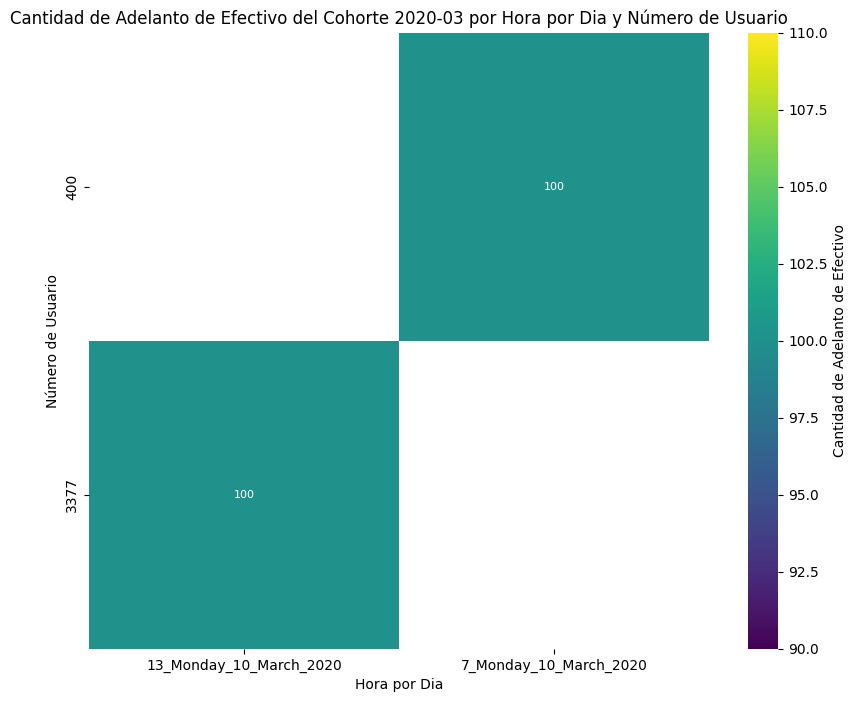

In [417]:
# Graficar la cantidad de adelanto de efectivo de los 10 principales usuarios por hora
plt.figure(figsize=(10, 8))
plt.title('Cantidad de Adelanto de Efectivo del Cohorte 2020-03 por Hora por Dia y Número de Usuario')
sns.heatmap(data=cohort_hourly_amount_top10, annot=True, fmt='.0f', cmap='viridis', annot_kws={"size": 8}, cbar_kws={'label': 'Cantidad de Adelanto de Efectivo'})
plt.xlabel('Hora por Dia')
plt.ylabel('Número de Usuario')
plt.show()
